## Chapter 11: Principles of Feature Learning

# 11.3 Efficient cross-validation via boosting

In the previous Section we saw how to employ the validation error measurement tool to perform cross-validation on a set of models taking the standard form

\begin{equation}
\text{model}\left(\mathbf{x},\Theta\right) = w_0 + f_1\left(\mathbf{x}\right){w}_{1} +  f_2\left(\mathbf{x}\right){w}_{2} + \cdots + f_B\left(\mathbf{x}\right)w_B
\end{equation}

where $f_1,\,f_2,\,...\,f_B$ are nonlinear features all of which are taken from a single family of universal approximators, and $w_0$ through $w_B$ (along with any additional weights internal to the nonlinear functions) are represented in the weight set $\Theta$.  In this Section as well as its predecessor we introduce two fundamental paradigms for efficient cross-validation.  Both methods are designed to compare a range of models of the singular form above.    

With this first approach - called *boosting* - we take a 'bottom-up' approach to fine tuning the proper amount of capacity a model needs by building a model of the form above sequentially one unit at-a-time.  In other words, we begin with a *low capacity* (and likely underfitting) model and gradually increase its capacity by adding additional units (from the same family of universal approximators) until we achieve a model with minimal validation error.  

In [1]:
## This code cell will not be shown in the HTML version of this notebook
# imports from custom library
import sys
sys.path.append('../../')
from mlrefined_libraries import math_optimization_library as optlib
from mlrefined_libraries import nonlinear_superlearn_library as nonlib

# demos for this notebook
regress_plotter = nonlib.nonlinear_regression_demos_multiple_panels
classif_plotter = nonlib.nonlinear_classification_visualizer_multiple_panels
static_plotter = optlib.static_plotter.Visualizer()
basic_runner = nonlib.basic_runner
classif_plotter_crossval = nonlib.crossval_classification_visualizer
datapath = '../../mlrefined_datasets/nonlinear_superlearn_datasets/'

# import autograd functionality to bulid function's properly for optimizers
import autograd.numpy as np

# import timer and other basic libs
import time
import copy
import math
from IPython.display import clear_output

# this is needed to compensate for %matplotlib notebook's tendancy to blow up images when plotted inline
%matplotlib notebook
from matplotlib import rcParams
rcParams['figure.autolayout'] = True

%load_ext autoreload
%autoreload 2

## 11.3.1  Boosting based cross-validation

To perform *boosting* based cross-validation take a set $B$ feature transformations / units from a single family of universal approximators

\begin{equation}
f_{1}\left(\mathbf{x}\right),\,f_{2}\left(\mathbf{x}\right),...,f_{B}\left(\mathbf{x}\right)
\end{equation}

and gradually build up a sequence of models using them one unit at-a-time, measuring the validation accuracy of each, and choose as the best model the one providing the lowest validation error.  With this 'bottom-up' approach we begin with a bias-only model (the lowest capacity model imaginable) of the form

\begin{equation}
\text{model}_0\left(\mathbf{x},\Theta\right) =   w_0. 
\end{equation}

To begin we first tune the *bias* parameter $w_0$ by minimizing an appropriate cost (depending on whether we are solving supervised or unsupervised problem) over *this variable alone*.  For example, if we are performing regression employing the Least Squares cost and we minimize  

\begin{equation}
\frac{1}{P}\sum_{p=1}^{P}\left(\text{model}_0^{\,}\left(\mathbf{x},\Theta \right)  - \overset{\,}{y}_{p}^{\,}\right)^{2} =  \frac{1}{P}\sum_{p=1}^{P}\left(w_0^{\,}   - \overset{\,}{y}_{p}^{\,}\right)^{2}
\end{equation}

which gives the optimal value for our bias $w_0^{\,} \longleftarrow w_0^{\star}$.  Thus our starting model is now

\begin{equation}
\text{model}_0^{\,}\left(\mathbf{x},\Theta_0^{\,}\right) = w_0^{\star}.
\end{equation}

where here our parameter set $\Theta_0^{\,} = \left\{ w_0^{\star}\right\}$.

Now in our *first round of boosting* we try out each of our nonlinear features $f_1,\,f_2,\,...,f_B$ by minimizing a cost over each one individually having already set the bias optimally.  In other words, we minimize $B$ cost functions over a single nonlinear feature and its linear combination weight alone, so e.g., in the case of Least Squares regression the $b^{th}$ of these subproblems takes the form

\begin{equation}
 \frac{1}{P}\sum_{p=1}^{P}\left(\text{model}_0^{\,}\left(\mathbf{x}_p,\Theta_0^{\,}\right) + f_b^{\,}\left(\mathbf{x}_p^{\,}\right)w_b^{\,}   - {y}_{p}^{\,}\right)^{2} =  \frac{1}{P}\sum_{p=1}^{P}\left(w_0^{\star} + f_b^{\,}\left(\mathbf{x}_p\right)w_b^{\,}   - \overset{\,}{y}_{p}^{\,}\right)^{2}.
\end{equation}

Here since the bias weight has already been set optimally we only need tune the weight $w_b$ as well as any parameters internal to the nonlinear unit $f_b$.  

The nonlinear feature that produces the *smallest training error* value from these $B$ subproblems corresponds to the individual feature that helps best explain the relationship between the input and output of our dataset.  Denoting this nonliear feature as $f_{s_1}$ and linear combination weight as $w_{s_1}$, we then *fix* the parameter $w_{s_1}$ as well as any internal parameters of $f_{s_1}$ at their optimally determined values provided by solving the problem above (discarding all other weights tuned in each of these subproblems) and update our model accordingly.  We call our updated model $\text{model}_1$ which is a sum of our optimal bias and this newly determined optimal feature-touching weight

\begin{equation}
\text{model}_1^{\,}\left(\mathbf{x},\Theta_1^{\,}\right) = \text{model}_0^{\,}\left(\mathbf{x},\Theta_0^{\,}\right) + f_{s_1}\left(\mathbf{x}\right)w_{s_1}^{\,}= w_0^{\star} + f_{s_1}\left(\mathbf{x}\right)w_{s_1}^{\star}.
\end{equation}

where $\Theta_1^{\,}$ contains $w_0^{\star}$, $w_1^{\star}$, and any internal parameters of $f_{s_1}$ which are fixed at the values attained in solving the respective subproblem.

In the second round of boosting we determine the *second* most important nonlinear unit and corresponding linear combination weight by sweeping through the remaining $B-1$ features and trying out each one individually by minimizing a cost over each one independently with the current model.  e.g., in the case of Least Squares regression $b^{th}$ such cost looks like

\begin{equation}
 \frac{1}{P}\sum_{p=1}^{P}\left(\text{model}_1^{\,}\left(\mathbf{x}_p, \Theta_1^{\,}\right) + f_b^{\,}\left(\mathbf{x}_p^{\,}\right)w_b^{\,}   - {y}_{p}\right)^{2} = \frac{1}{P}\sum_{p=1}^{P}\left(w_0^{\star} + f_{s_1}\left(\mathbf{x}_p\right)^{\,}w_{s_1}^{\star} + f_b^{\,}\left(\mathbf{x}_p^{\,}\right)w_b^{\,}   - {y}_{p}\right)^{2}.
\end{equation}

With each of these subproblems $w_0^{\star}$, $w_{s_1}^{\star}$, as well as any parameters internal to $f_{s_1}$ have already been set optimally - we only tune the weight $w_b$ and any internal parameters $f_b$ in each problem instance.  The feature that produces the *smallest* training error from these $\left(B-1\right)$ subproblems corresponds to the second most important feature that helps explain the relationship between the input and output of our dataset.  Denoting the cost minimizing feature $f_{s_2}$ and weight $w_{s_2}$, we then *fix* the value of any parameters internal to $f_{s_2}$ and $w_{s_2}$ at its optimally determined value $w_{s_2}^{\,} \longleftarrow w_{s_2}^{\star}$ and update our model accordingly.  We call our updated model $\text{model}_2$ which is a sum of our first three optimally tuned weights

\begin{equation}
\text{model}_2^{\,}\left(\mathbf{x},\Theta_2^{\,}\right) = \text{model}_1^{\,}\left(\mathbf{x},\Theta_1^{\,}\right) + f_{s_2}\left(\mathbf{x}\right)w_{s_2}^{\star} =  w_0^{\star} + f_{s_1}\left(\mathbf{x}\right)w_{s_1}^{\star} + f_{s_2}\left(\mathbf{x}\right)w_{s_2}^{\star}.
\end{equation}

More generally at the $M^{th}$ round of boosting we determine the $M^{th}$ most important feature (where $M\geq 2$) we follow the same pattern.  When we do this we have already determined the optimal setting of our bias and the top $M-1$ most important nonlinear units and corresponding linear combination weights.  Our $M^{th}$ model then takes the form 

\begin{equation}
\text{model}_{M}^{\,}\left(\mathbf{x},\Theta_{M}^{\,}\right) = \text{model}_{M-1}^{\,}\left(\mathbf{x},\Theta_{M-1}^{\,}\right) + f_{s_{M}}\left(\mathbf{x}\right)w_{s_{M}}^{\star} 
\end{equation}

where here the index $s_M$ belongs to the nonlinear feature that provided the greatest decrease in training error over the prior model, and $w_{M}^{\star}$ and any internal parameters of the nonlinear feature $f_{s_M}$ are set to the values attained in solving the corresponding subproblem.  The index set $\Theta_M$ then contains all internal parameters to the chosen nonlinear features $f_{s_1},\,f_{s_2},\,...,f_{s_M}$ as well as the bias / linear combination weights $w_0^{\star},\,w_{s_1}^{\star},...,w_{s_M}^{\star}$.

We continue in this way building a sequence of $B+1$ models in total $\left\{\text{model}\left(\mathbf{x},\Theta_b^{\,}\right)\right\}_{b=0}^B$ which progressively grow in nonlinear capacity from $b = 0$ to $b = B$.  By adding one unit at-a-time and tuning *only the parameters corresponding to it* we keep the optimization / training at each step roughly constant.  Moreover gradually increasing the nonlinear capacity in this way also gives us fine-grained control in selecting an appropriate model via validation errror, as the difference in performance in terms of training / validation errors between subsequent models in this sequence can be quite smooth.  Alternatively, if we instead re-turned *every* parameter of *every* model at each step of this process not only would we have significantly more computation to perform at each step but this performance difference between subsequent models could be quite large, and we might miss out on an ideal model with low validation error.  In other words, by adding one unit-at-a-time our sequence of models does not overfit nearly as quickly as they would if we tuned all of the parameters of every unit simultaneously at each step of the process.

#### <span style="color:#a50e3e;">Example 1. </span> Boosting regression 

Here we illustrate how to boost using `relu` neural network units using a simple regression dataset.  More specifically, we add two `relu` units at-a-time (to emphasize the difference between a `model` with the right amount of capacity and an overfitting one) to our `model`, keeping $\frac{2}{3}$ of the data for training and $\frac{1}{3}$ for validation.   We perform $300$ such boosting steps, and animate $20$ such steps (taken evenly from the full set) in the animation below.  As you move the slider from left to right the boosting steps proceed, with the resulting fit shown in the left panel with the original data (which is color-coded - blue for training and yellow for validation data) and corresponding training / validation errors shown in the right (with blue denoting training error and yellow validation error).  

In [28]:
## This code cell will not be shown in the HTML version of this notebook
# load in dataset
# csvname = datapath + 'universal_regression_samples_0.csv'
csvname = datapath + 'noisy_sin_sample.csv'
data = np.loadtxt(csvname,delimiter = ',')
x = copy.deepcopy(data[:-1,:])
y = copy.deepcopy(data[-1:,:] )

### boosting ###
num_units = 100
runs1 = []
for j in range(num_units):
    print ('unit ' + str(j) + ' added to model')
    # import the v1 library
    mylib1 = nonlib.library_v2.superlearn_setup.Setup(x,y)

    # choose features
    mylib1.choose_features(name = 'multilayer_perceptron',layer_sizes = [1,1,1],activation = 'relu',scale = 0.1)

    # choose normalizer
    mylib1.choose_normalizer(name = 'standard')
    
    # split into training and validation sets
    if j == 0:
        # make training testing split
        mylib1.make_train_valid_split(train_portion = 0.66)
        train_inds = mylib1.train_inds
        valid_inds = mylib1.valid_inds

    else: # use split from first run for all further runs
        mylib1.x_train = mylib1.x[:,train_inds]
        mylib1.y_train = mylib1.y[:,train_inds]
        mylib1.x_valid = mylib1.x[:,valid_inds]
        mylib1.y_valid = mylib1.y[:,valid_inds]
        mylib1.train_inds = train_inds
        mylib1.valid_inds = valid_inds
        
    # choose cost
    mylib1.choose_cost(name = 'least_squares')

    # fit an optimization
    mylib1.fit(max_its = 2000,alpha_choice = 10**(-1))

    # add model to list
    runs1.append(copy.deepcopy(mylib1))
    
    # cut off output given model
    normalizer = mylib1.normalizer
    ind = np.argmin(mylib1.train_cost_histories[0])
    weights = mylib1.weight_histories[0][ind]
    y_pred =  mylib1.model(normalizer(x),weights)
    y -= y_pred
    
# report update and clear cell output
print ('finished all ' + str(num_units) + ' steps')
time.sleep(1.5)
clear_output()


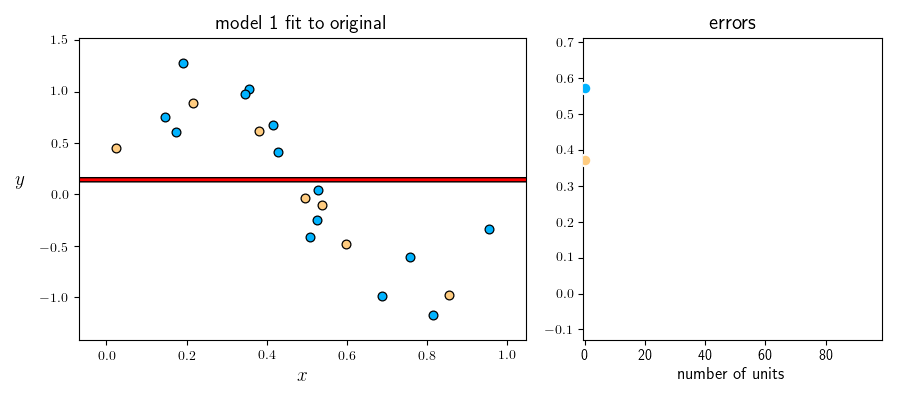
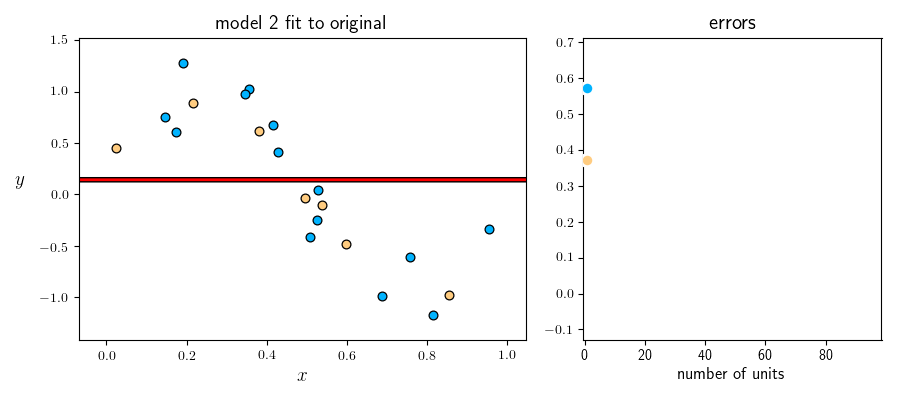
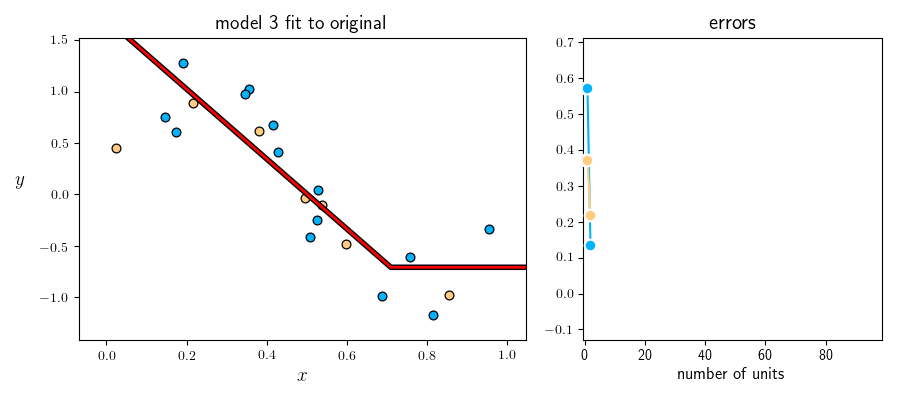
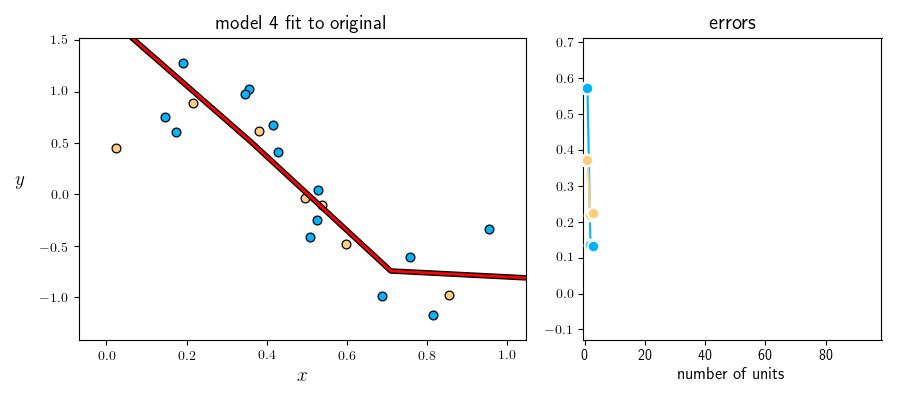
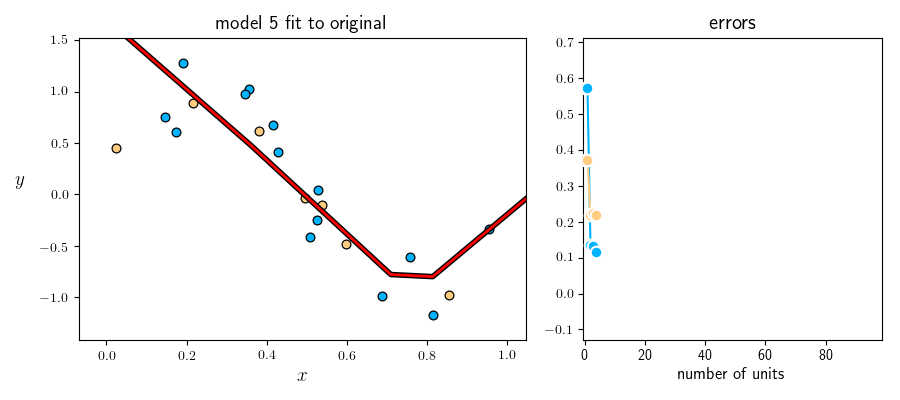
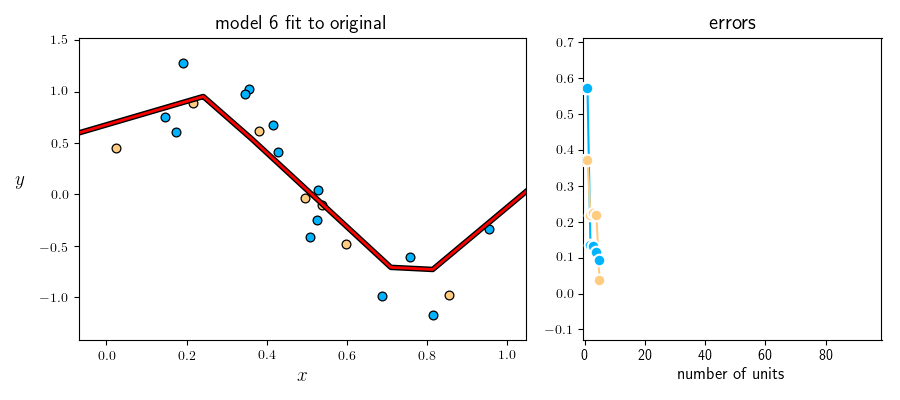
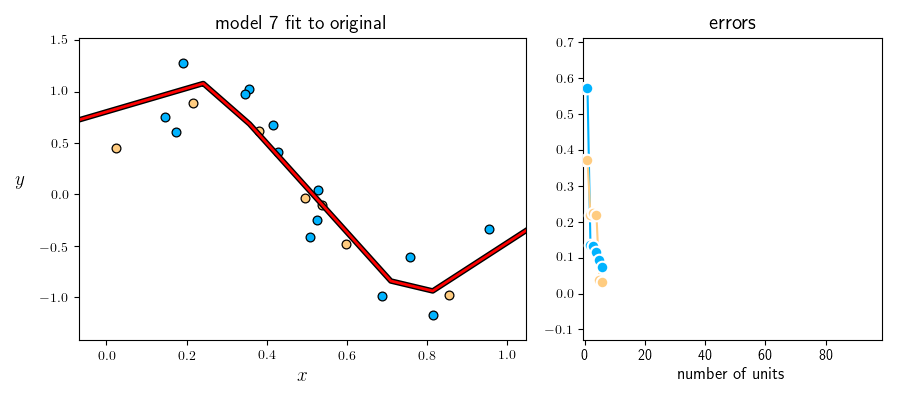
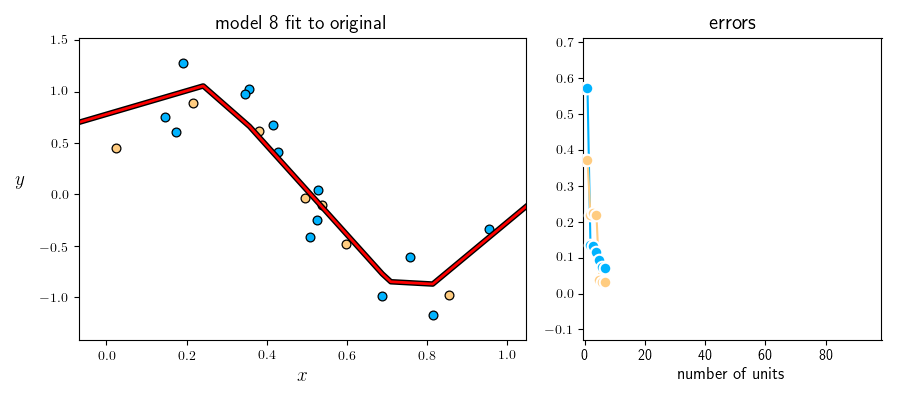
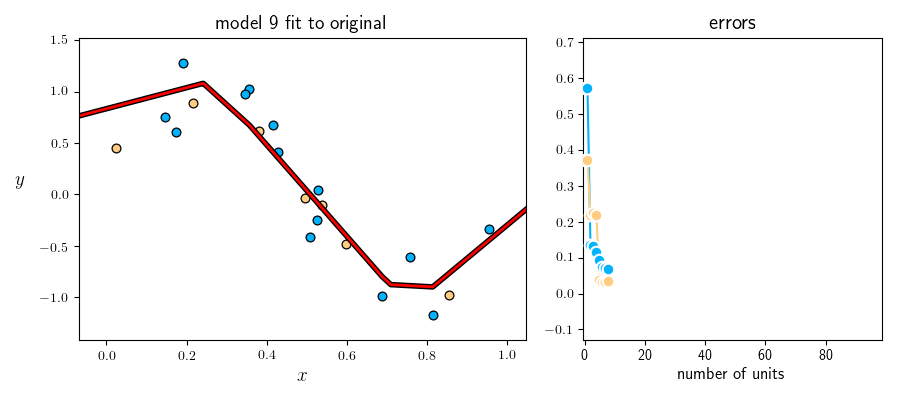
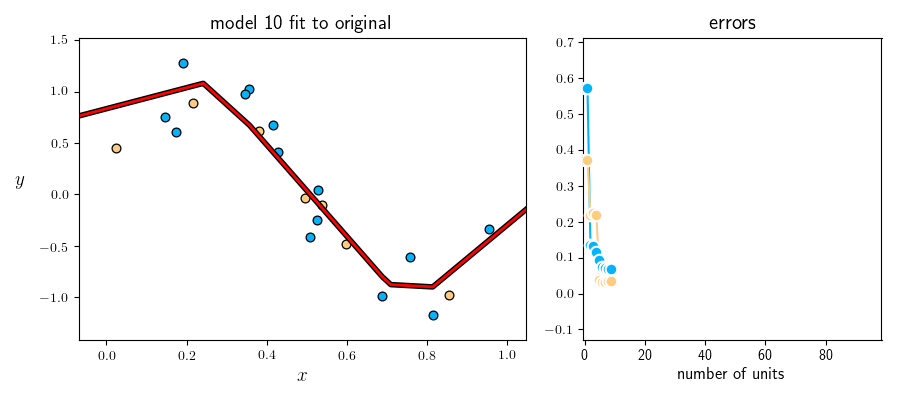
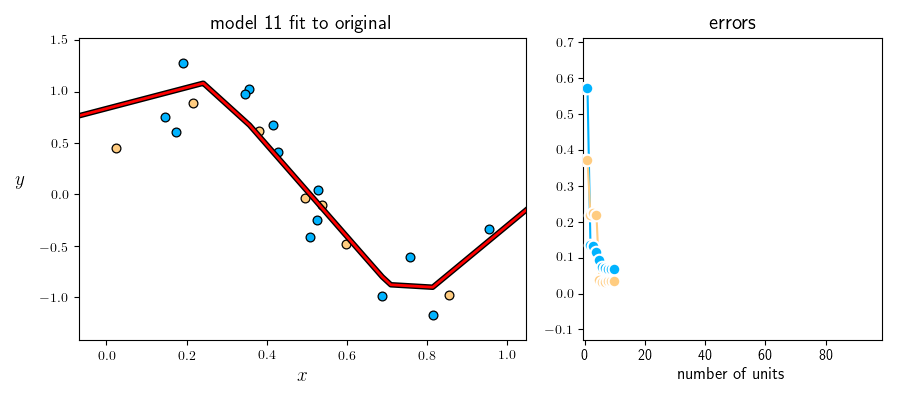
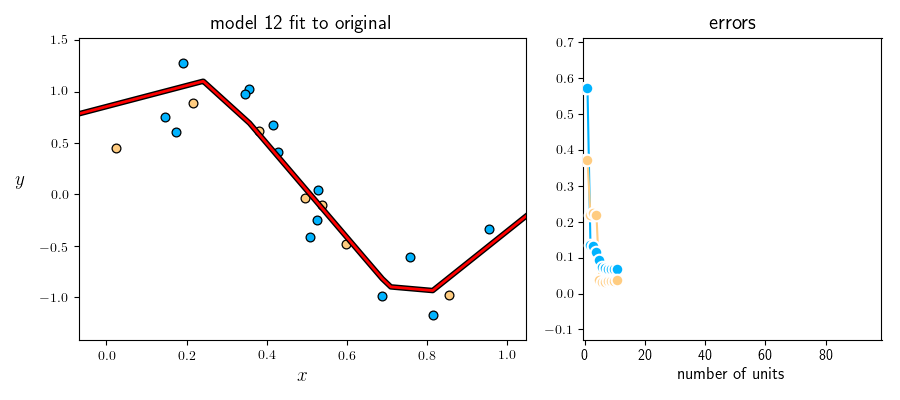
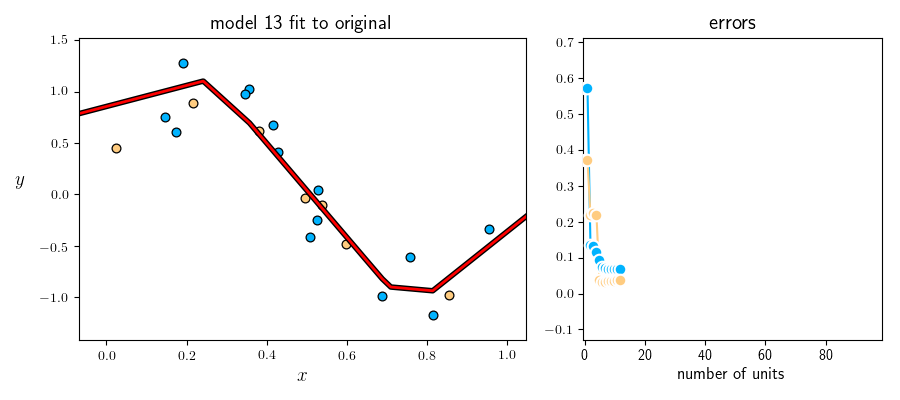
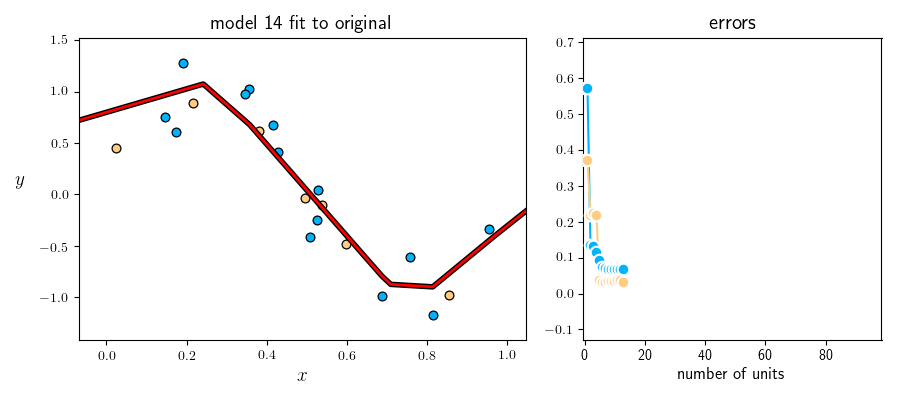
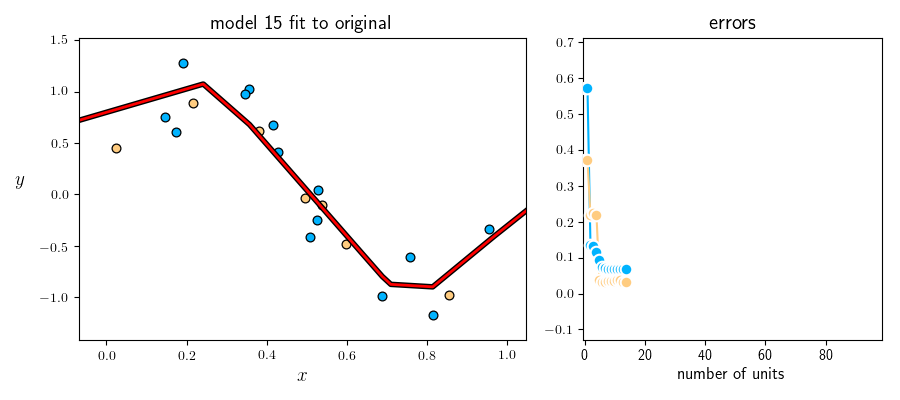
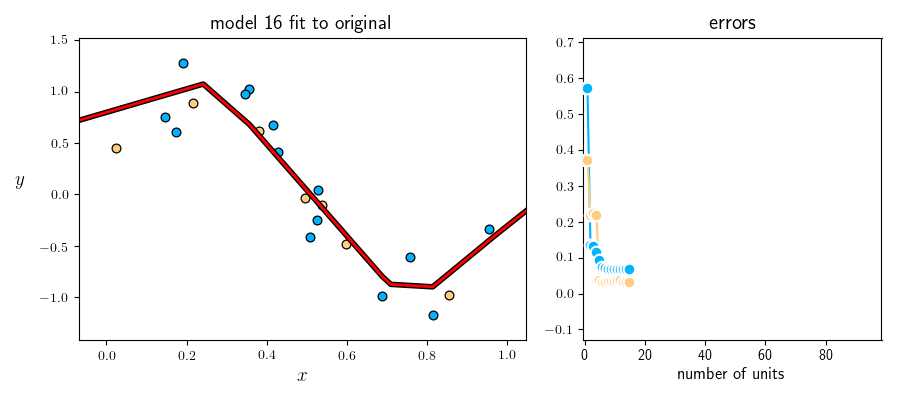
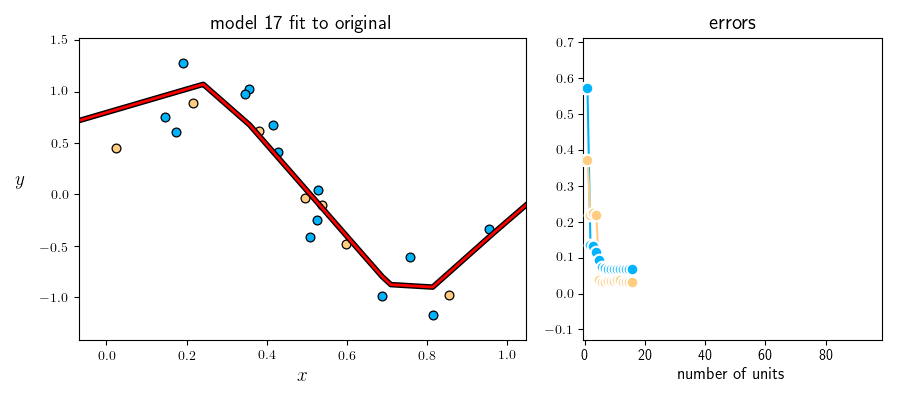
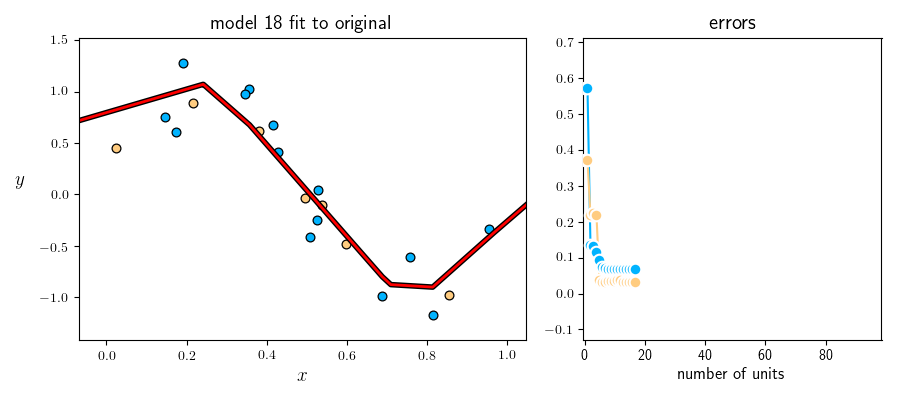
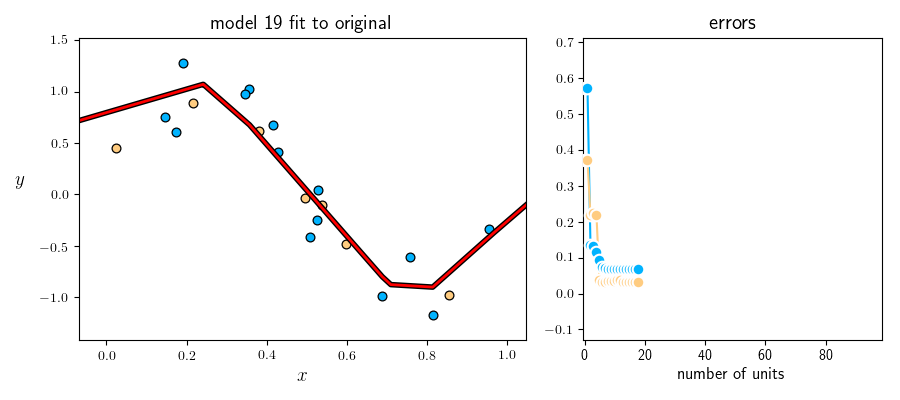
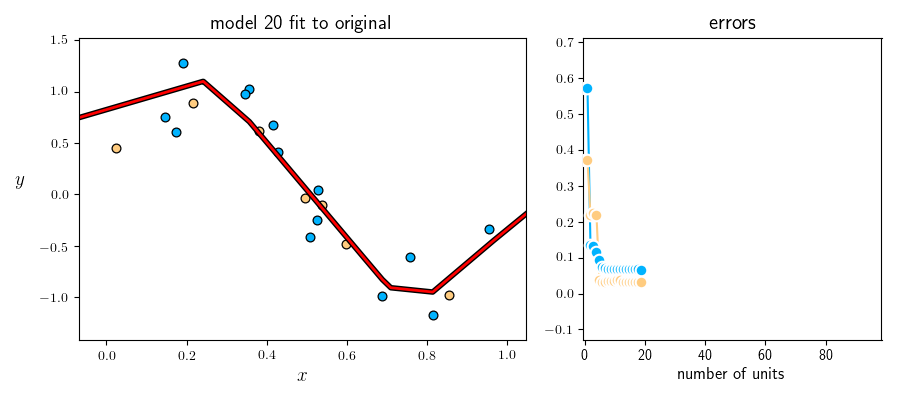
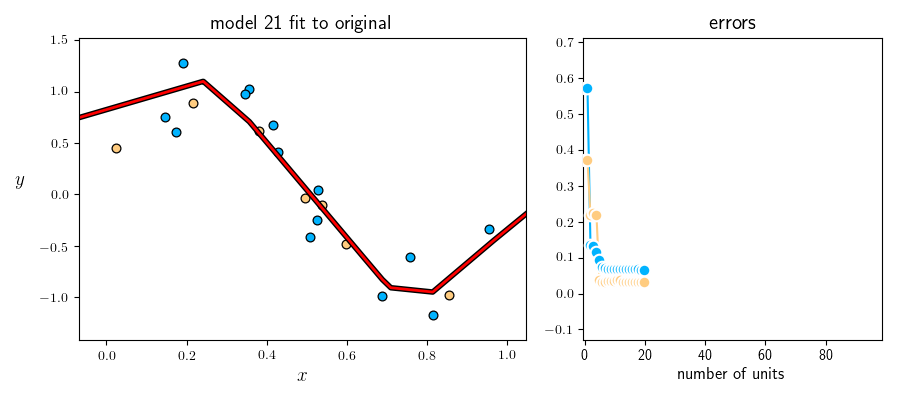
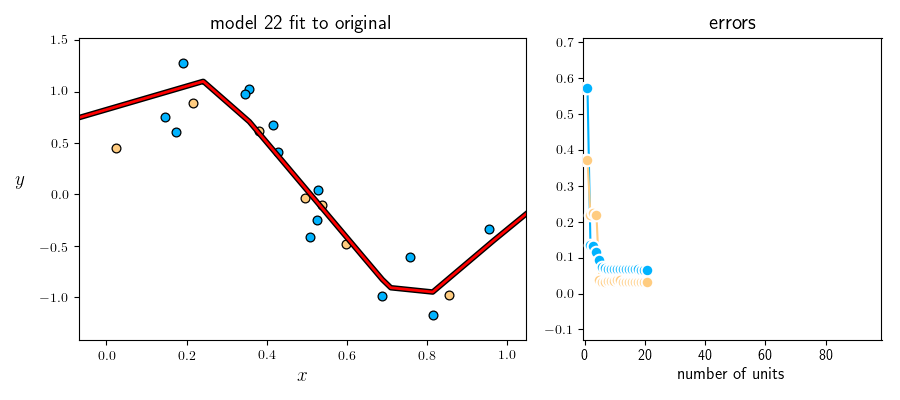
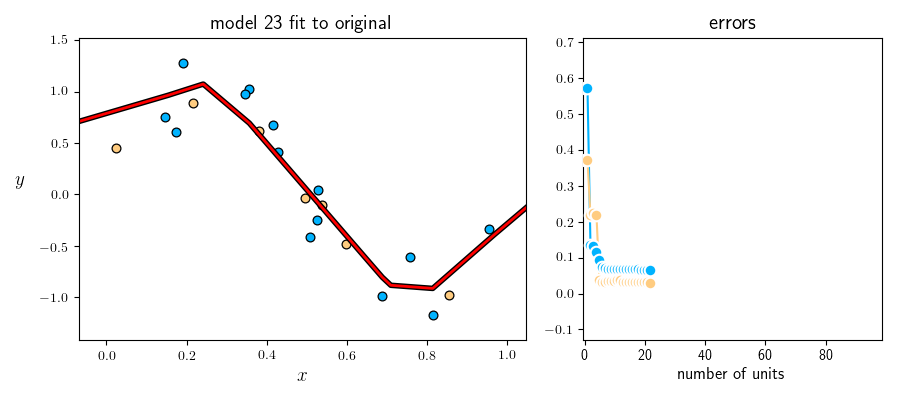
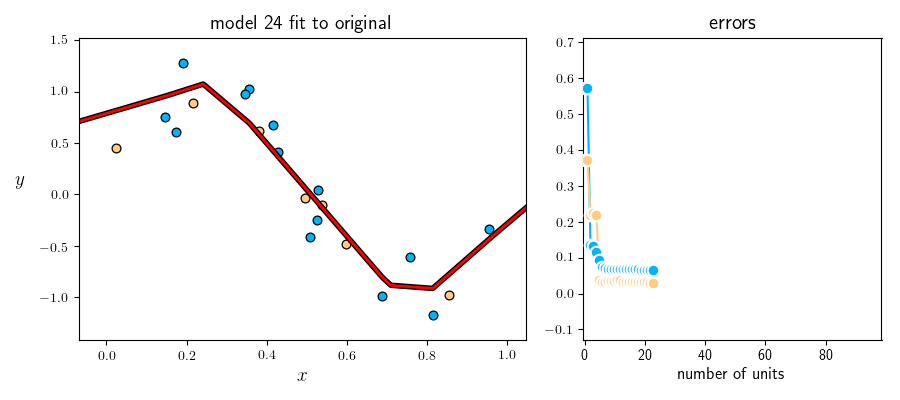
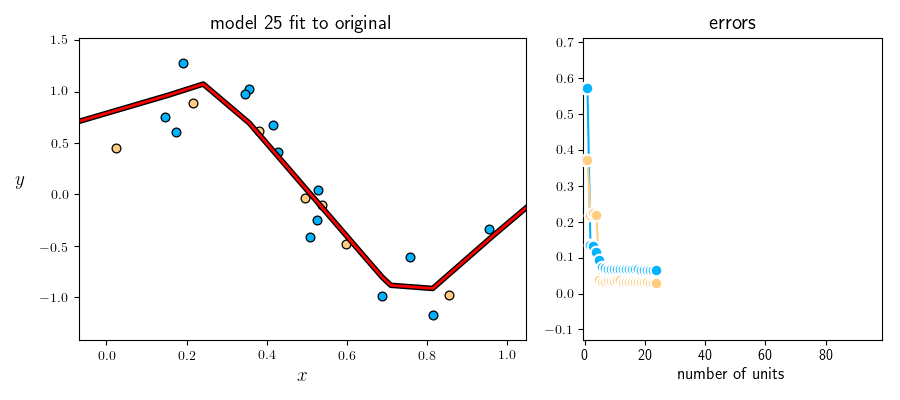
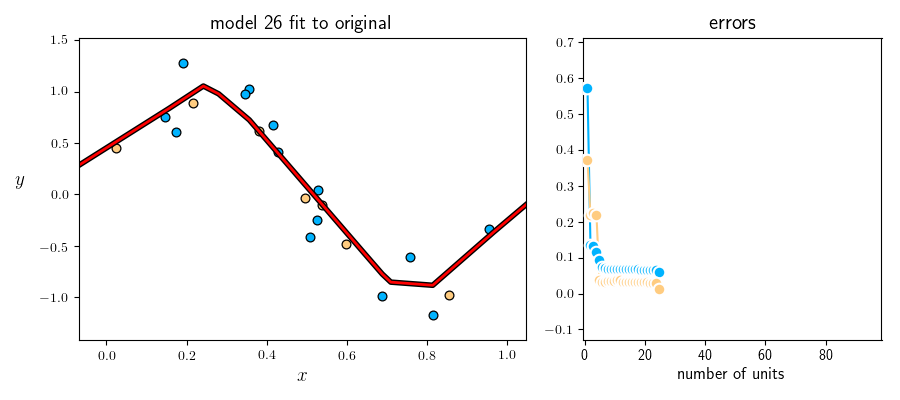
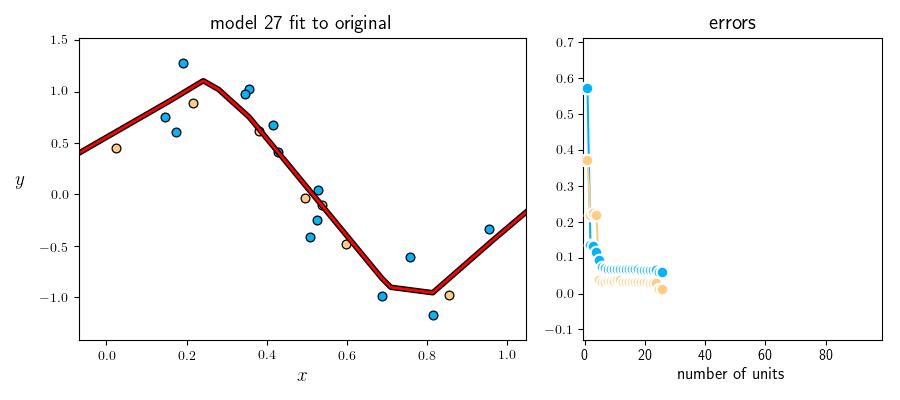
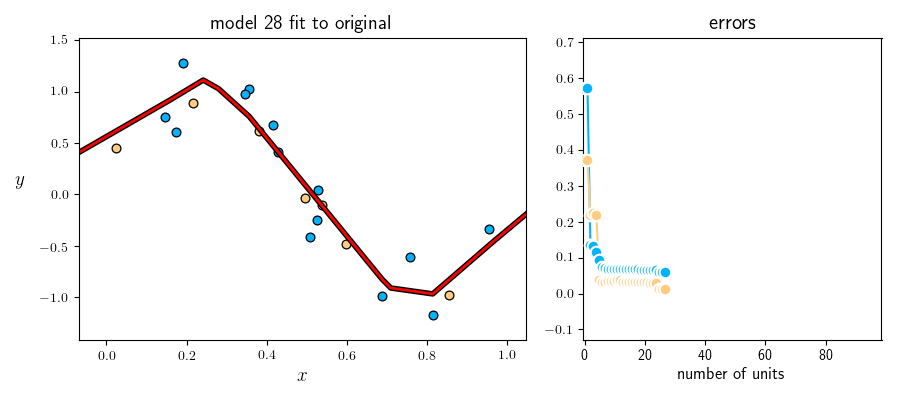
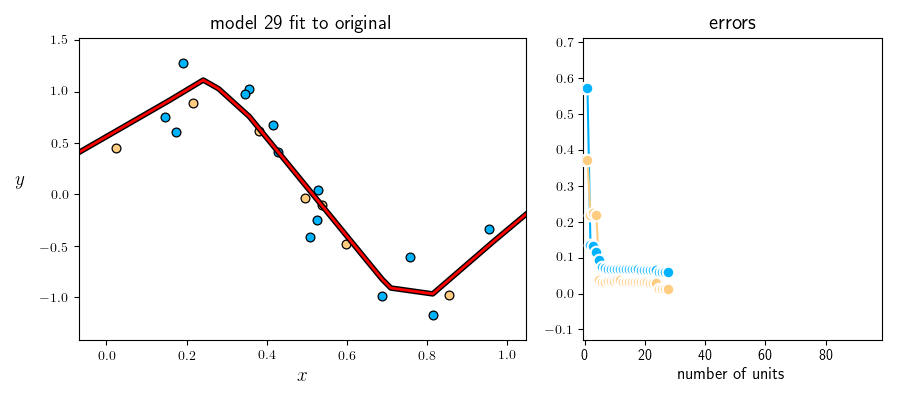
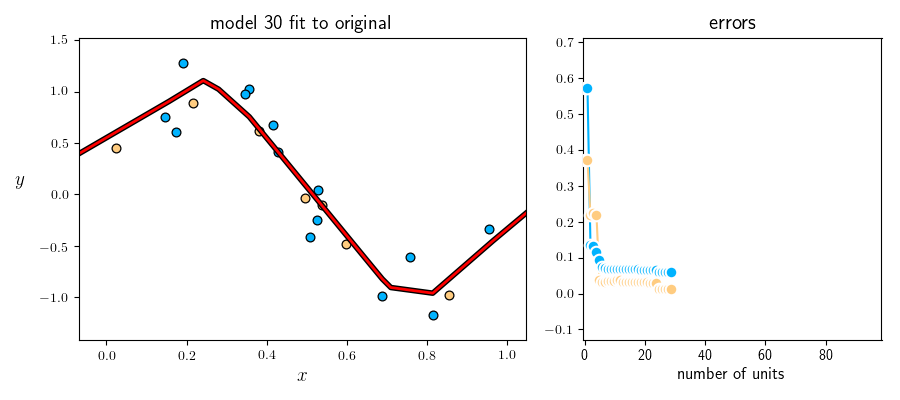
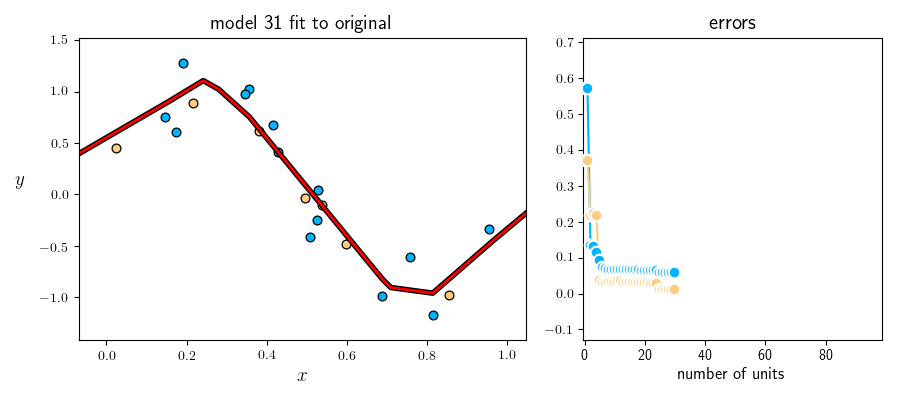
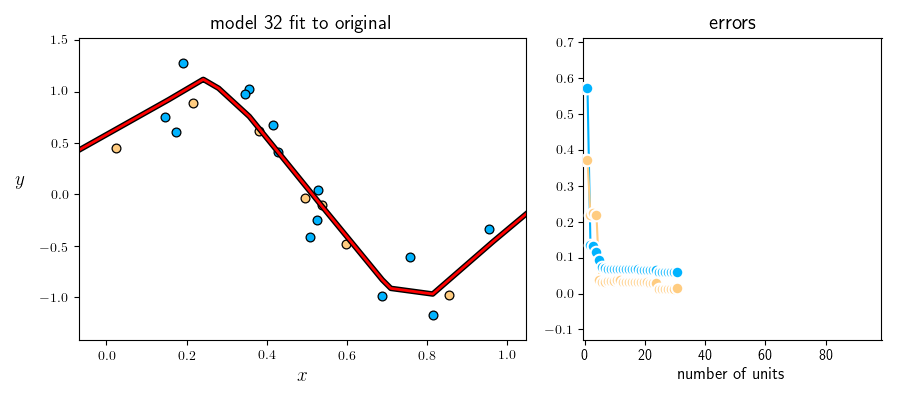
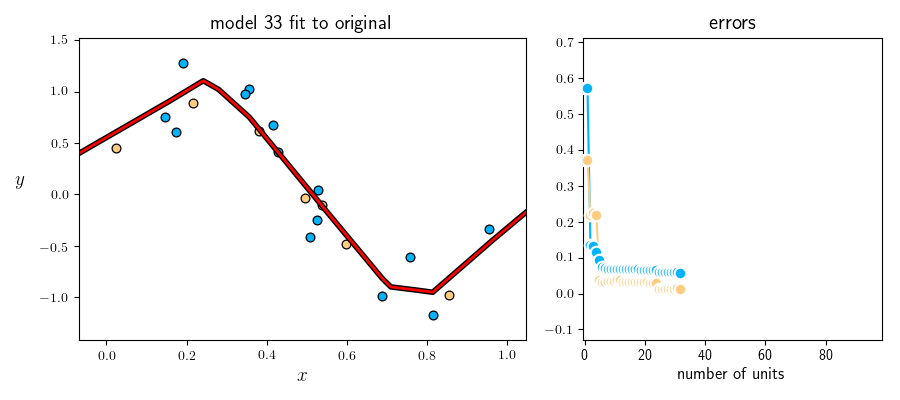
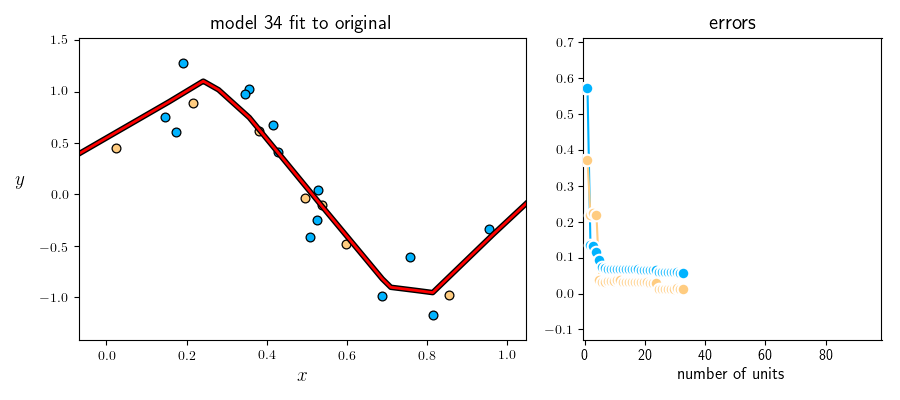
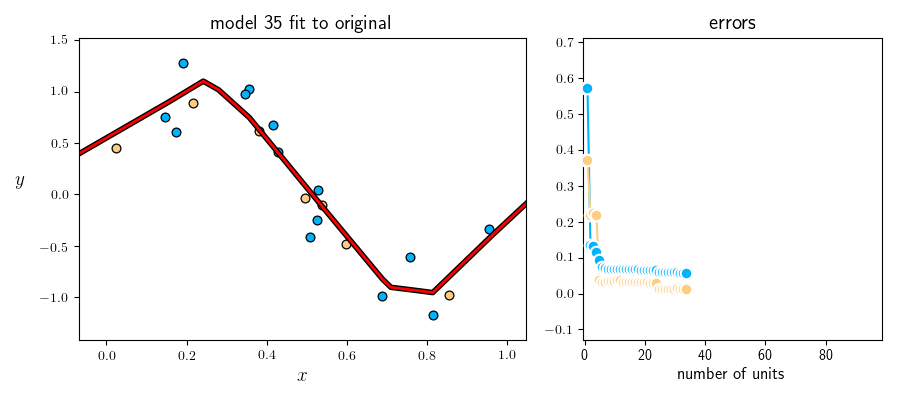
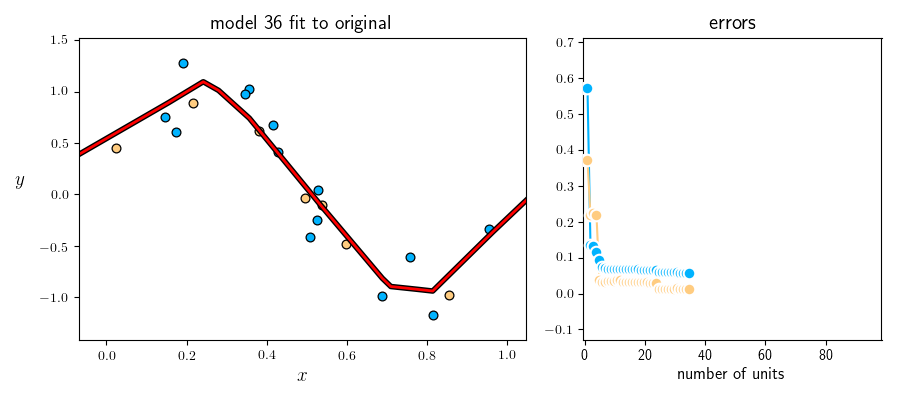
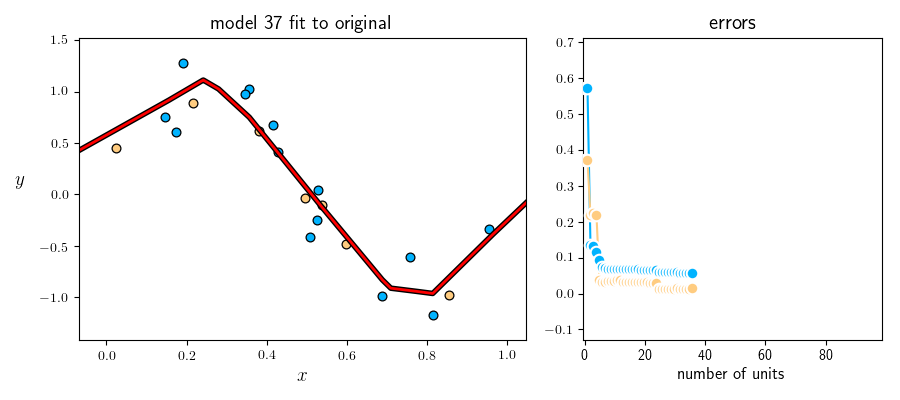
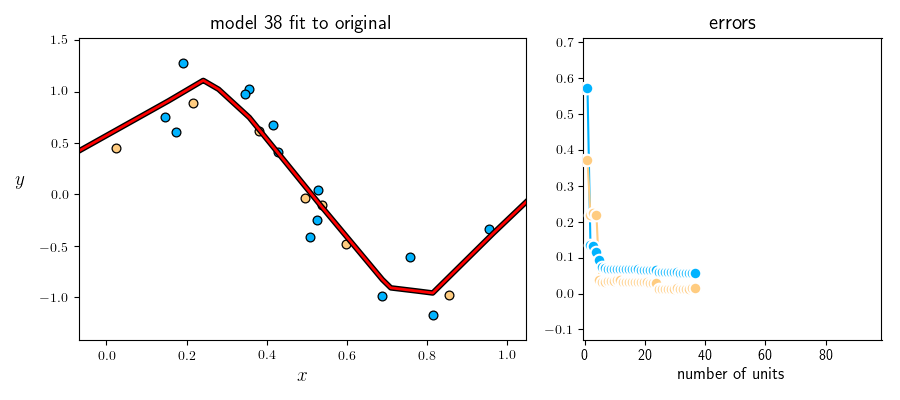
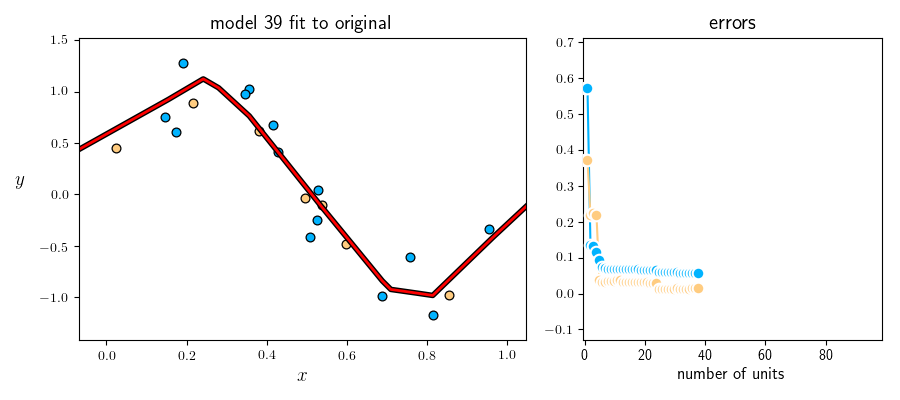
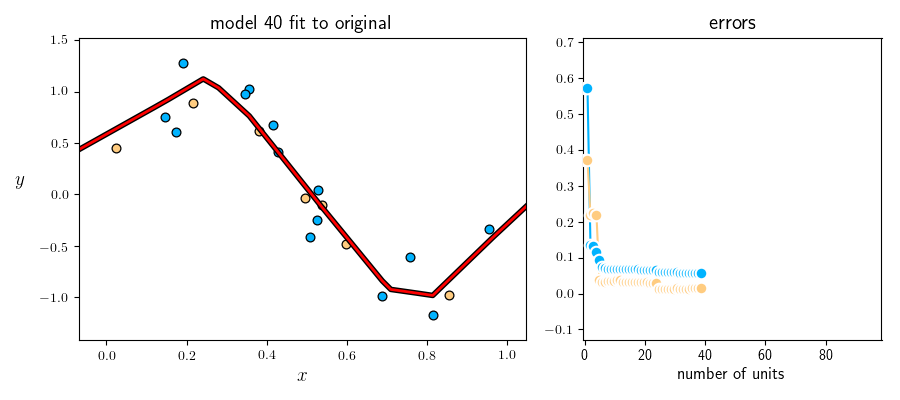
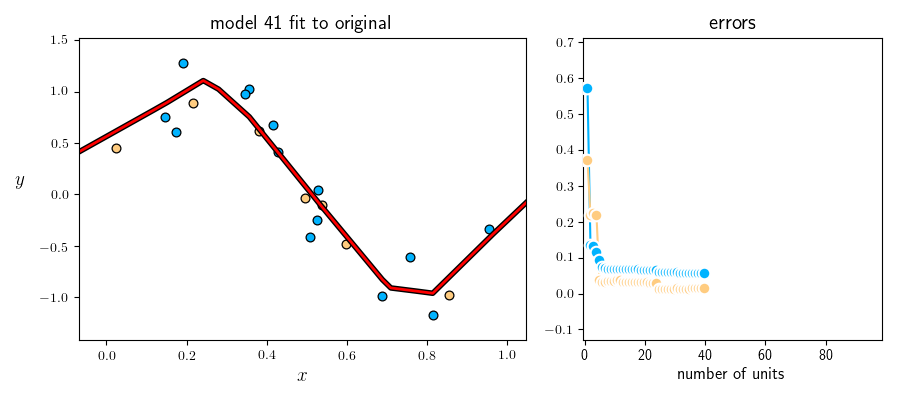
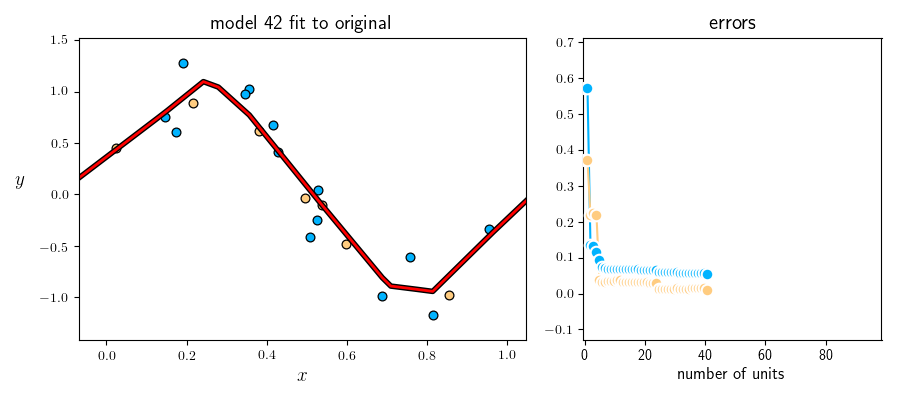
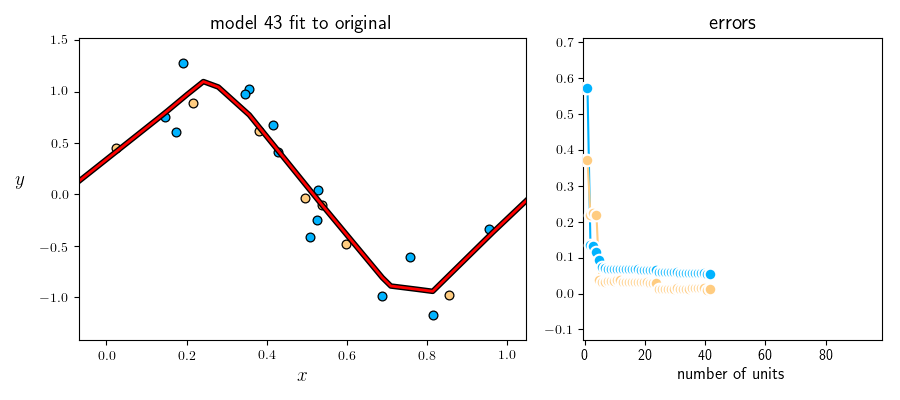
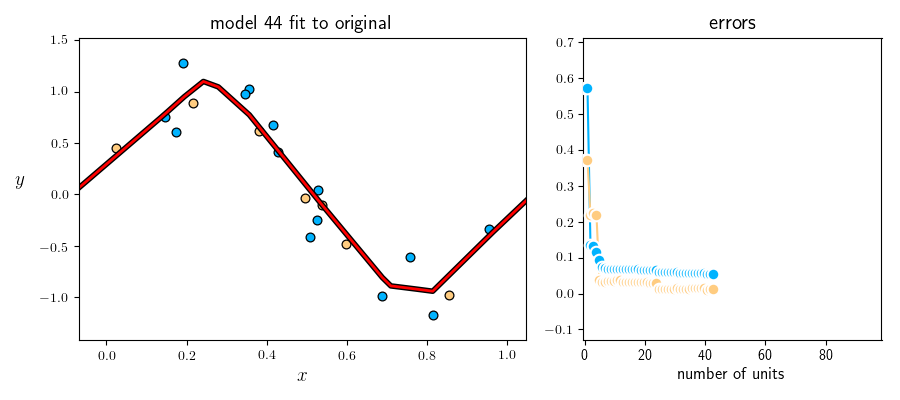
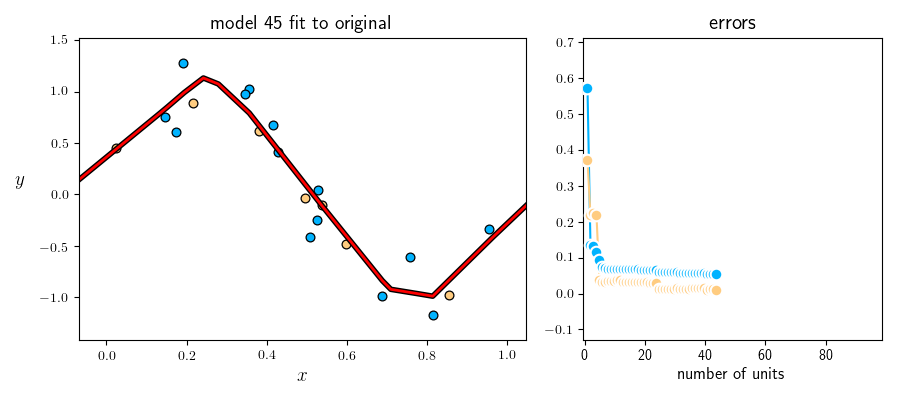
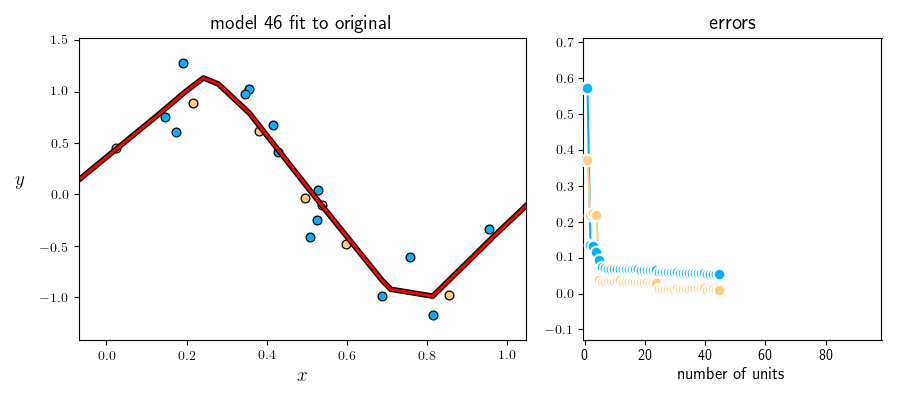
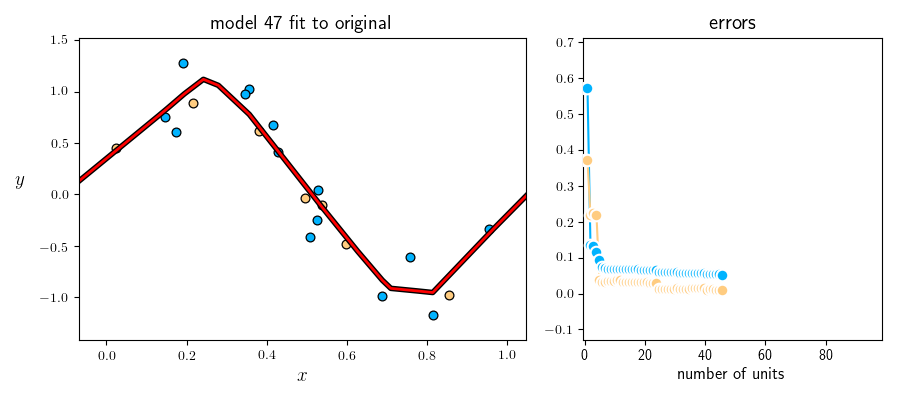
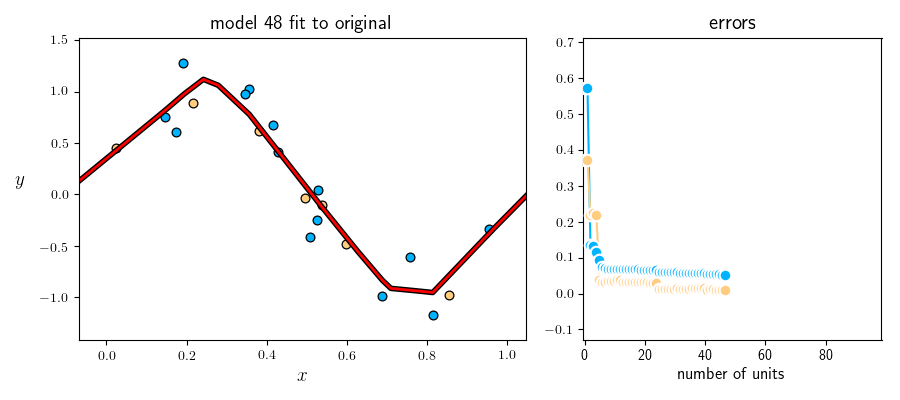
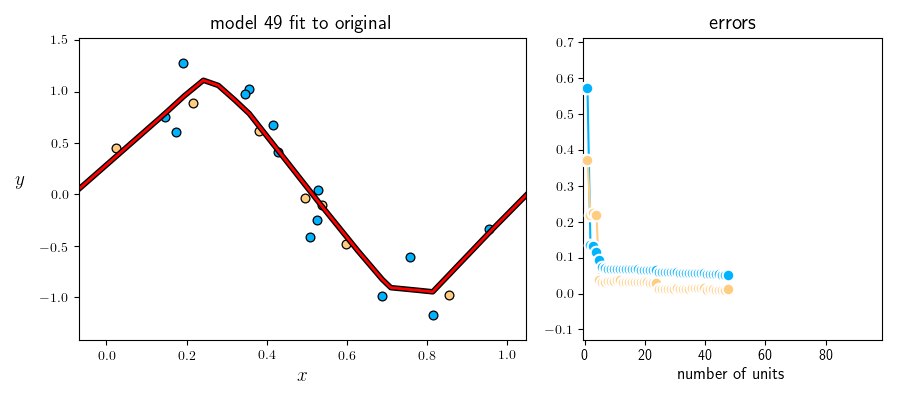
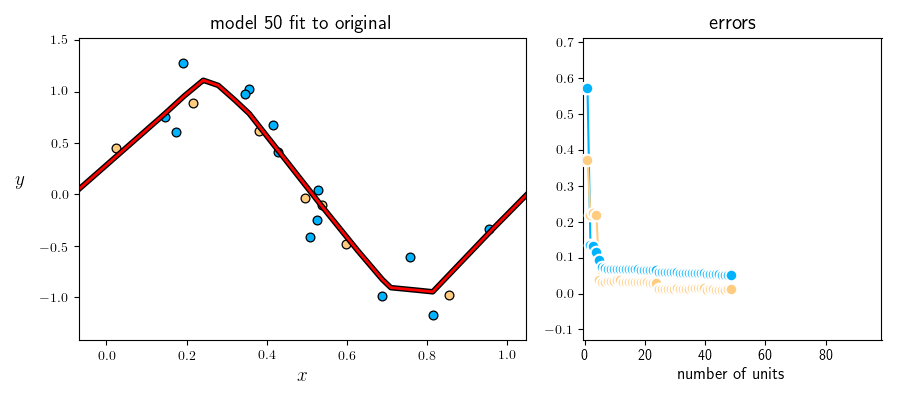
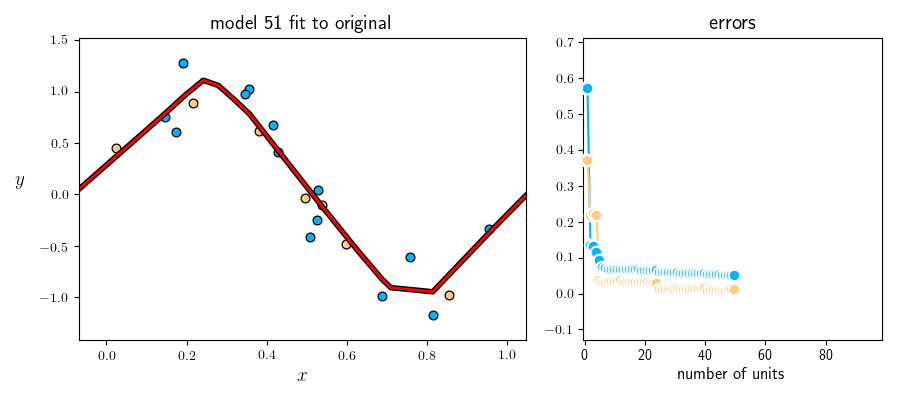
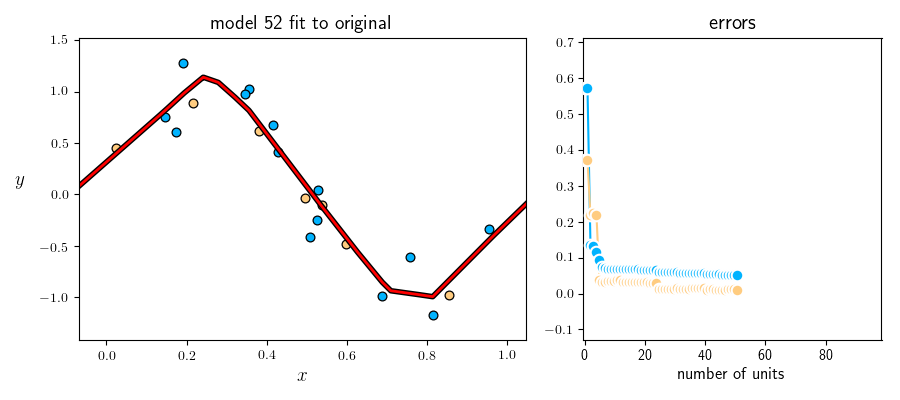
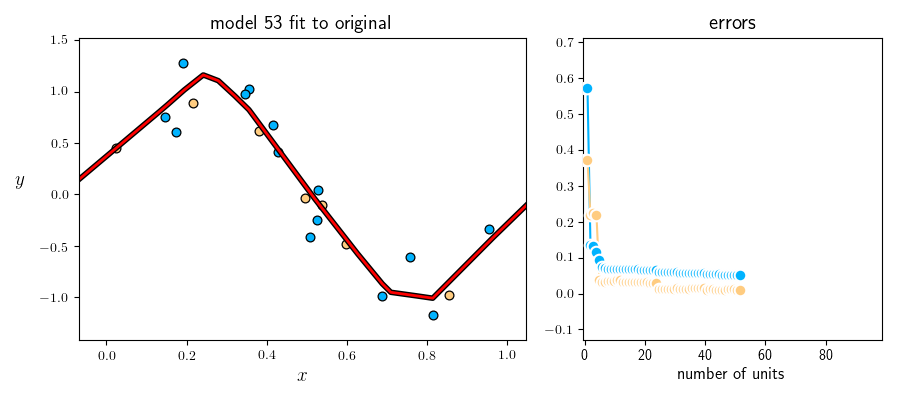
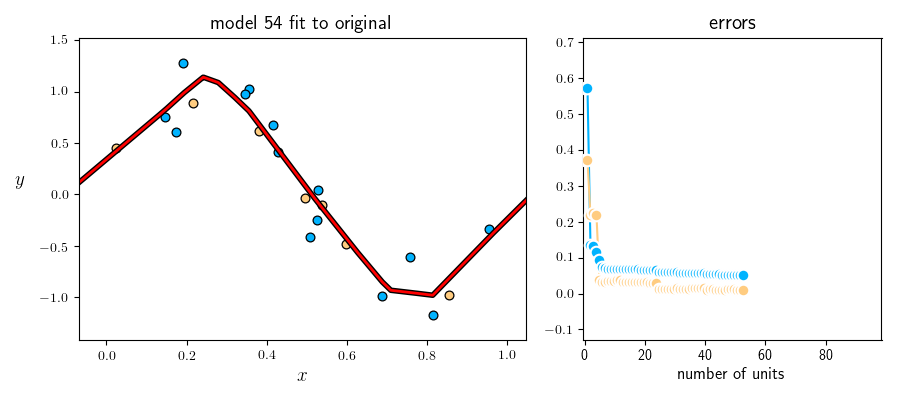
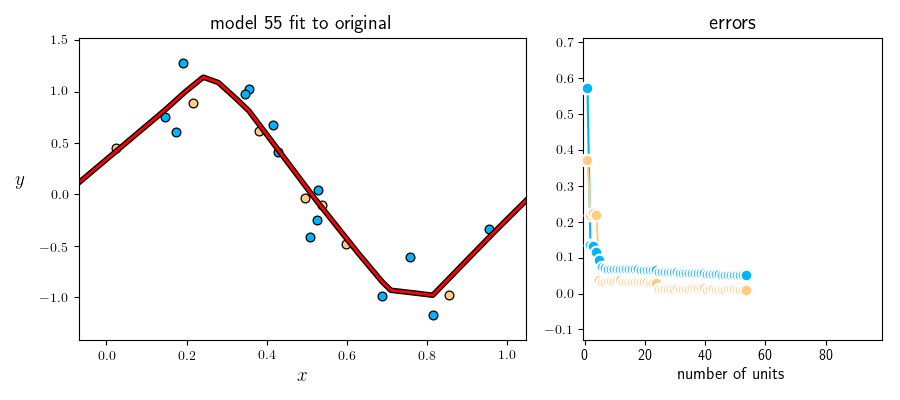
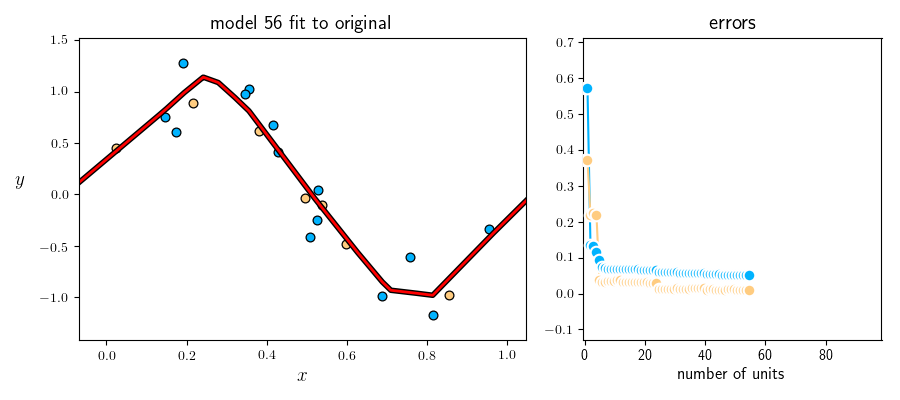
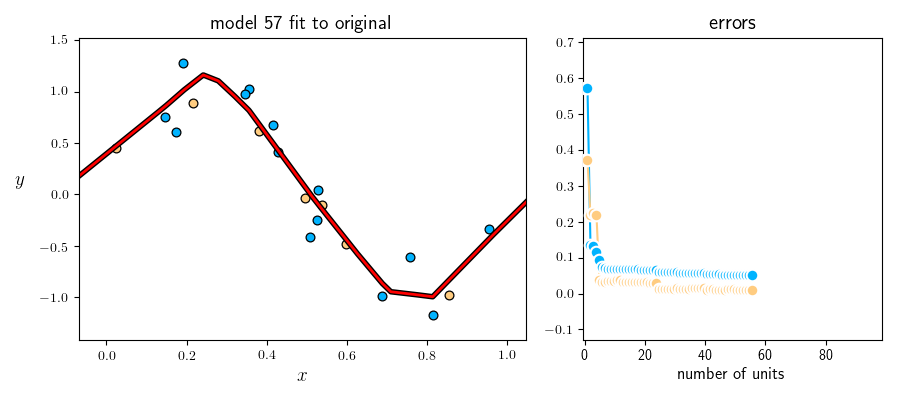
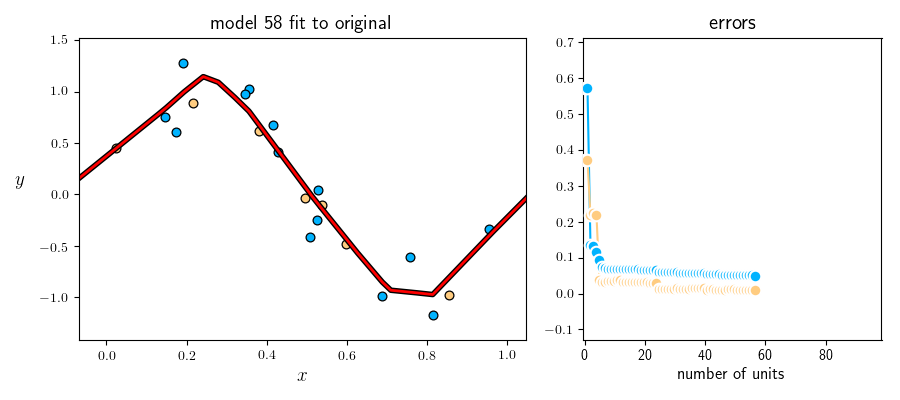
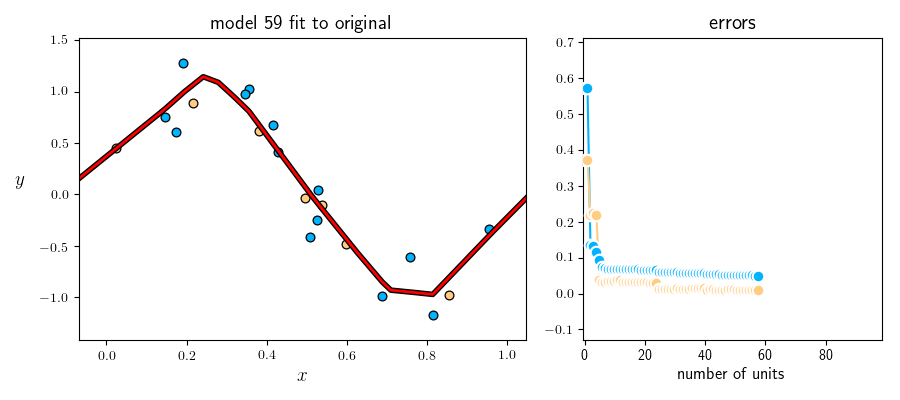
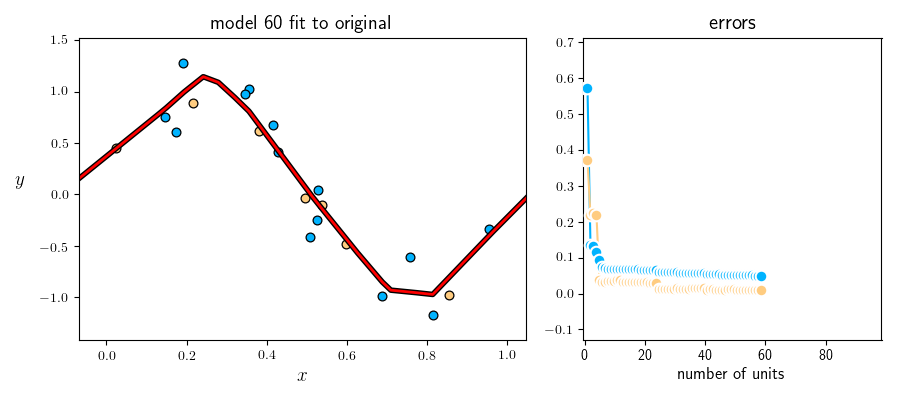
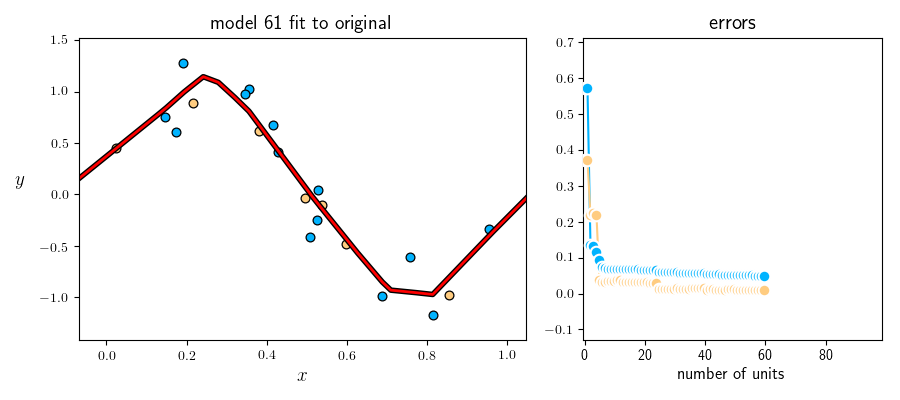
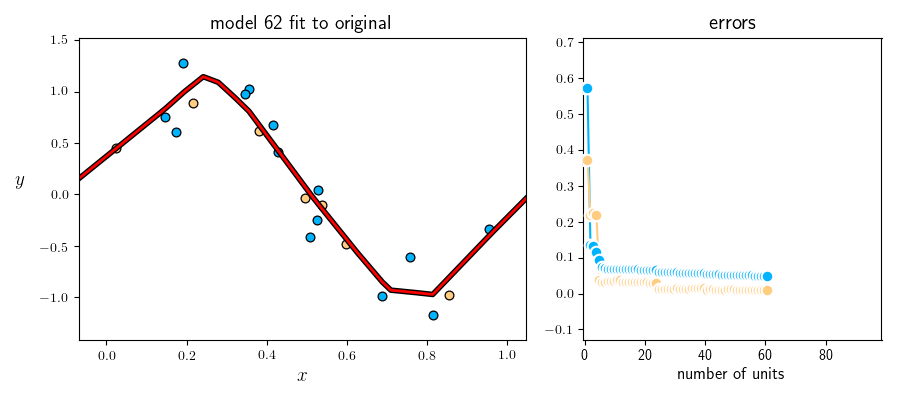
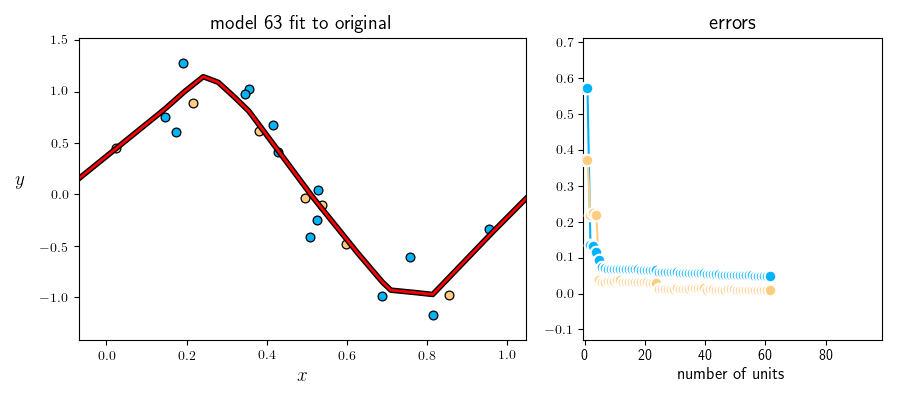
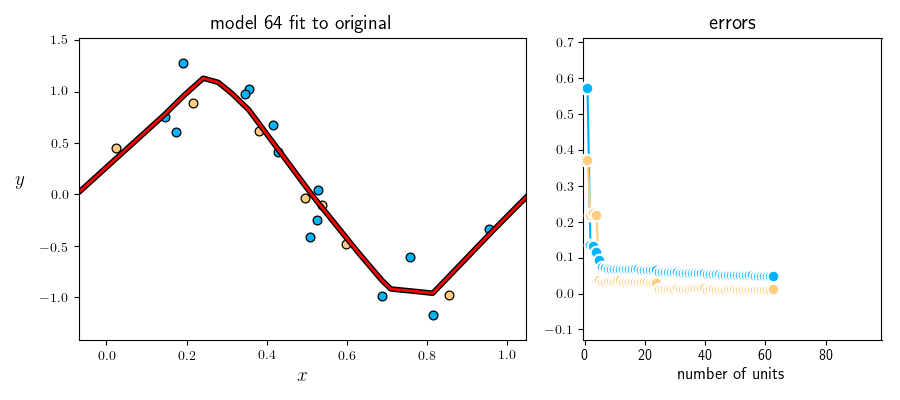
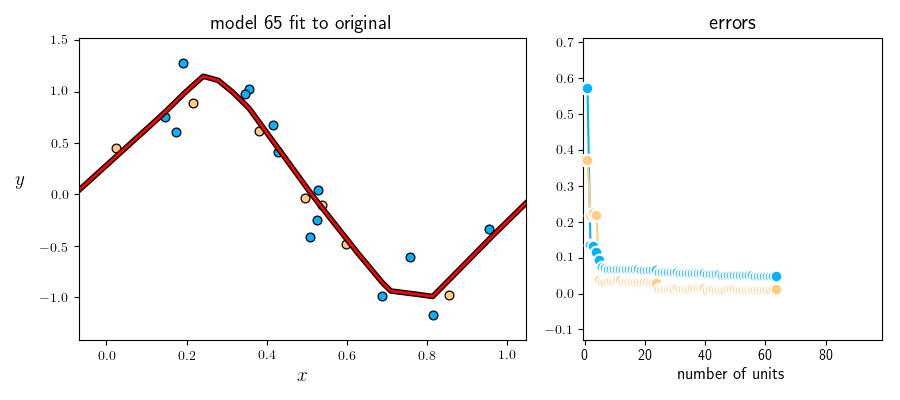
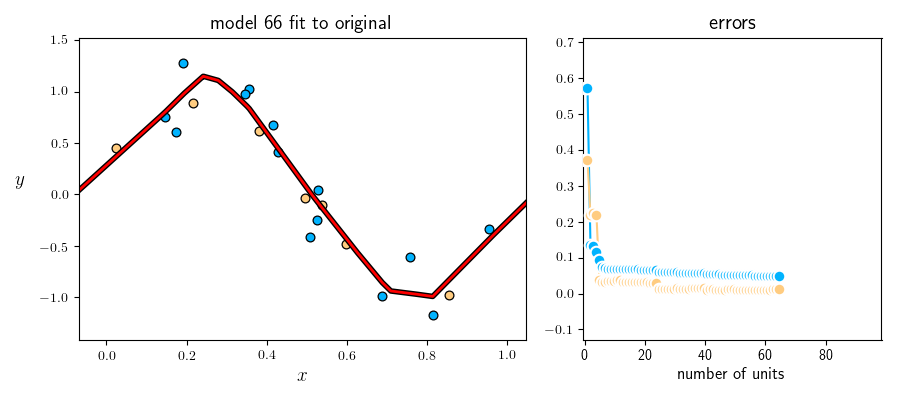
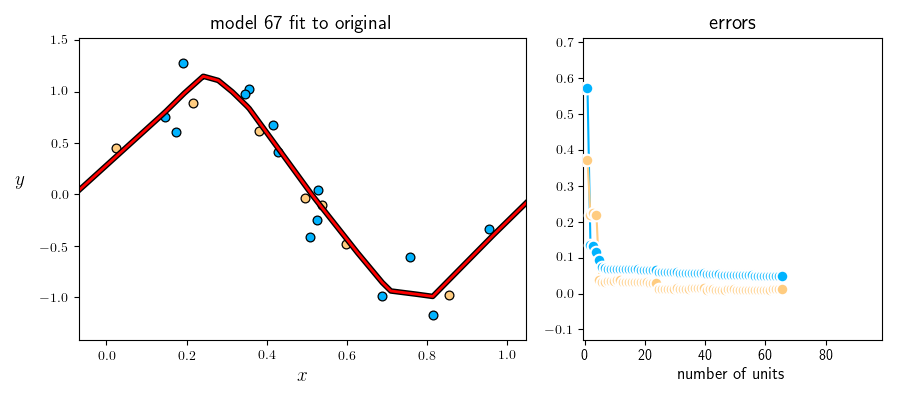
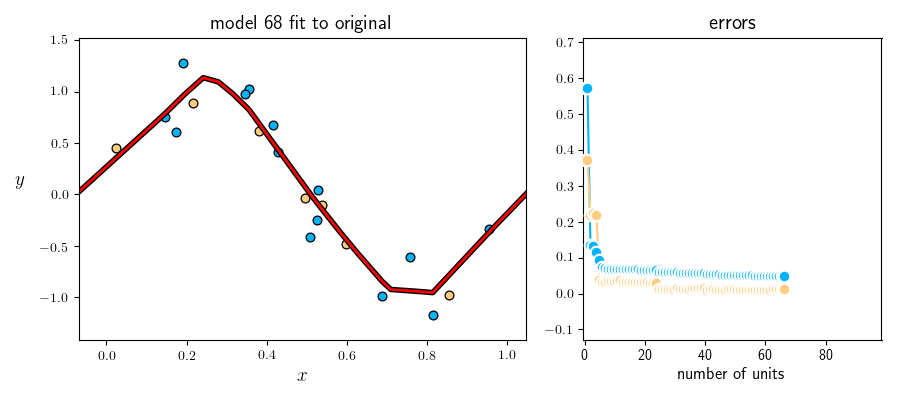
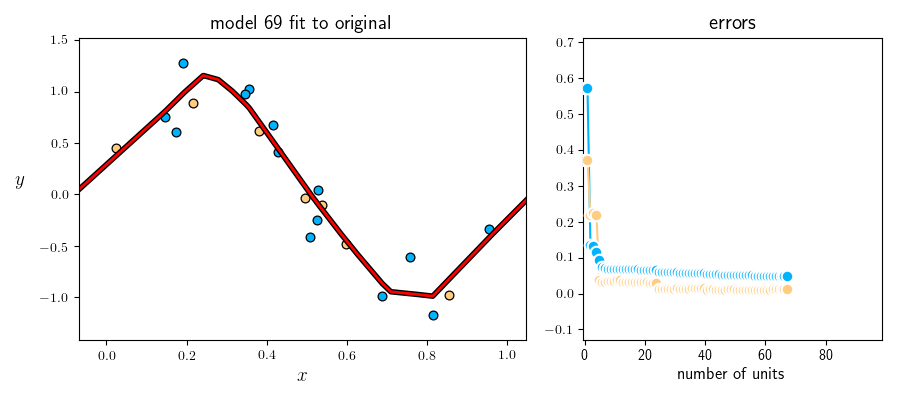
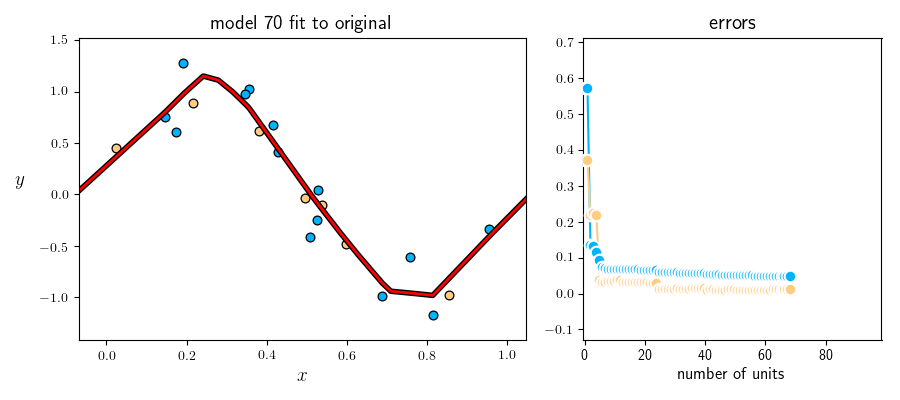
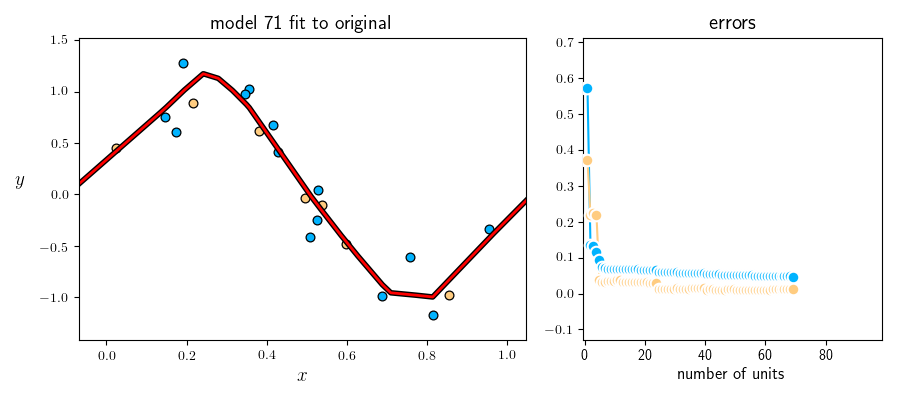
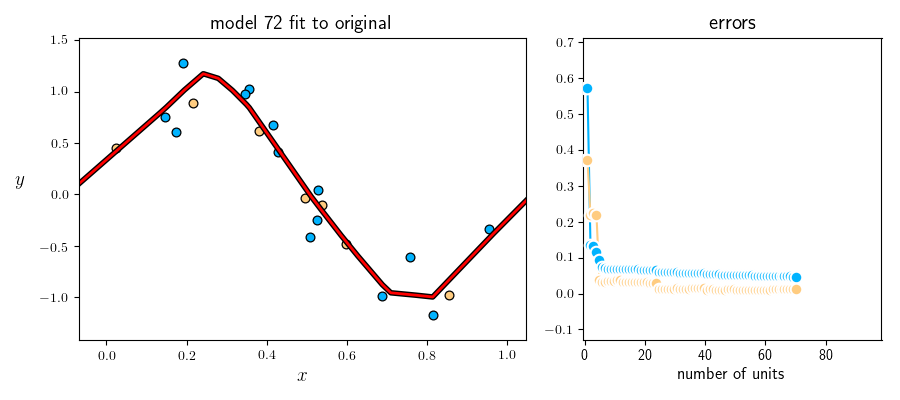
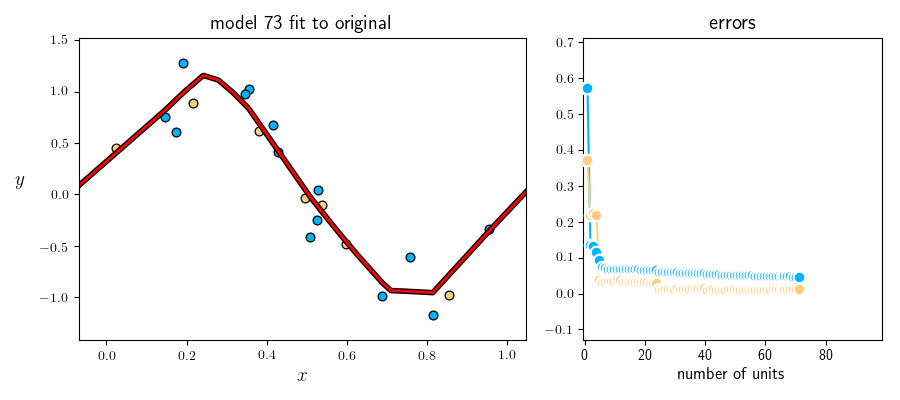
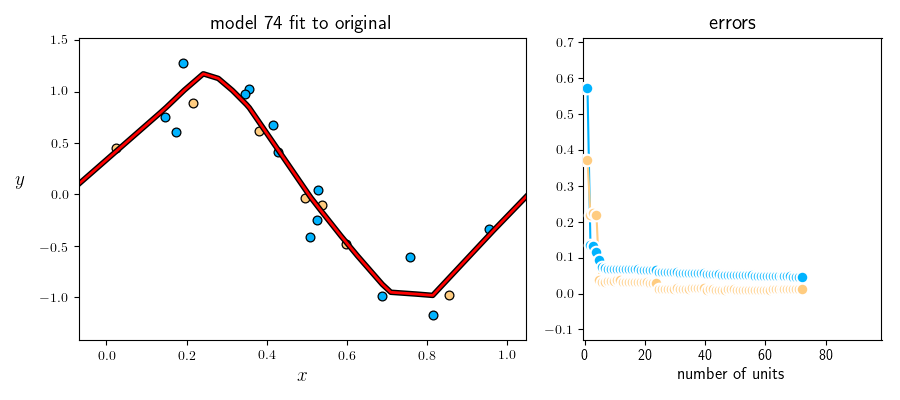
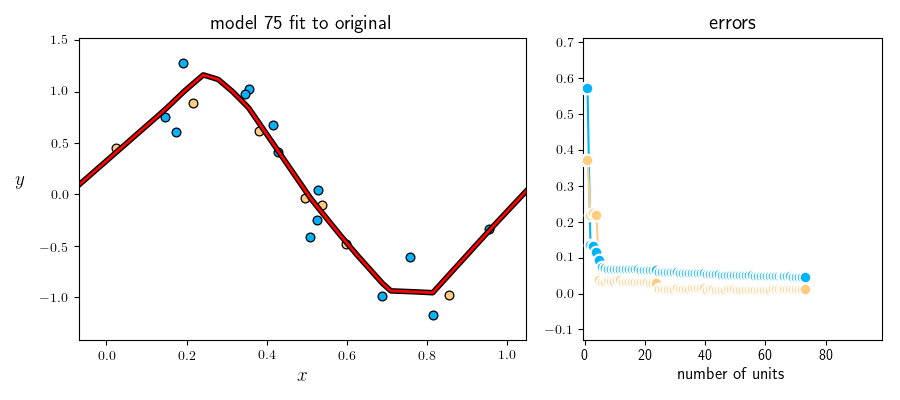
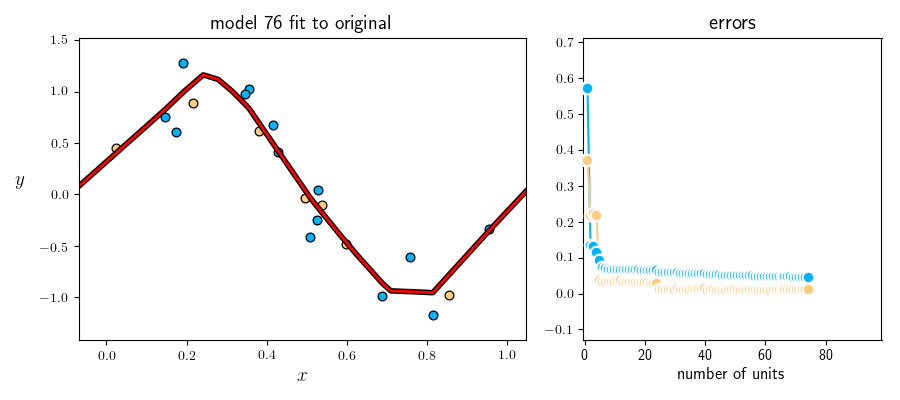
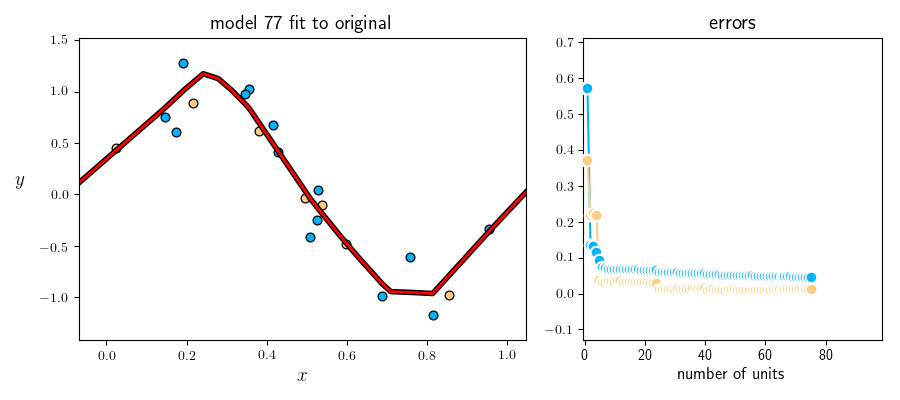
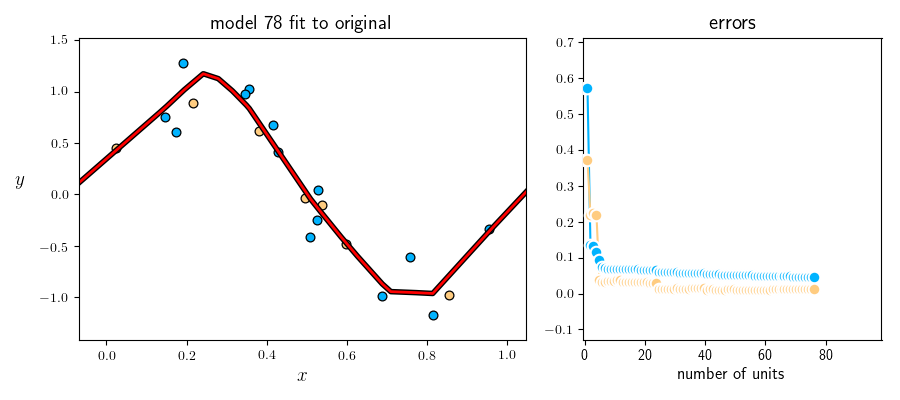
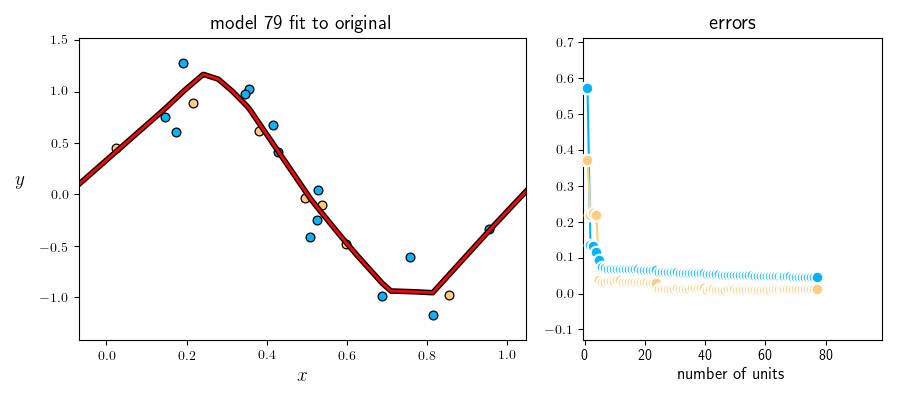
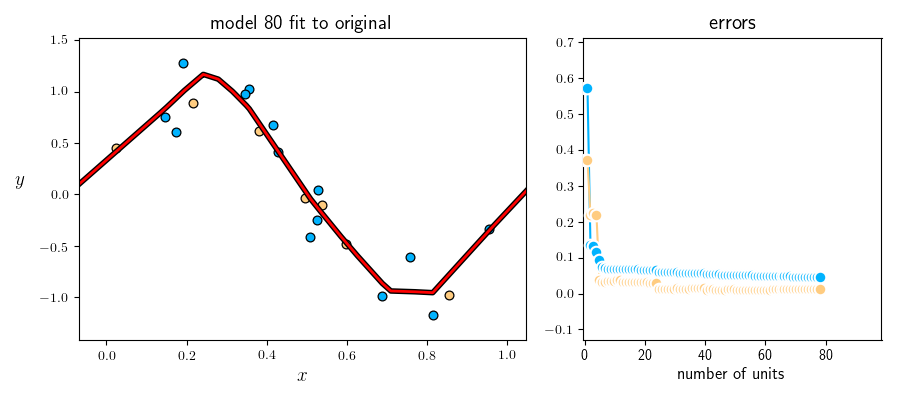
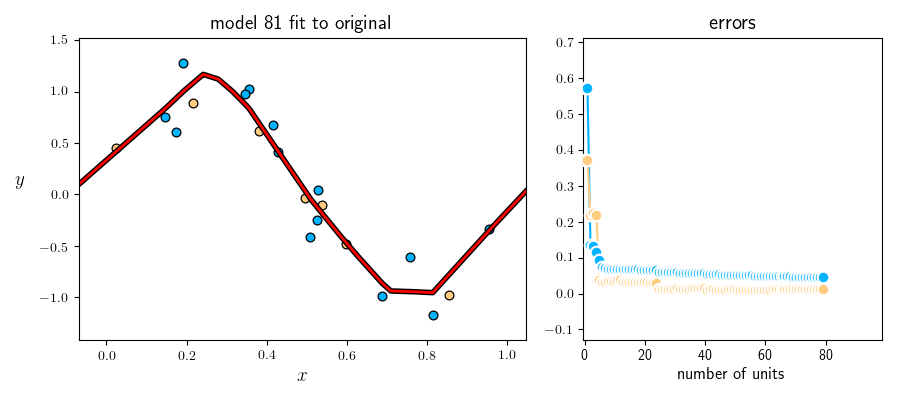
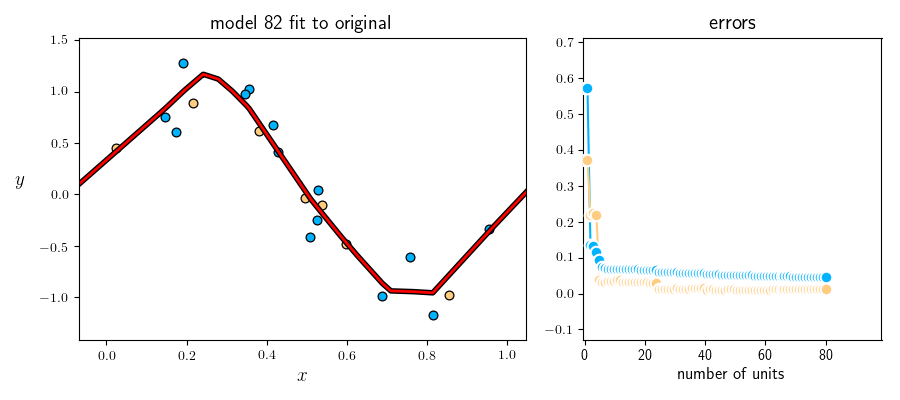
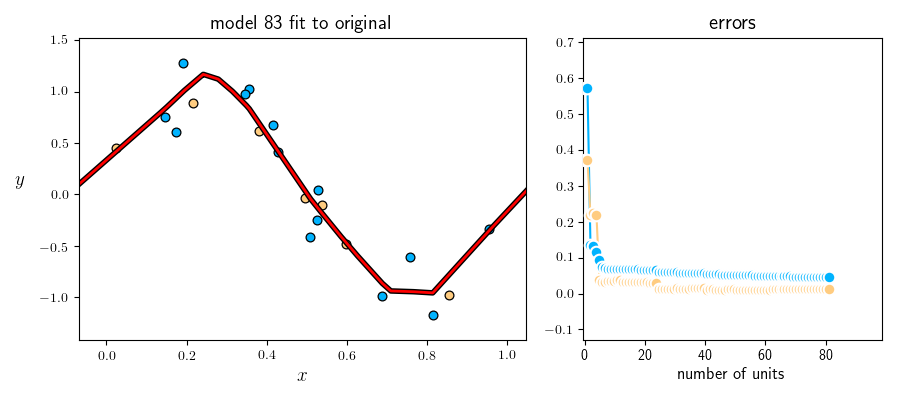
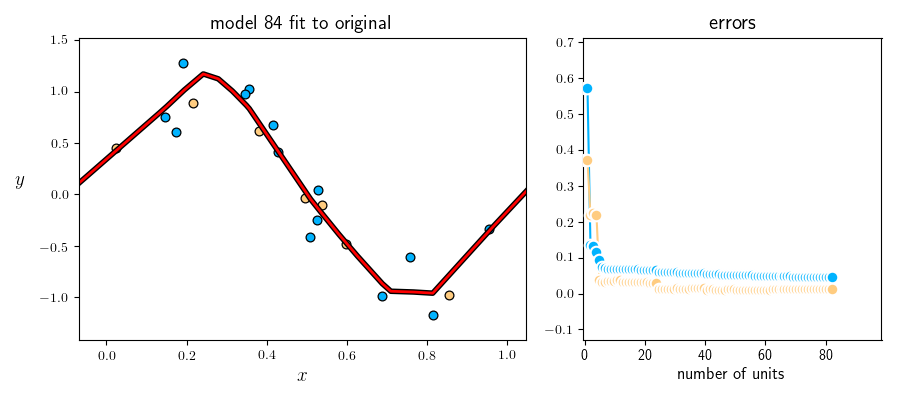
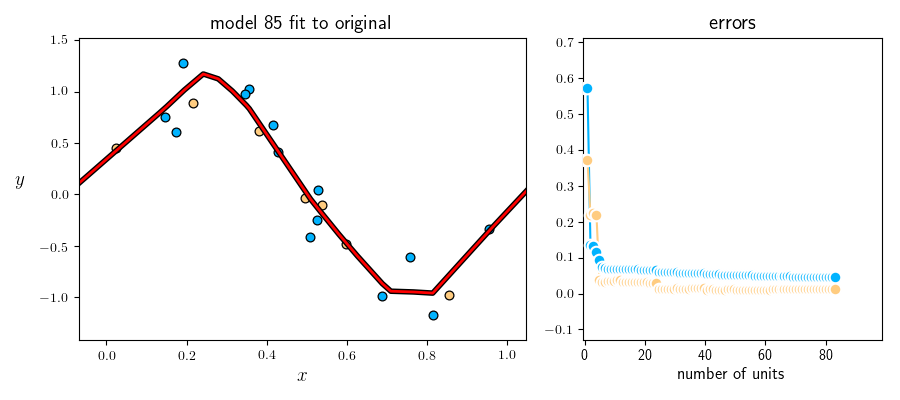
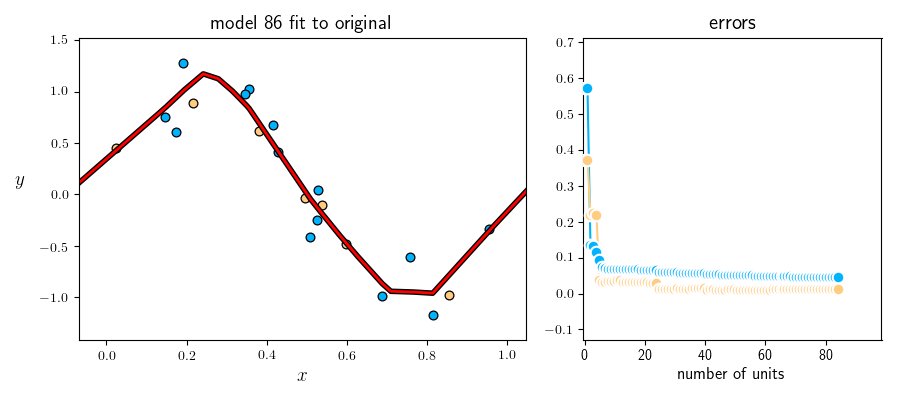
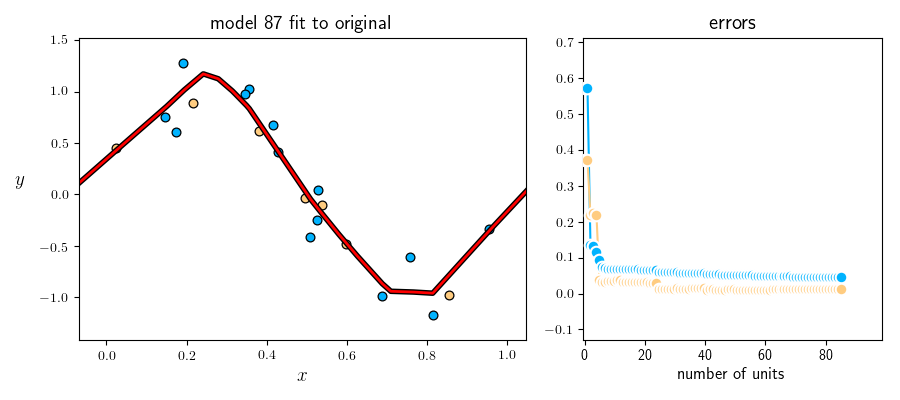
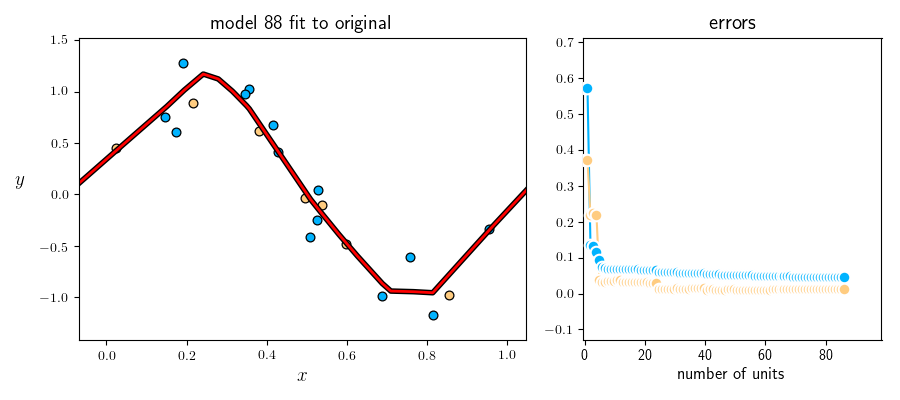
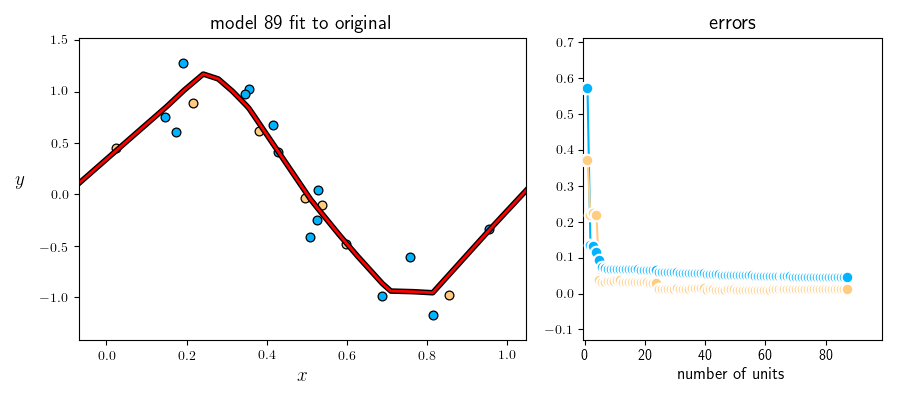
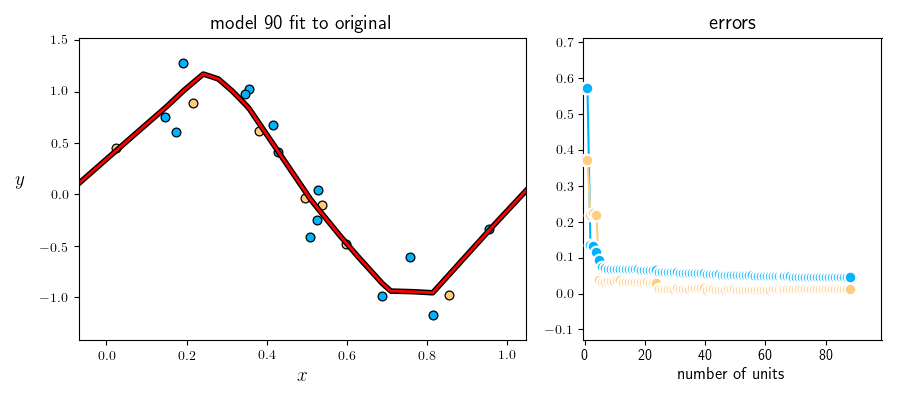
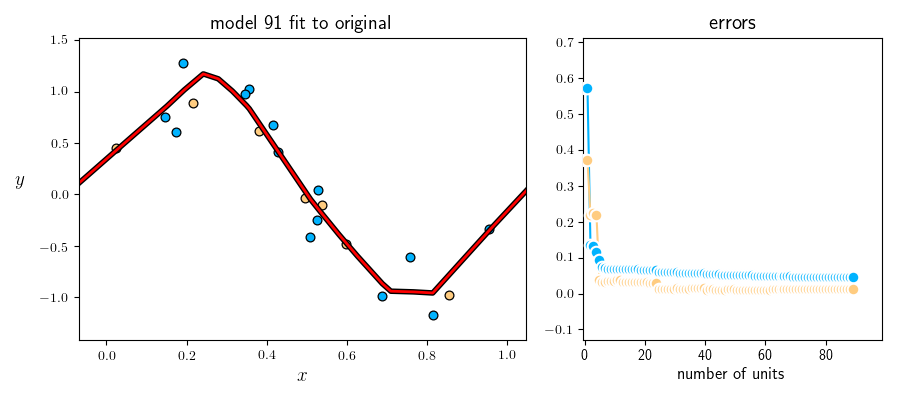
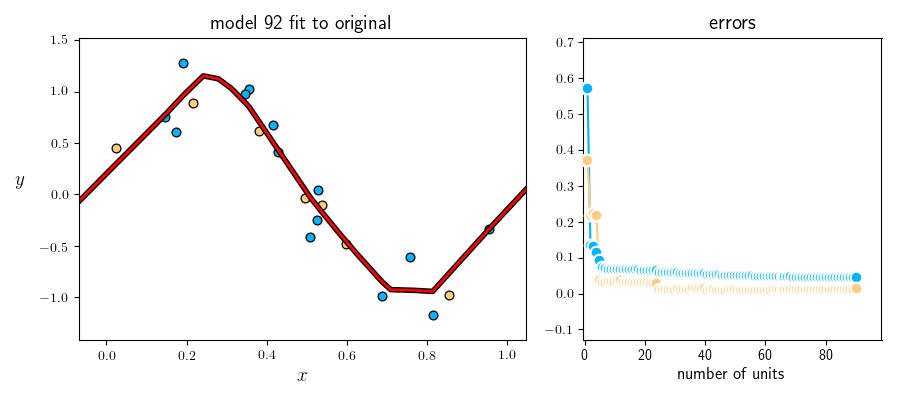
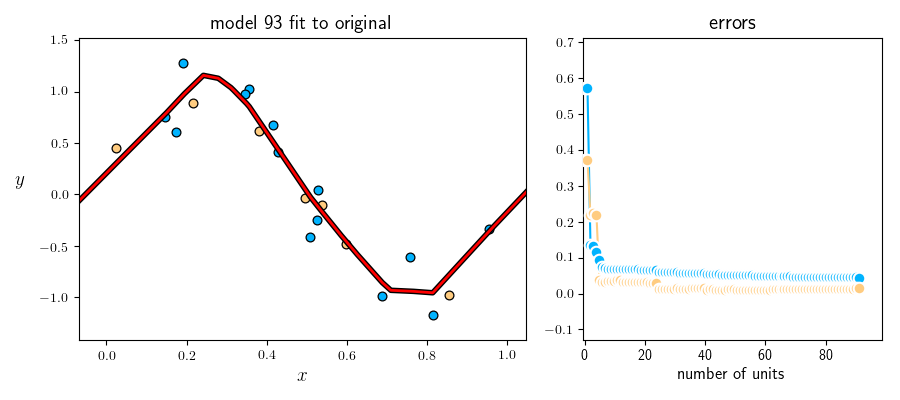
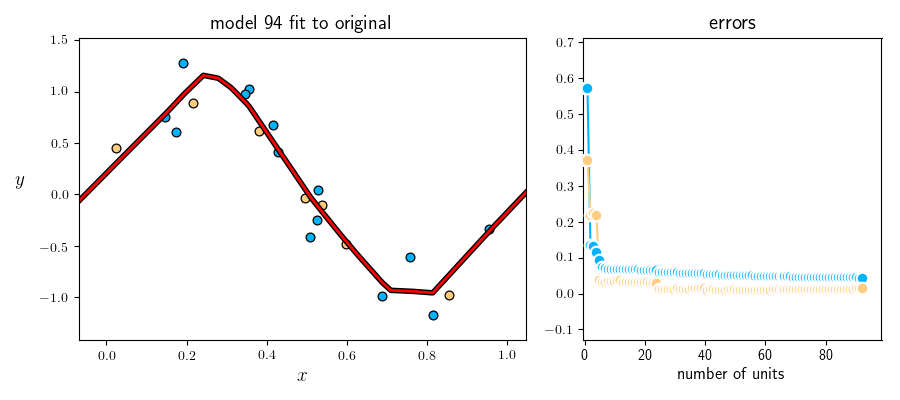
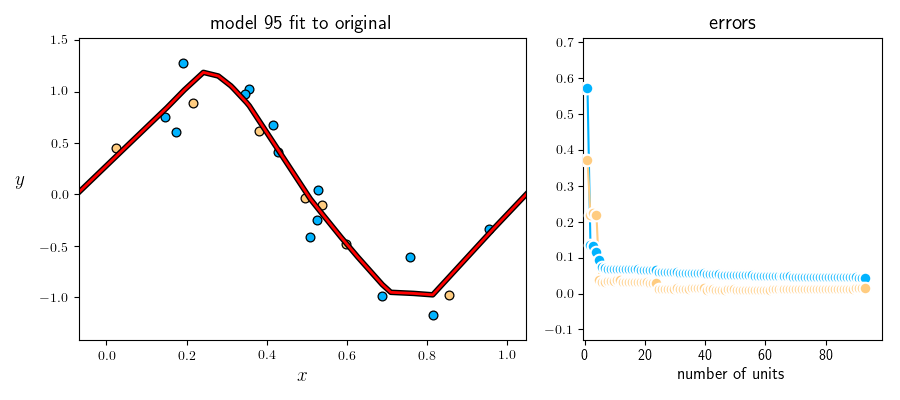
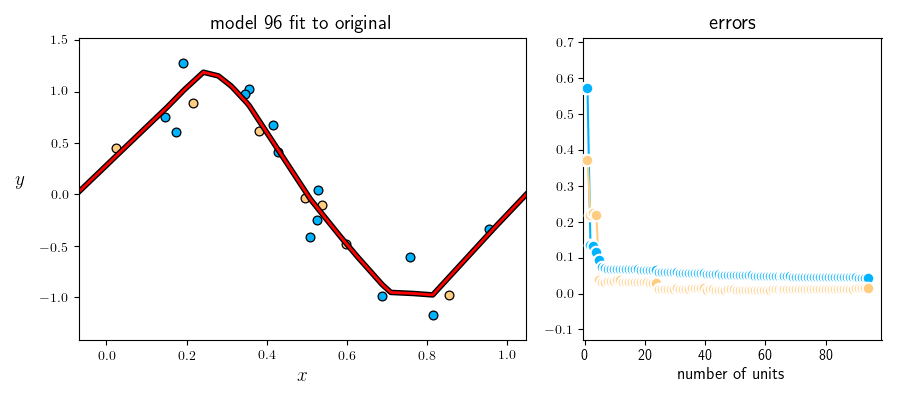
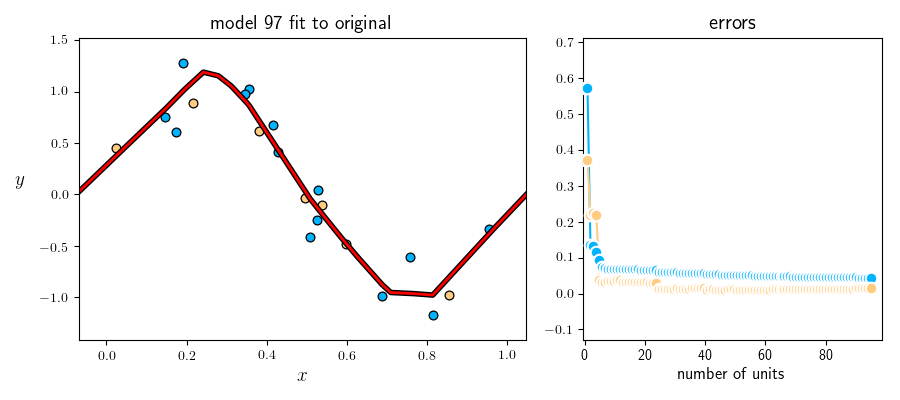
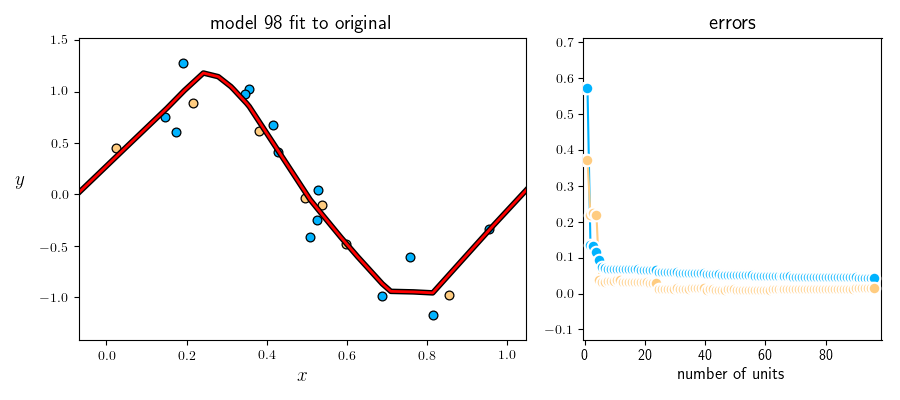
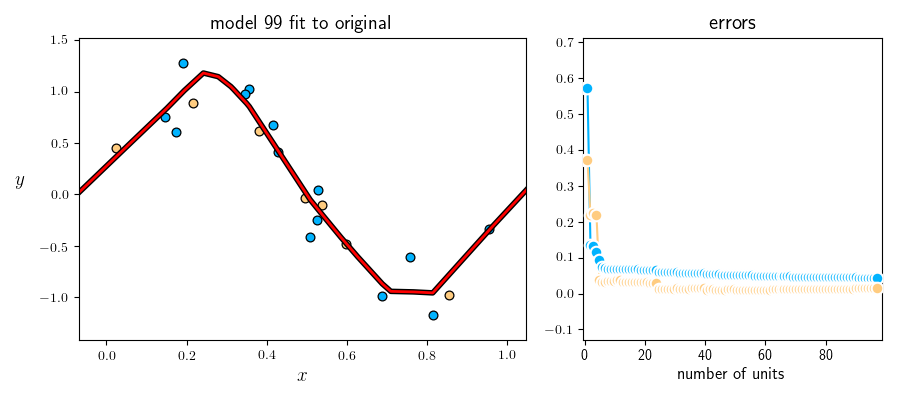
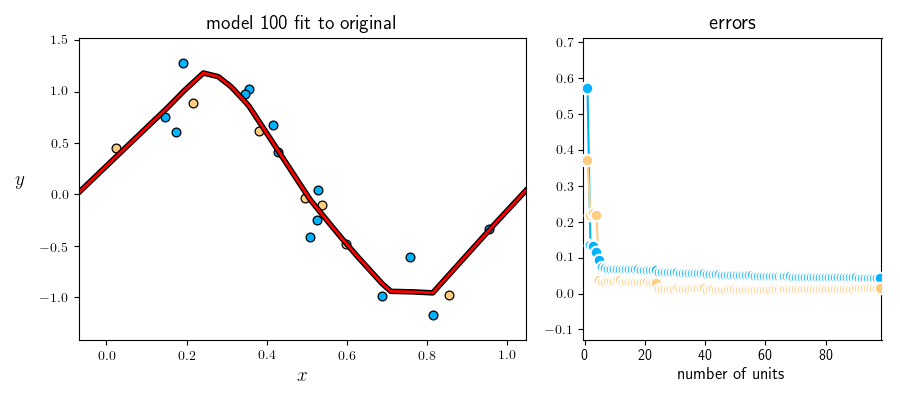

In [29]:
# animate the business
frames = 100
demo1 = nonlib.boosting_regression_animators.Visualizer(csvname)
demo1.animate_trainval_boosting(runs1,frames,num_units,show_history = True)

#### <span style="color:#a50e3e;">Example 3. </span> Boosting classification - using high capacity rounds

In this example we illustrate the same kind of boosting performed above with regression, employing single `tanh` units added in one-at-a-time to our `model`, for two class classification.  Here we use a small dataset of $99$ datapoints that has a roughly circular decision boundary (this dataset was first used in the previous Section), and split it randomly into $\frac{2}{3}$ training and $\frac{1}{3}$ validation.  Once again we animate this process over a range boosting steps - here we perform of $30$ of them - where we add $10$ units at-a-time.  As you move the slider from left to right the results of each added unit - in terms of the nonlinear decision boundary and resulting classification - are shown in the top left (where the original data is shown) , top right (where the training data alone is shown), and bottom left (where the validation data is shown) panels.  A plot showing the training / validation errors at each step of the process is shown in the bottom right panel.

Once again here, moving the slider back and forth, we can see that the `model` providing the smallest validation error appears to (more or less) provide the best nonlinearity / decision rule for the entire dataset (i.e., the current data as well as any data that might be generated by the same process in the future).  Here we can see - unsurprisingly given that we add $10$ units per round of boosting - that a single round of boosting provides the lowest validation error.  The amount of capacity we are adding each round, based on the relative simplicity of the dataset, was too large here.  

In [35]:
## This code cell will not be shown in the HTML version of this notebook
# load in dataset
csvname = datapath + 'new_circle_data.csv'
data = np.loadtxt(csvname,delimiter = ',')
x = data[:-1,:]
y = data[-1:,:] 

### boosting ###
num_units = 30
runs3 = []
final_model = lambda data: np.zeros((1,data.shape[1]))
for j in range(num_units):    
    print ('unit ' + str(j) + ' added to model')
    # import the v1 library
    mylib3 = nonlib.boost_lib.superlearn_setup.Setup(x,y)

    # choose features
    mylib3.choose_features(name = 'multilayer_perceptron',layer_sizes = [2,1,1],activation = 'tanh',scale = 0.1)

    # choose normalizer
    mylib3.choose_normalizer(name = 'standard')
    
    # split into training and validation sets
    if j == 0:
        # make training testing split
        mylib3.make_train_valid_split(train_portion = 0.66)
        train_inds = mylib3.train_inds
        valid_inds = mylib3.valid_inds

    else: # use split from first run for all further runs
        mylib3.x_train = runs3[j-1].x[:,train_inds]
        mylib3.y_train = runs3[j-1].y[:,train_inds]
        mylib3.x_valid = runs3[j-1].x[:,valid_inds]
        mylib3.y_valid = runs3[j-1].y[:,valid_inds]
        mylib3.train_inds = train_inds
        mylib3.valid_inds = valid_inds
    
    # in second round and beyond add in contribution of previous model
    # when choosing cost
    mylib3.choose_cost(name = 'softmax',runs = runs3)    
    
    # fit an optimization
    mylib3.fit(max_its = 5000,alpha_choice = 10**(0))
    runs3.append(mylib3)
    
# report update and clear cell output
print ('finished all ' + str(num_units) + ' steps')
time.sleep(1.5)
clear_output()


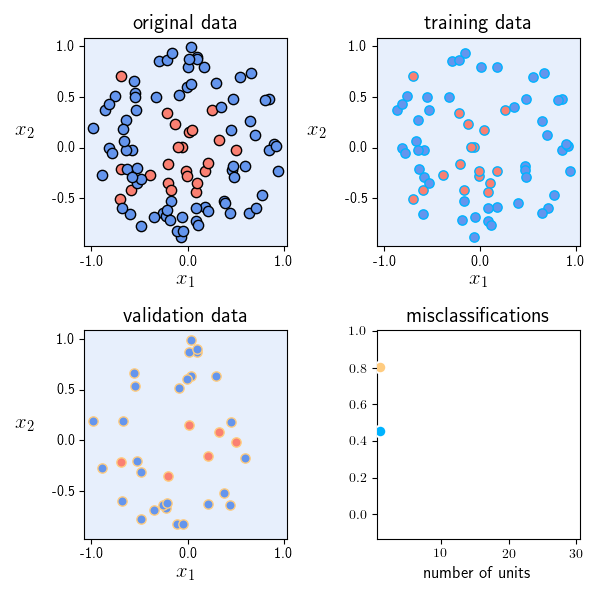
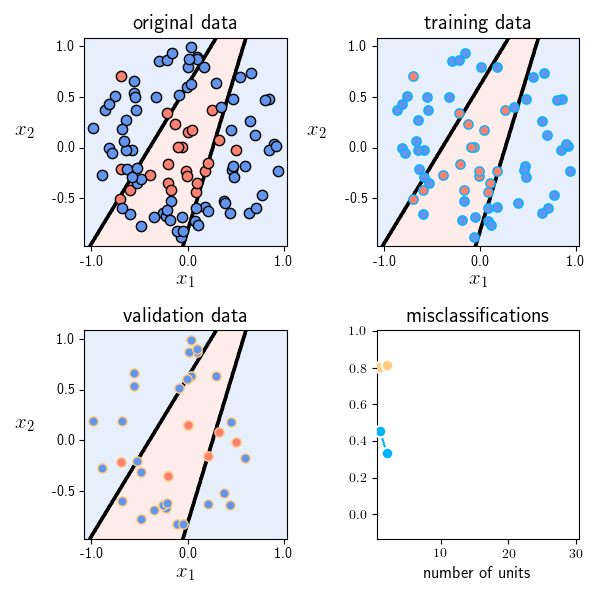
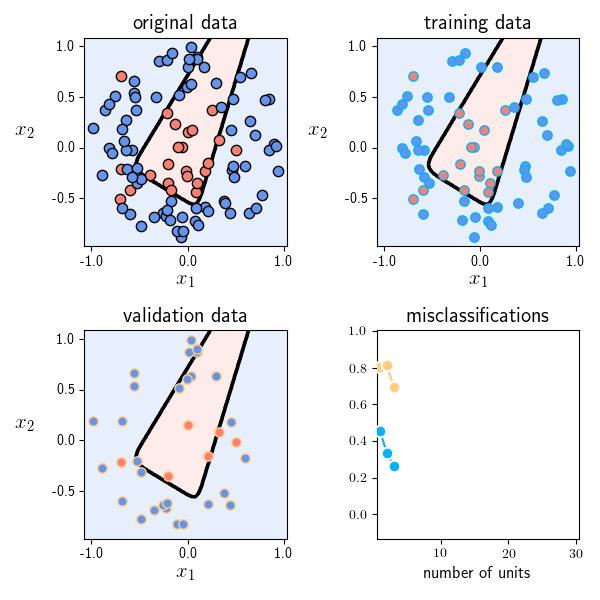
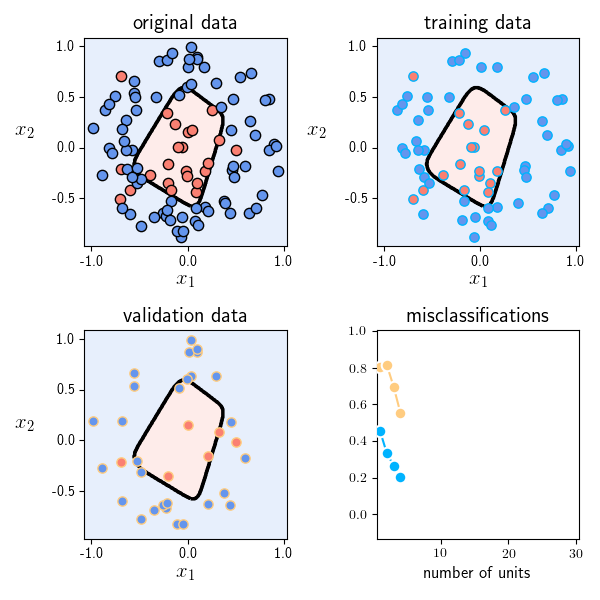
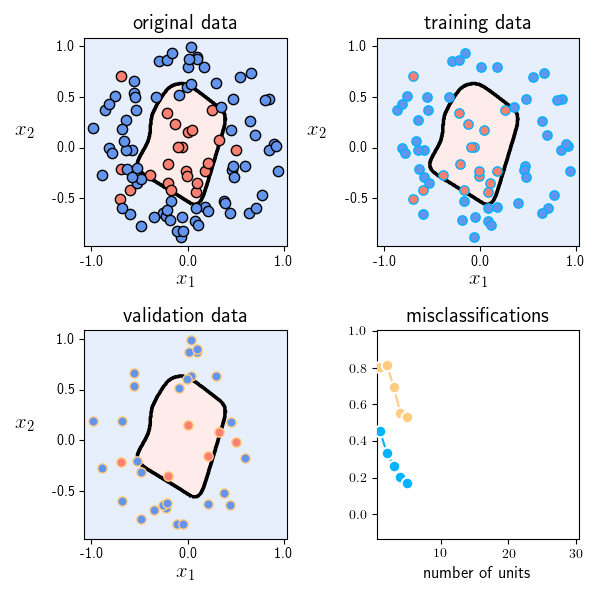
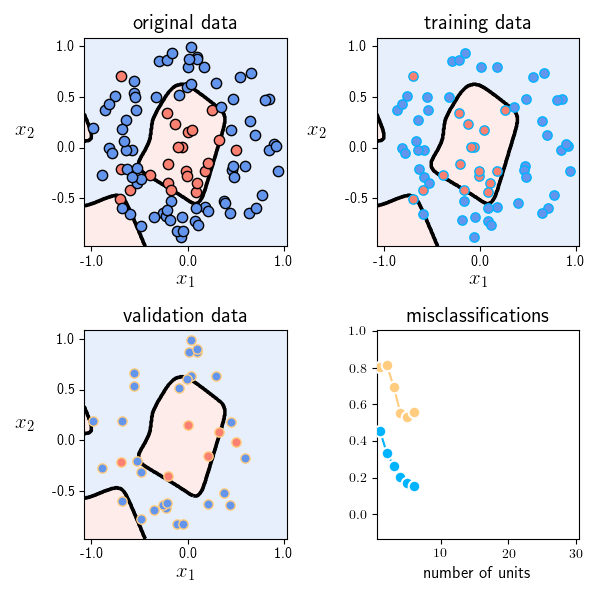
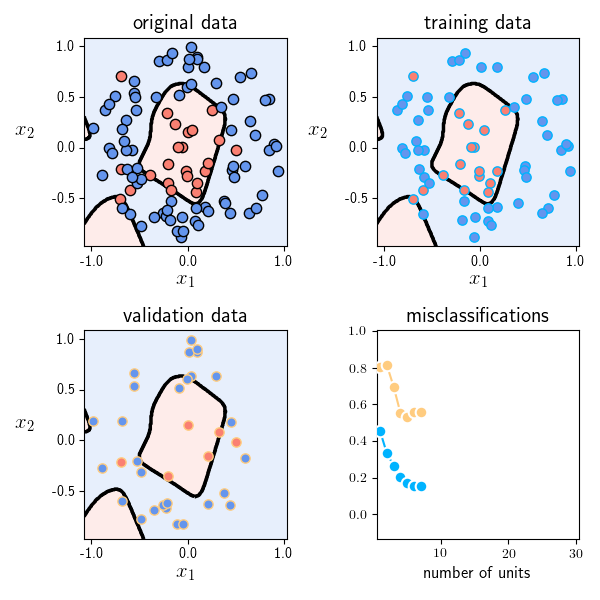
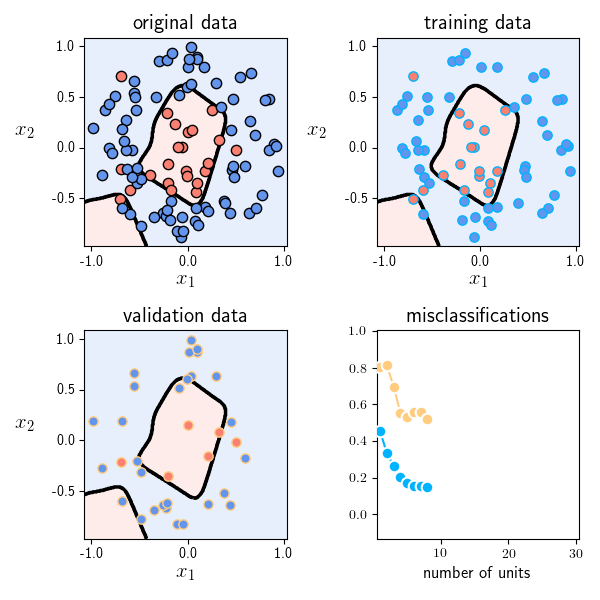
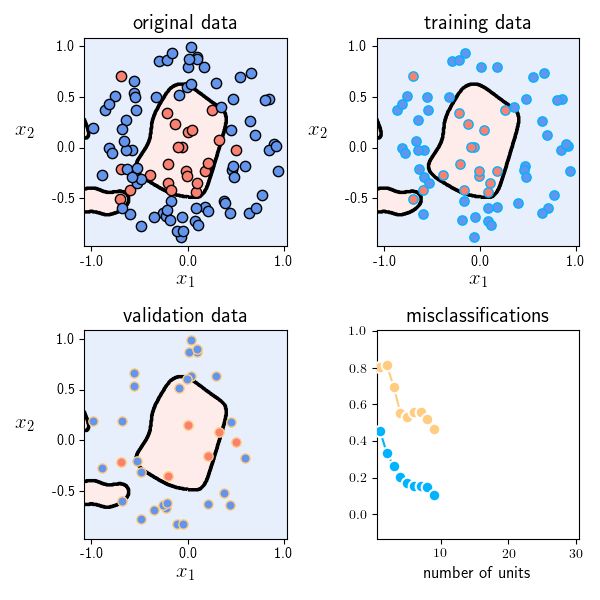
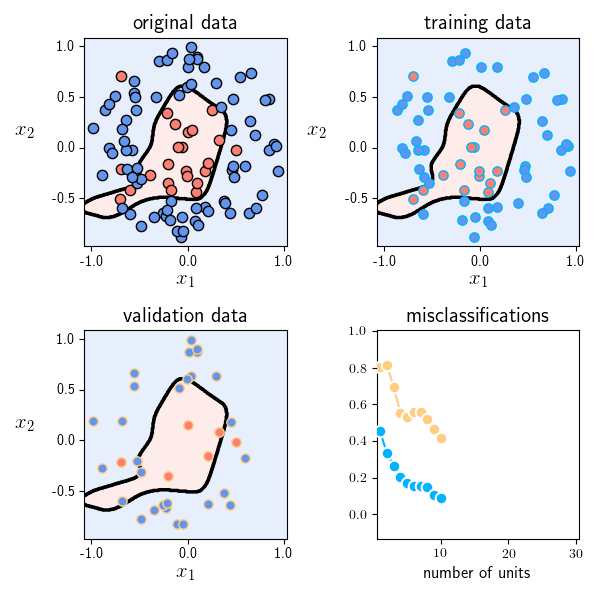
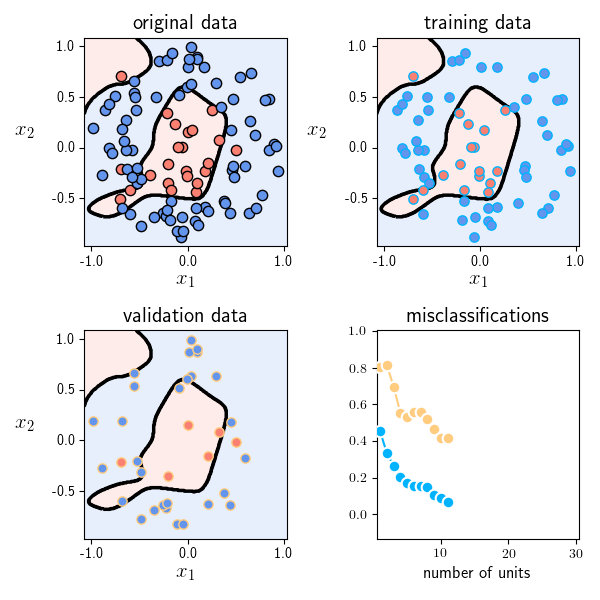
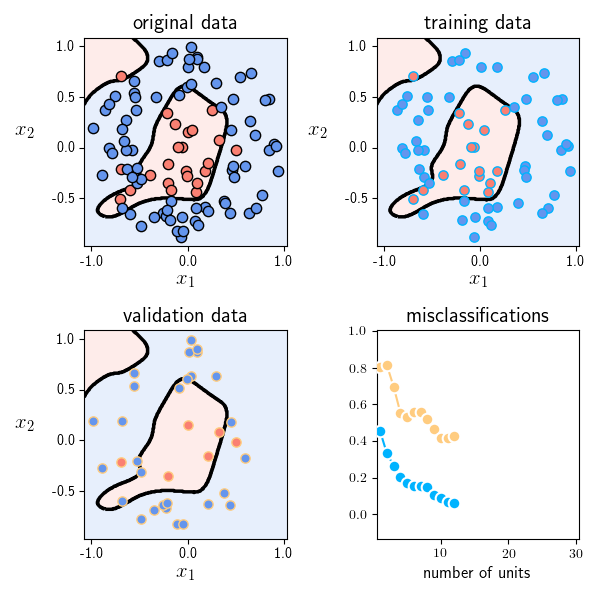
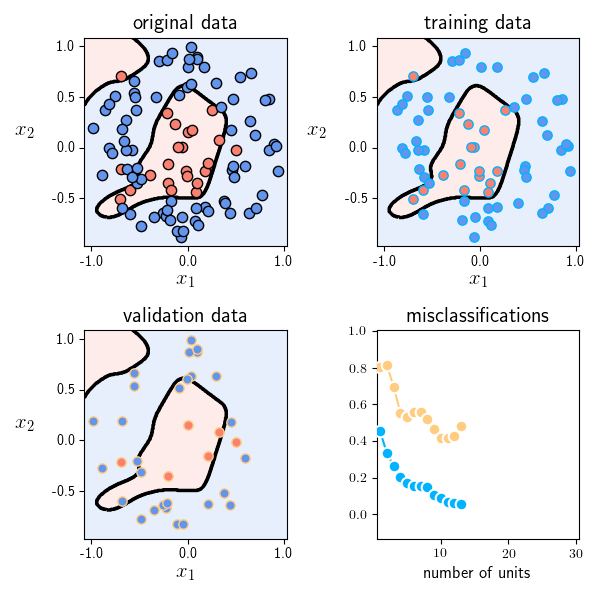
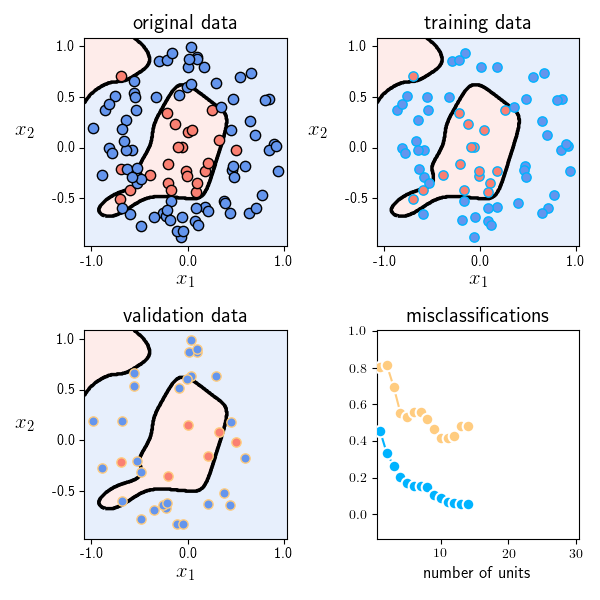
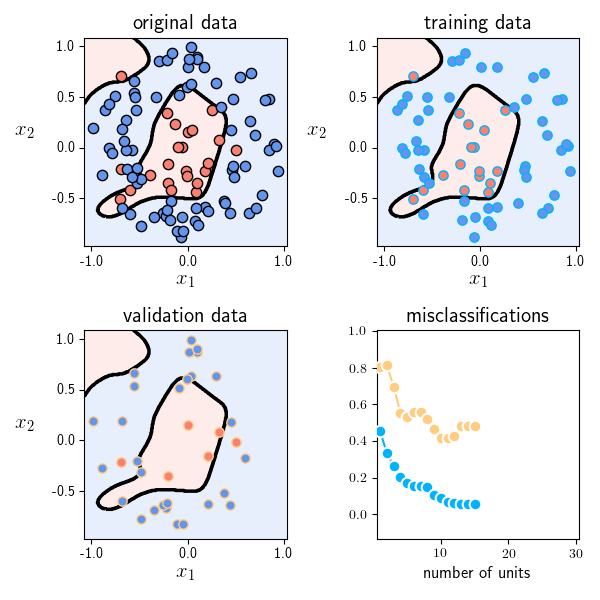
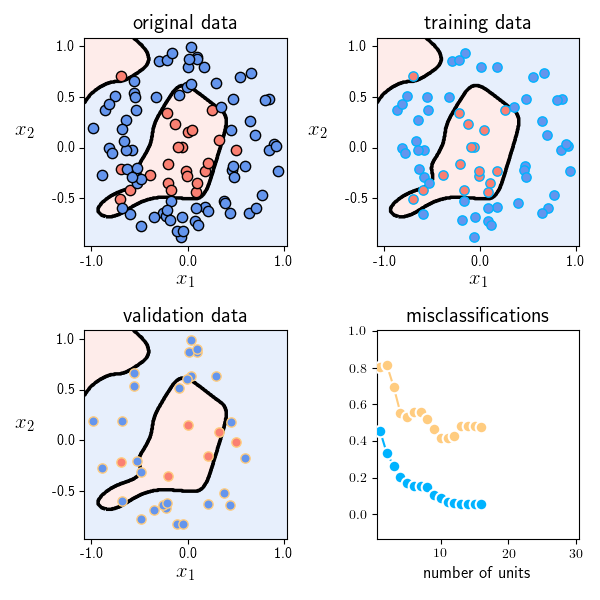
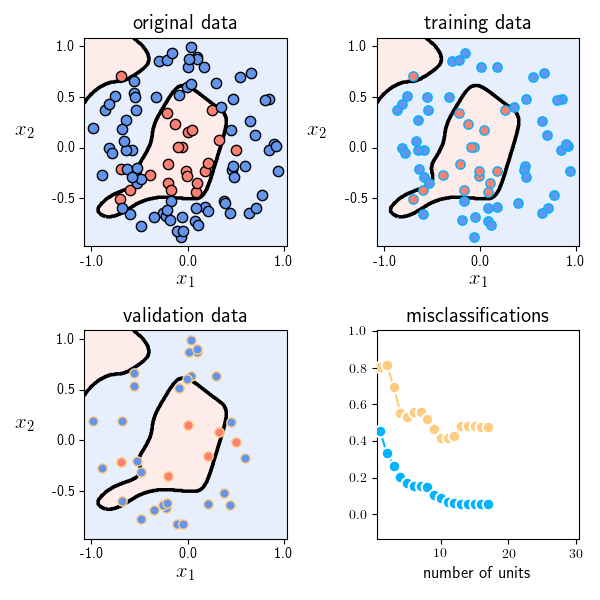
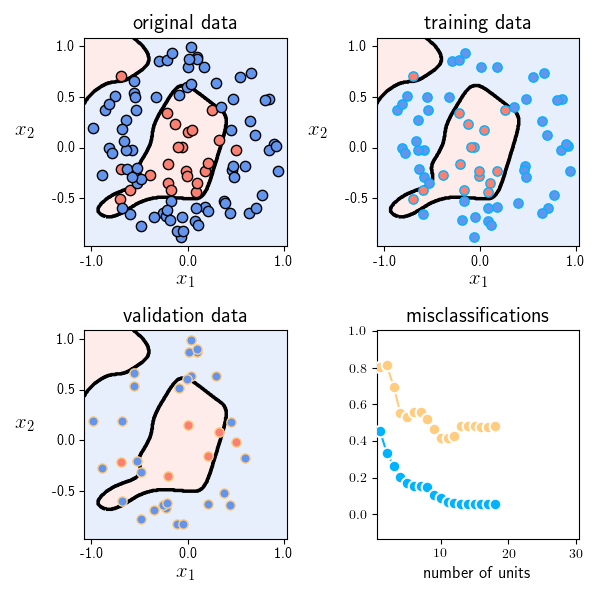
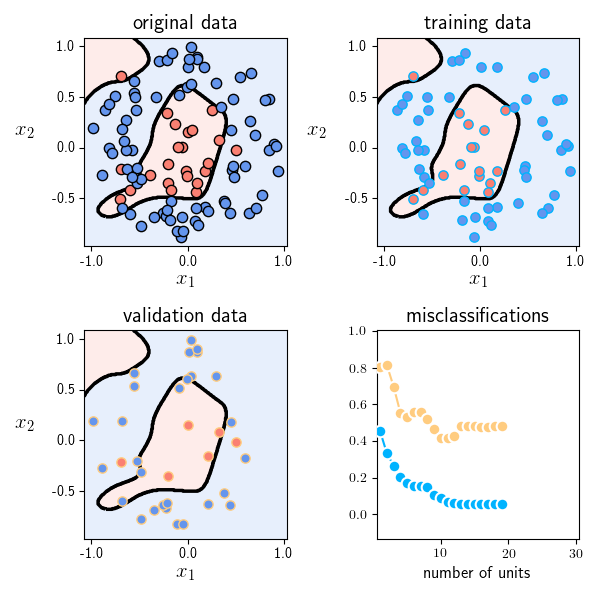
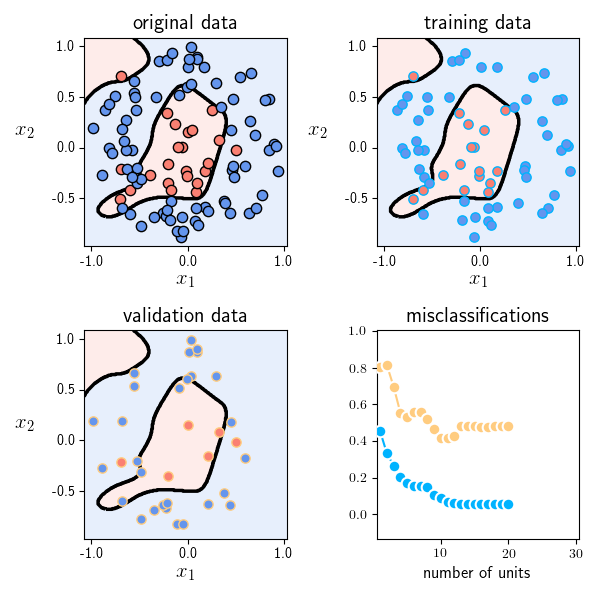
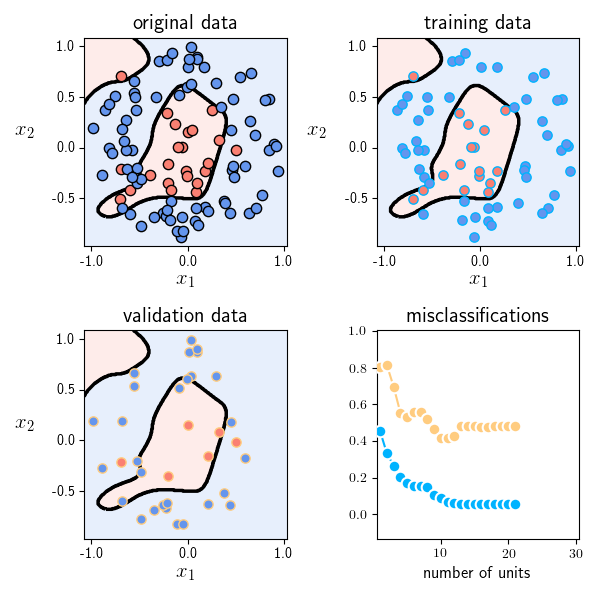
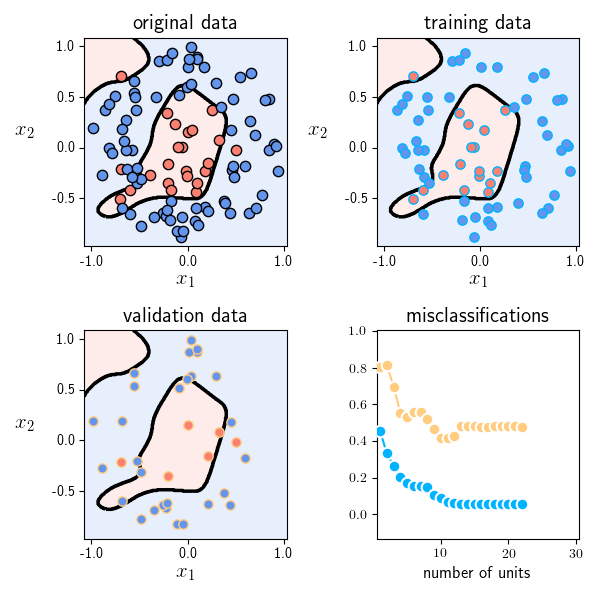
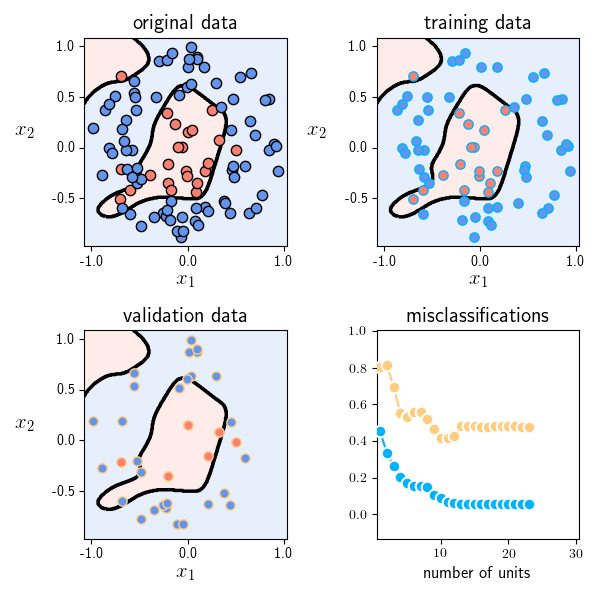
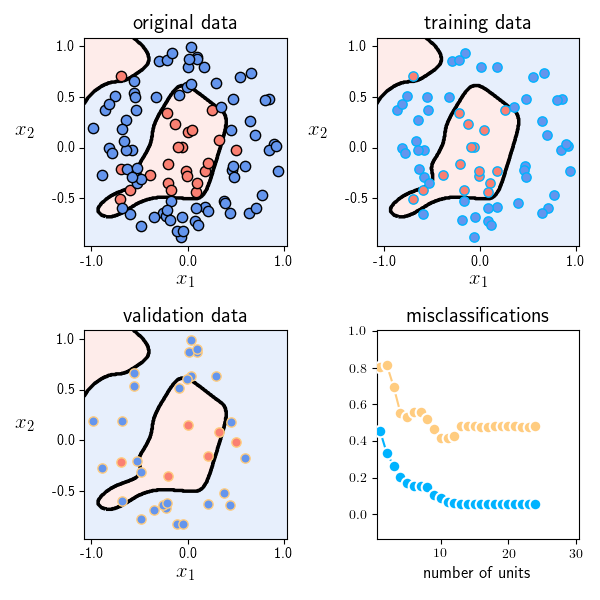
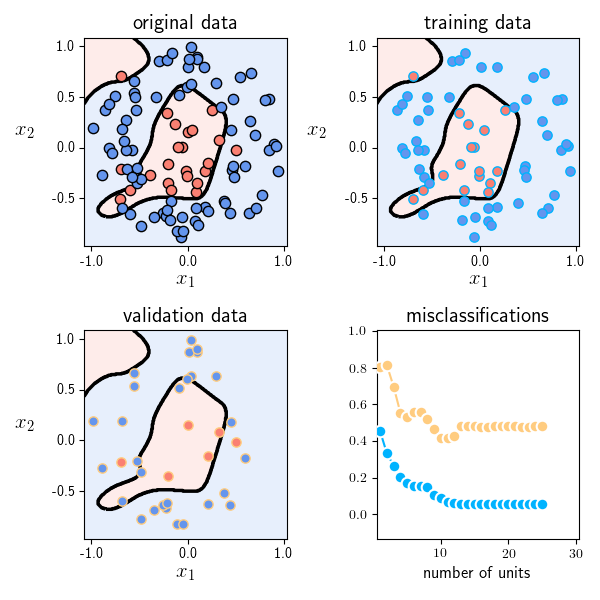
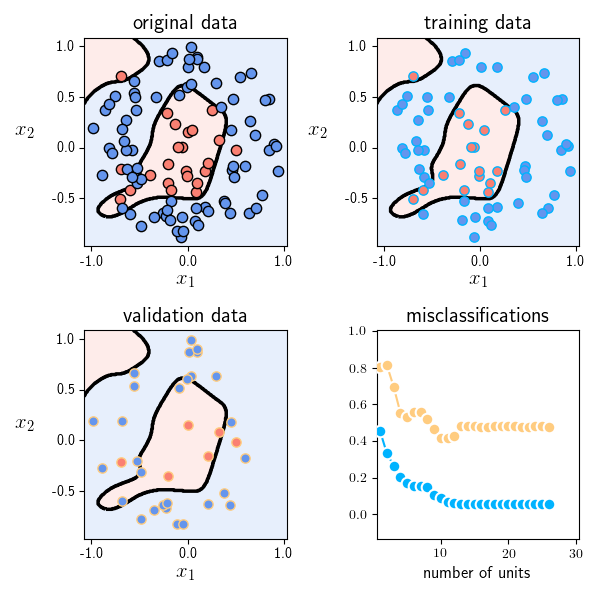
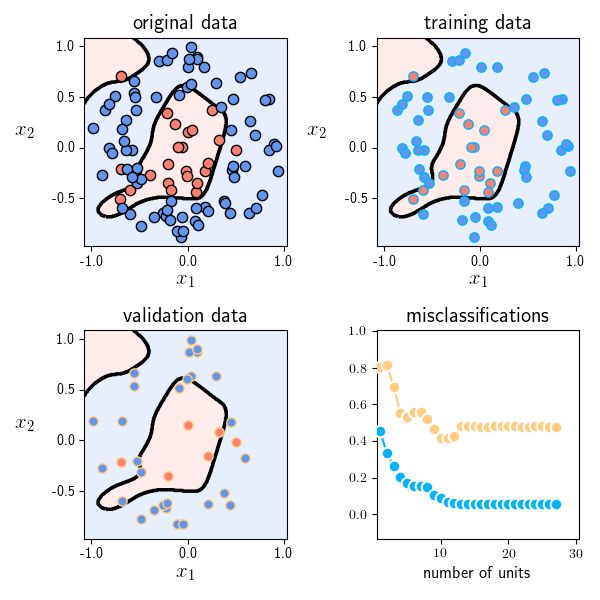
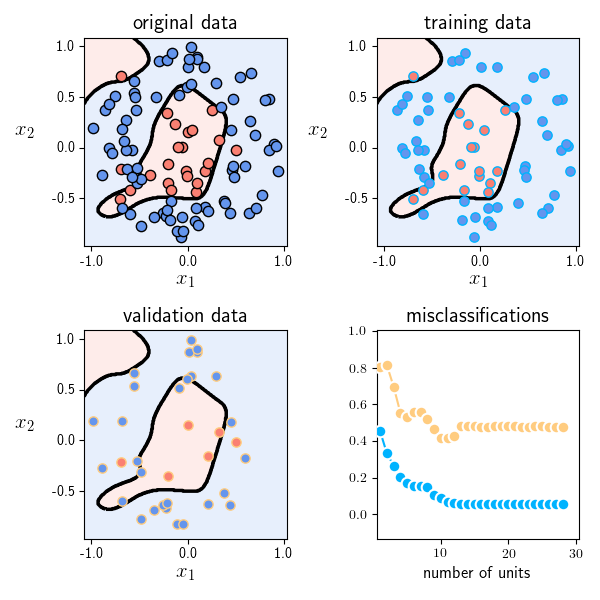
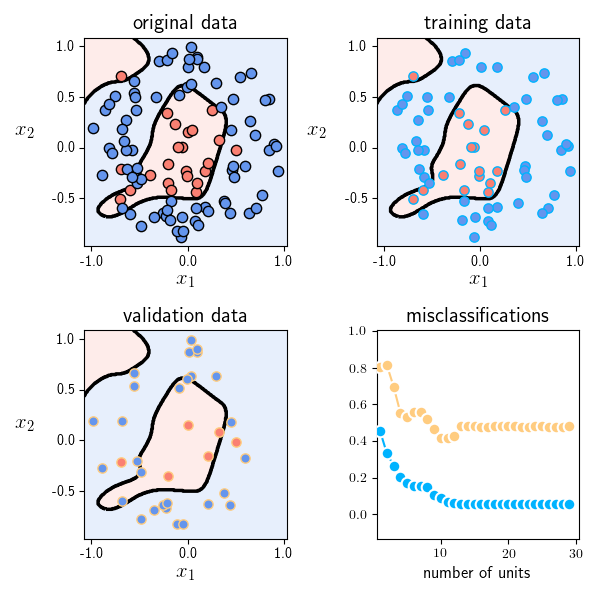
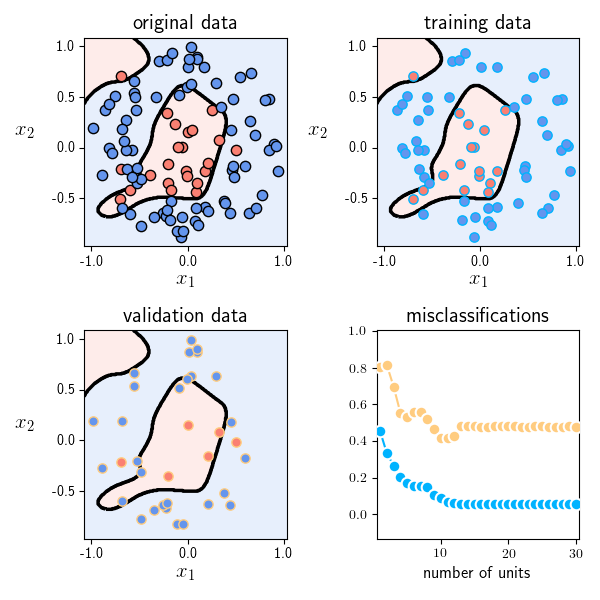

In [36]:
# load up animator
demo3 = nonlib.boosting_classification_animator.Visualizer(csvname)

# animate based on the sample weight history
frames = 30
demo3.animate_trainval_boosting(runs3,frames,num_units)

## 11.3.3  Connections to boosting for feature selection

Note that the *boosting method* described here is almost entirely similar to the *boosting method* described in the context of feature selection in Section 9.5.  However 

## 11.3.2 The residual perspective with regression

Here we describe a common interpretation of boosting in the context of regression, that of sequentially fitting to the 'residual' of a regression dataset.  To see what this means let us study a regression cost function - here Least Squares - where we have inserted a boosted `model` at the $m^{th}$ step of its development

\begin{equation}
g\left(\mathbf{w}\right) = \frac{1}{P}\sum_{p=1}^{P}\left(\text{model}_m\left(\mathbf{x}_p,\mathbf{w}\right) - y_p\right)^2.
\end{equation}

 Suppose this boosted `model` has been constructed by recursively adding a single unit at each step of the boosting process.  Since our boosted model is recursive, we can write equivalently as  $\text{model}_m\left(\mathbf{x}_p,\mathbf{w}\right) =   \text{model}_{m-1}\left(\mathbf{x}_p\right) + f_m\left(\mathbf{x}_p\right)w_m$ where all of the parameters of the $\left(m-1\right)^{th}$ `model`, $\text{model}_{m-1}$, are already tuned.  Examining just the $p^{th}$ summand of the cost function above, notice we can re-write it as
 
 \begin{equation}
\left(\text{model}_{m-1}\left(\mathbf{x}_p\right) + f_m\left(\mathbf{x}_p\right)w_m - y_p \right)^2 = \left(f_m\left(\mathbf{x}_p\right)w_m - \left(y_p - \text{model}_{m-1}\left(\mathbf{x}_p\right)\right)\right)^2.
 \end{equation}

On the right hand side we have just re-arranged terms, keeping our term with parameters that still need tuning $f_m\left(\mathbf{x}\right)w_m $ on the left and lumping all of the *fixed* quantities together - i.e., $y_p - \text{model}_{m-1}$ - on the right.  Applying this to each summand of the cost function we can write it equivalently as 

\begin{equation}
g\left(\mathbf{w}\right) = \frac{1}{P}\sum_{p=1}^{P}\left(f_m\left(\mathbf{x}_p\right)w_m - \left(y_p - \text{model}_{m-1}\left(\mathbf{x}_p\right)\right)\right)^2.
\end{equation}

By minimizing this error notice we look to tune the parameters of a single additional unit so that

\begin{equation}
f_m\left(\mathbf{x}_p\right)w_m\approx y_p - \text{model}_{m-1}\left(\mathbf{x}_p\right) \,\,\,\,\, p=1,...,P
\end{equation}

or in other words, so that this fully tuned unit approximates our original output $y_p$ minus the contribution of the previous model $\text{model}_{m-1}\left(\mathbf{x}_p\right)$.  This quantity - the difference between our original output and the contribution of the $\left(m-1\right)^{th}$ `model` - is often called the *residual*.  It is the 'leftovers', what is left to represent after learning after subtracting off what was learned by the $\left(m-1\right)^{th}$ `model`.

#### <span style="color:#a50e3e;">Example 2. </span> Boosting regression and 'fitting to the residual'

Below we animate the process of boosting $M = 5000$ single layer `tanh` units to a one dimensional input regression dataset.  In the left panel we show the dataset along with the fit provided by $\text{model}_m$ at the $m^{th}$ step of boosting.  In the right panel we plot the *residual* at the same step, as well as the fit provided by the corresponding $m^{th}$ *unit* $f_m$.  As you pull the slider from left to right the run of boosting progresses, with the fit on the original data improving and while (simultaneously) the residual shrinks.


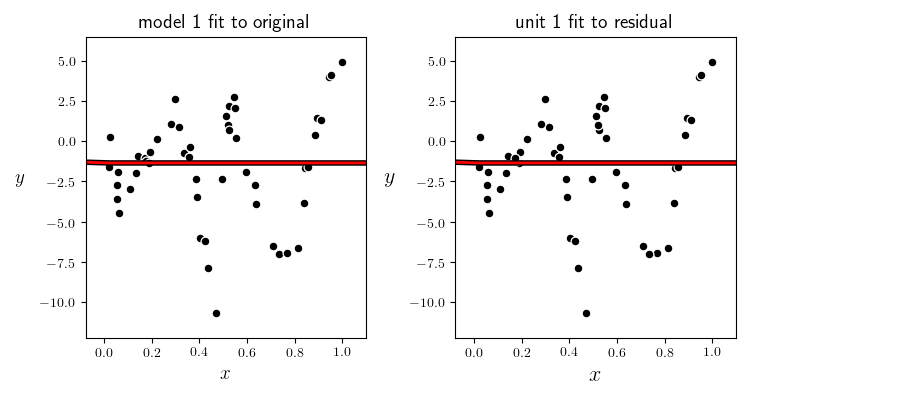
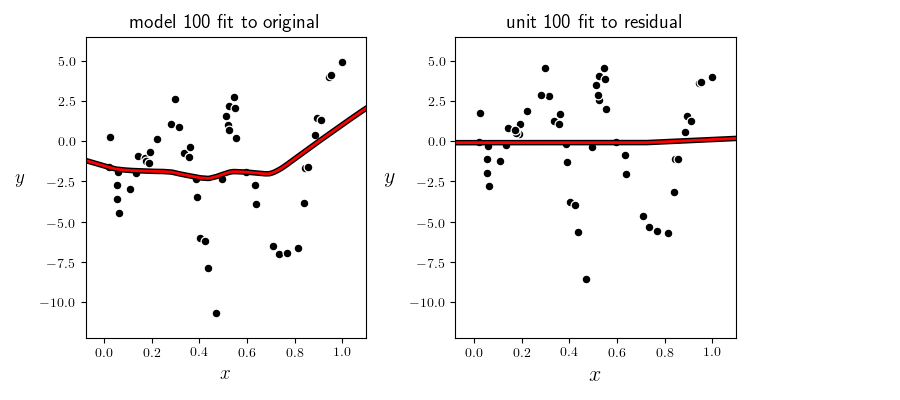
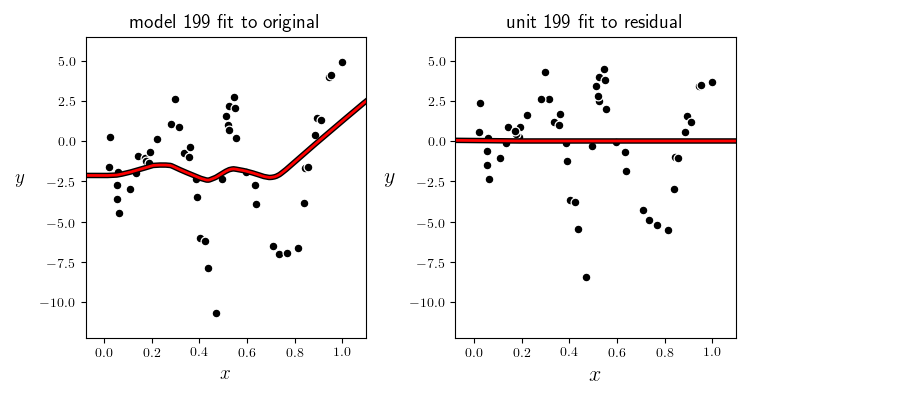
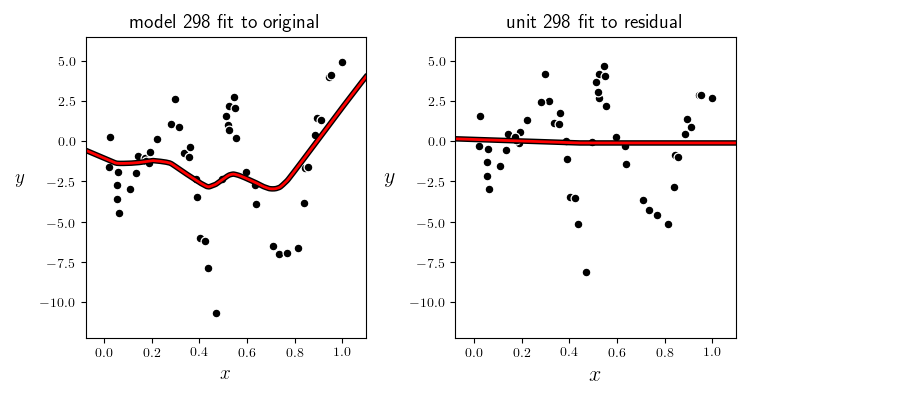
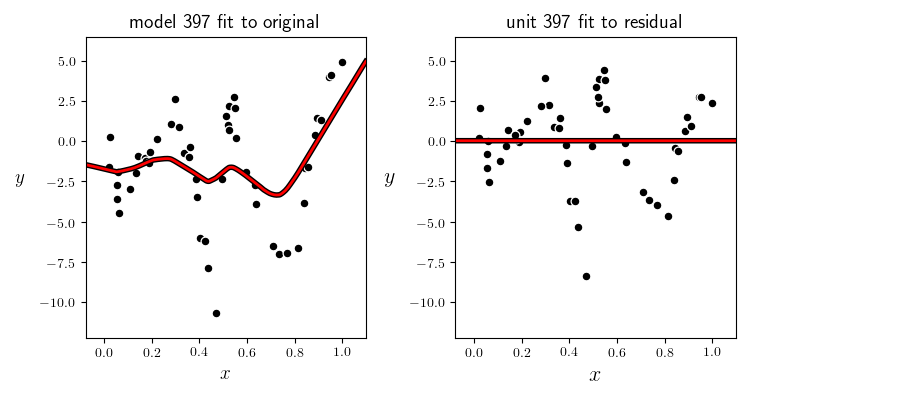
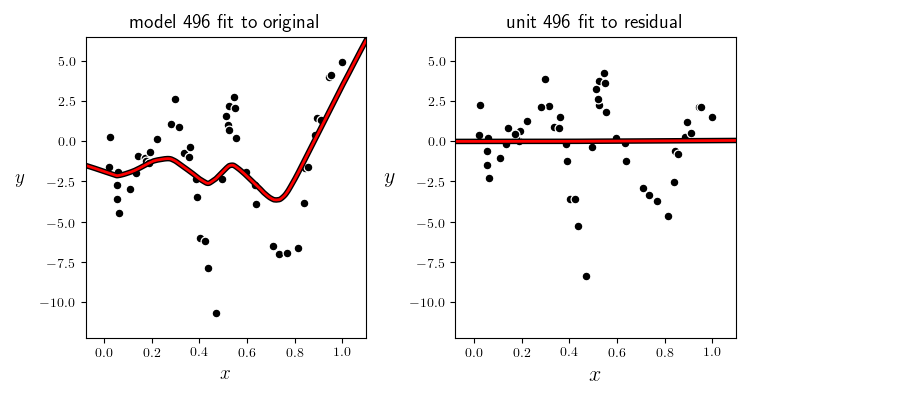
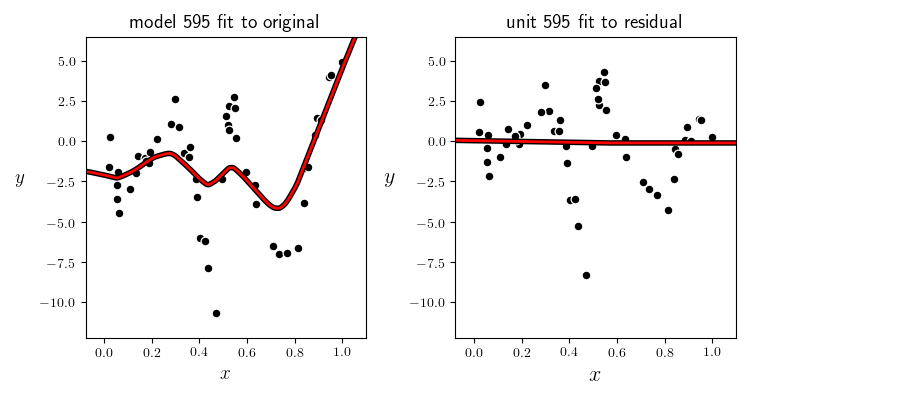
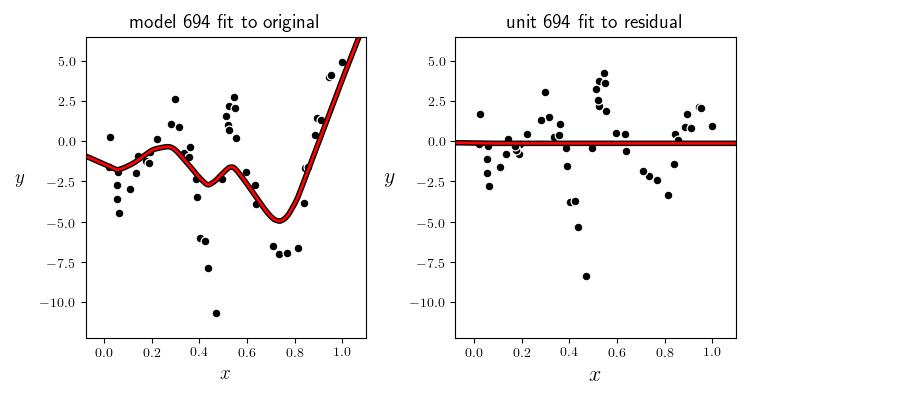
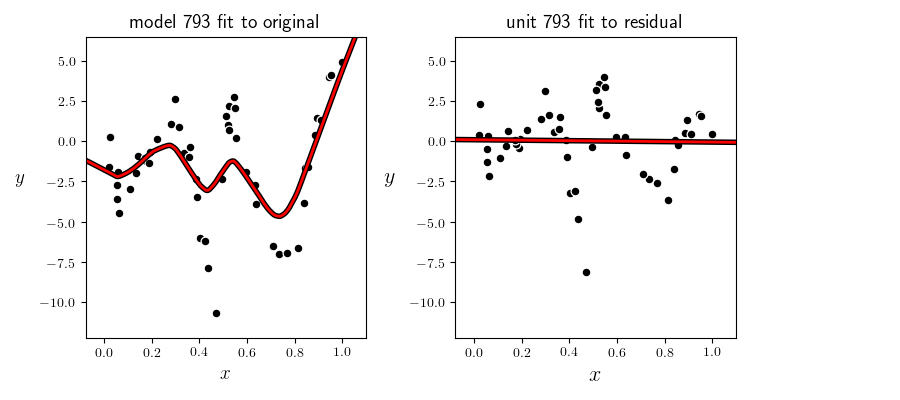
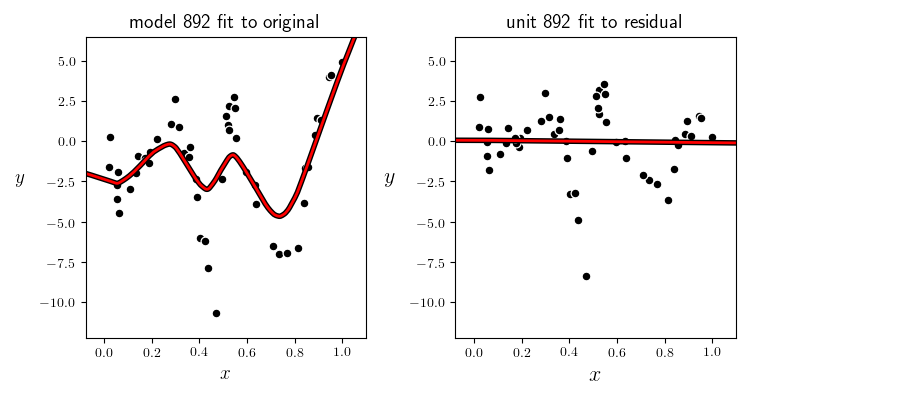
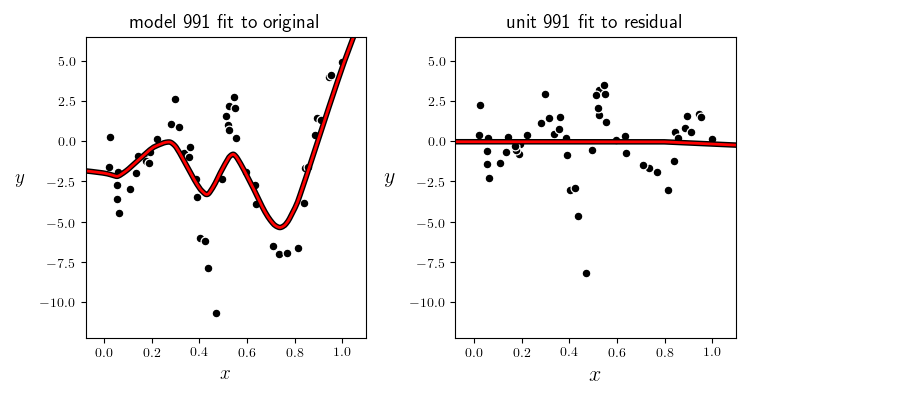
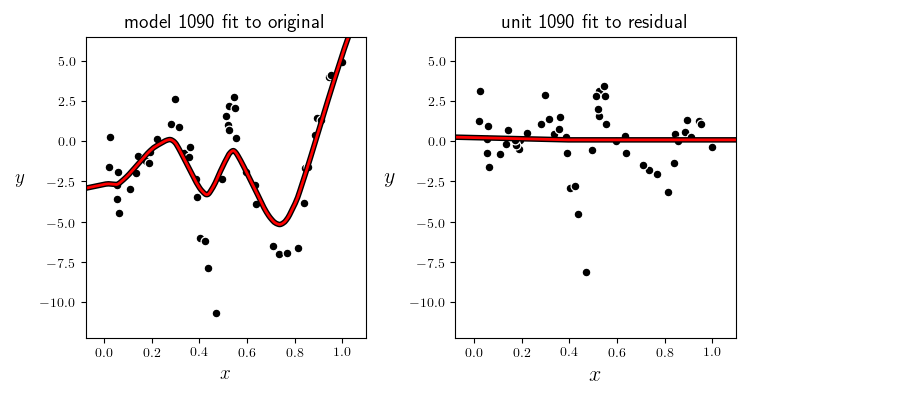
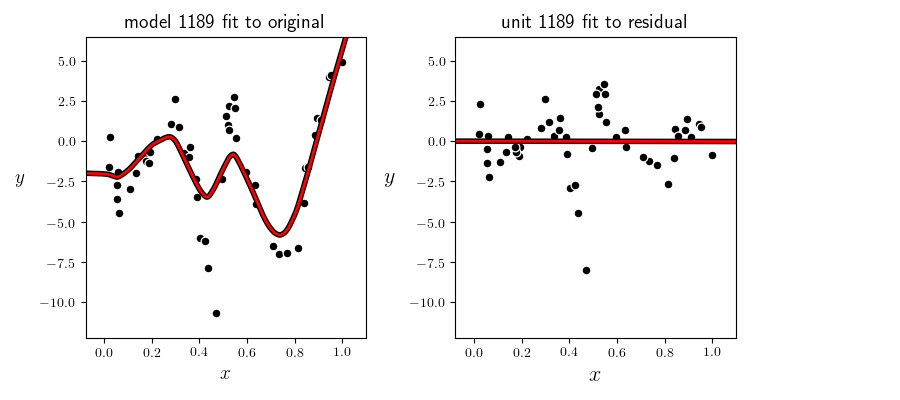
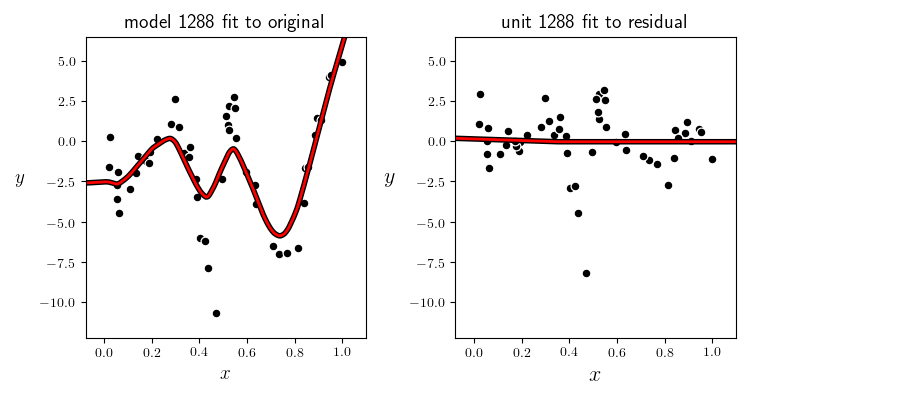
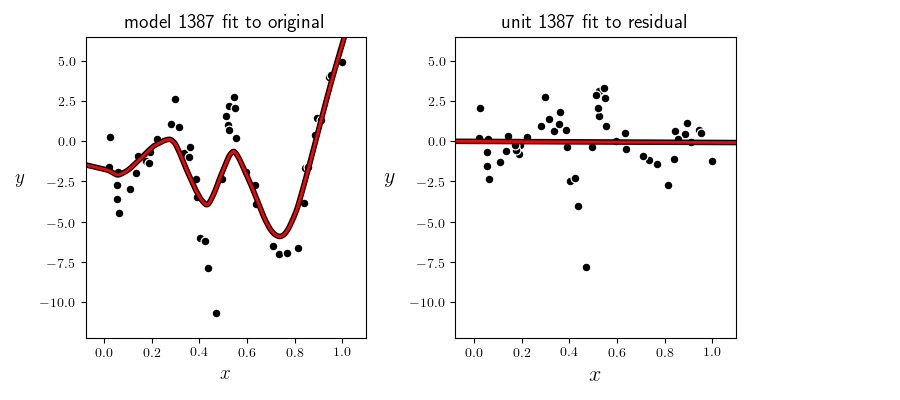
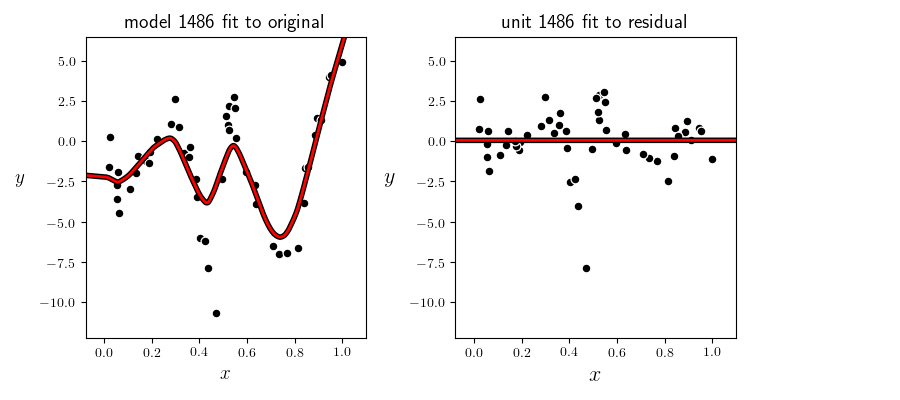
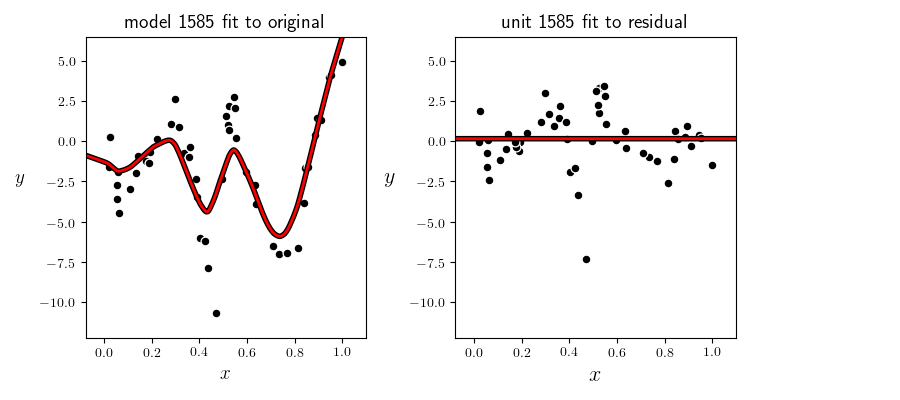
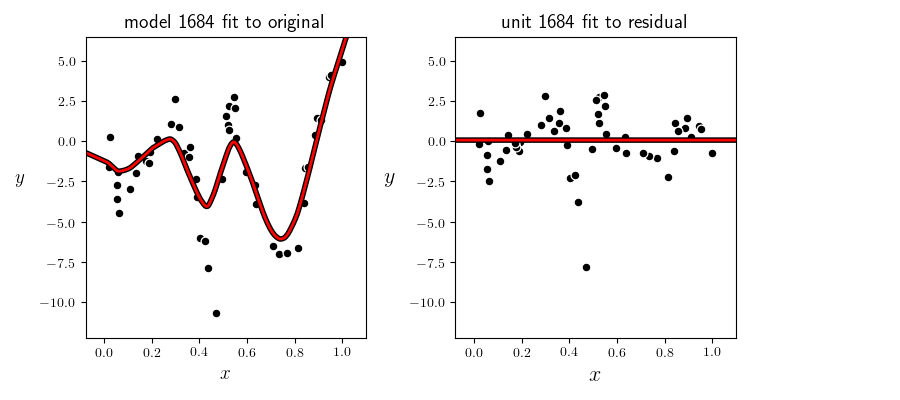
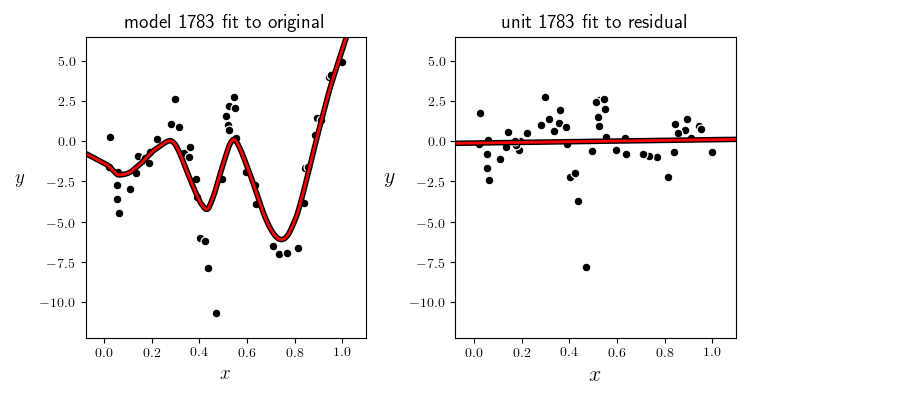
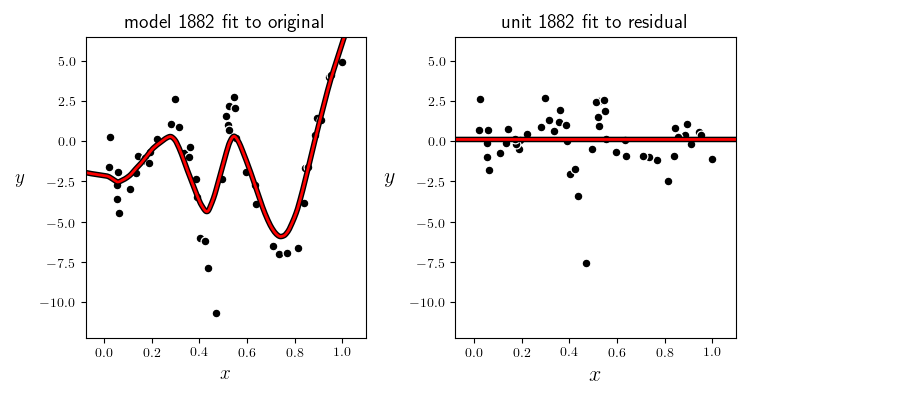
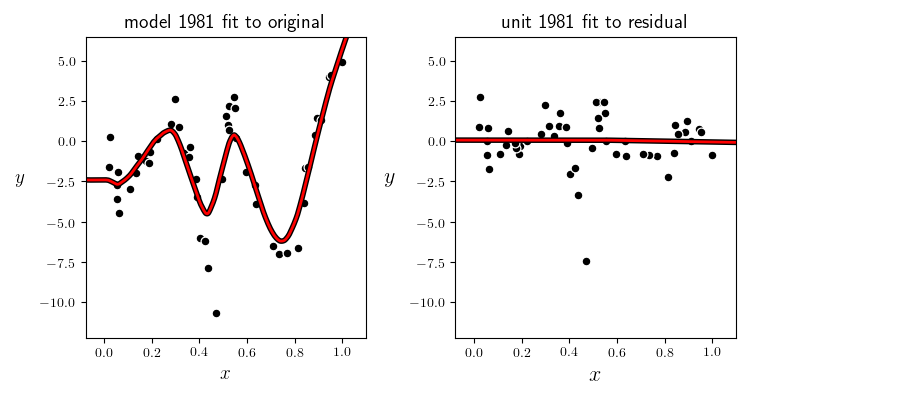
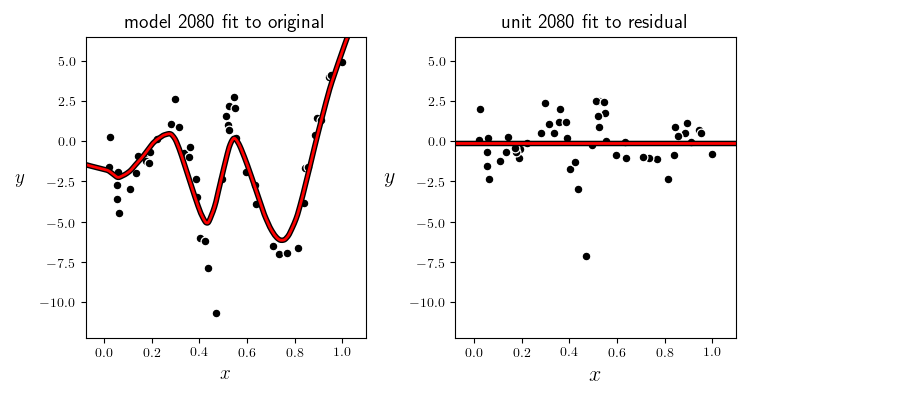
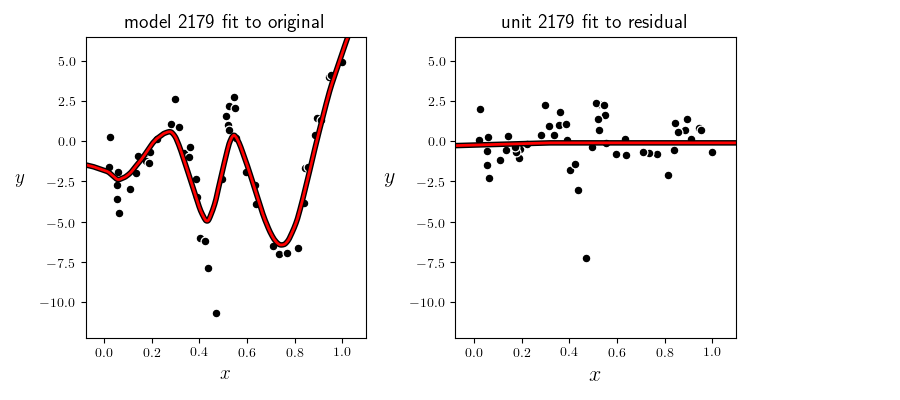
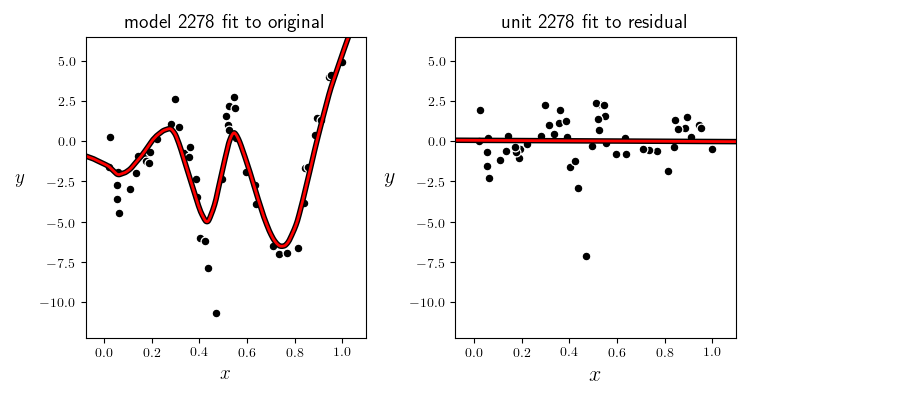
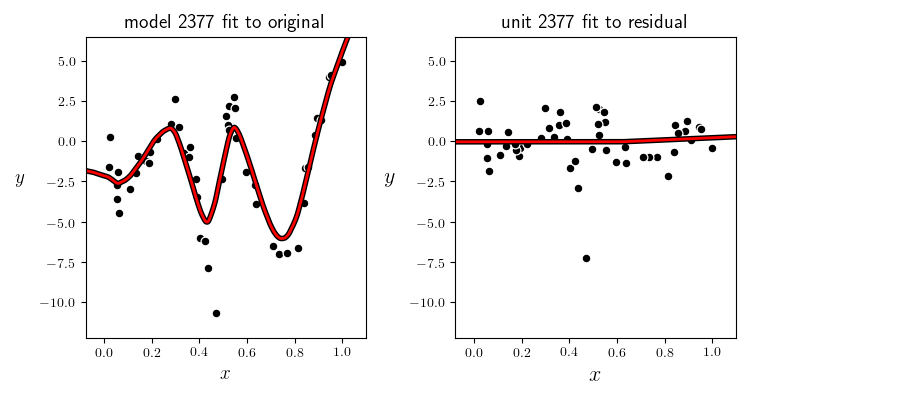
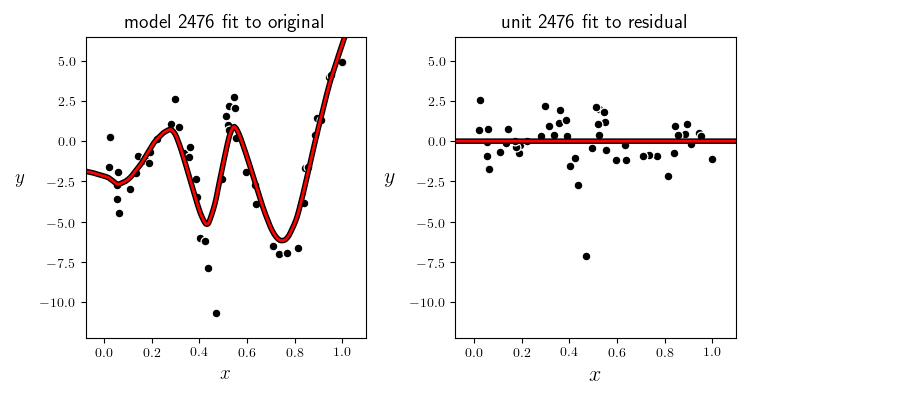
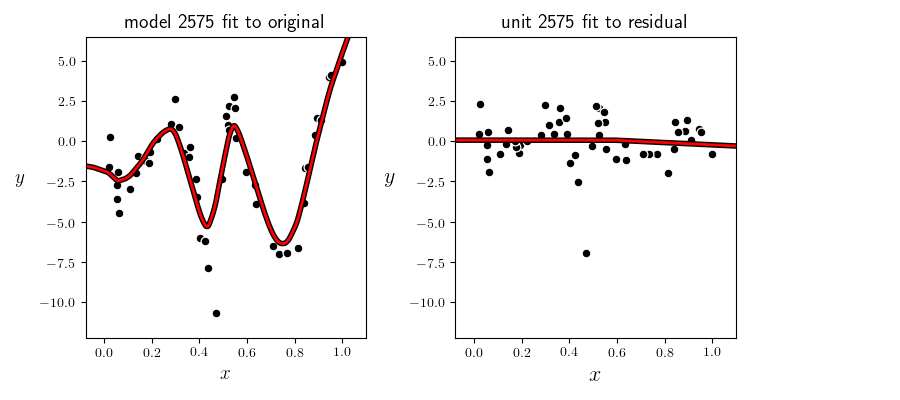
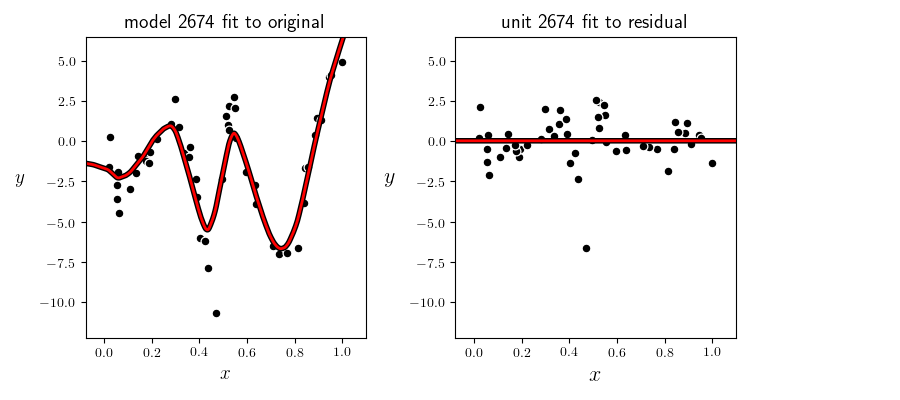
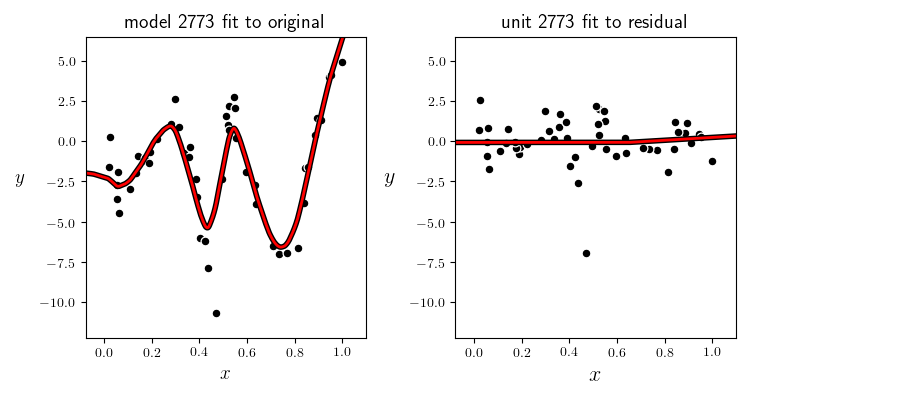
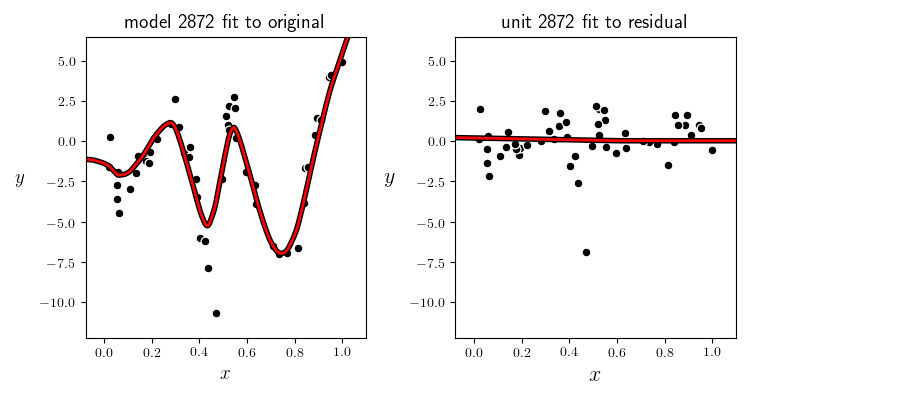
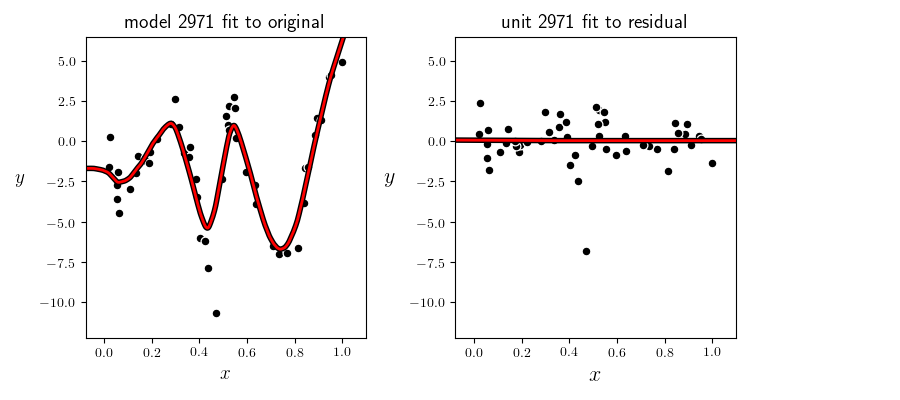
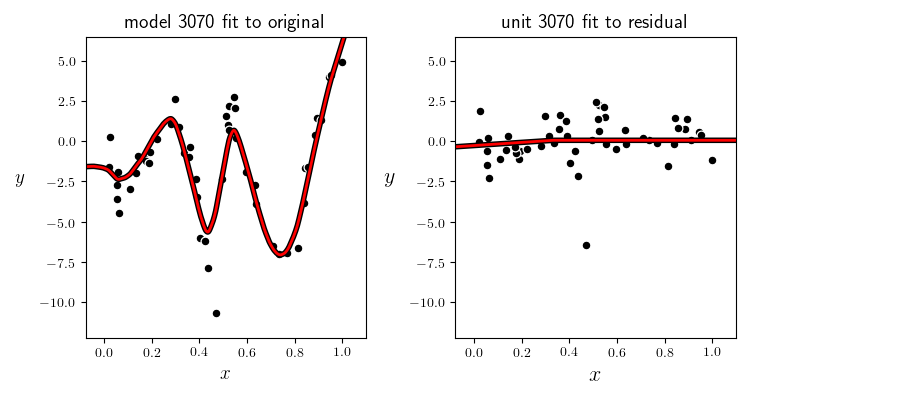
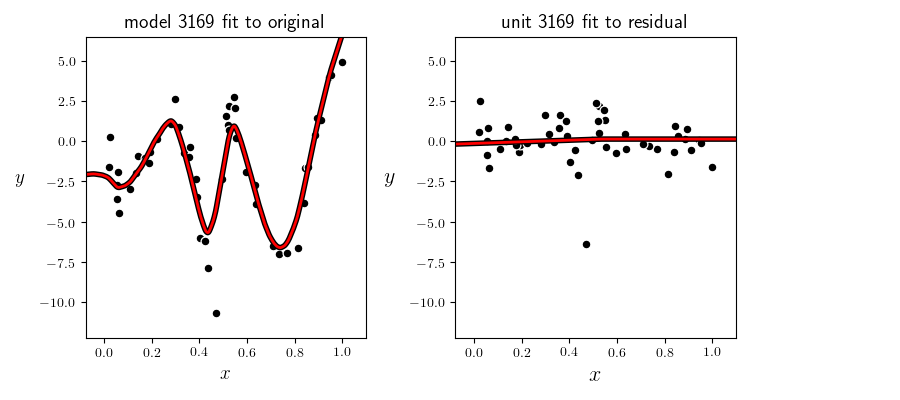
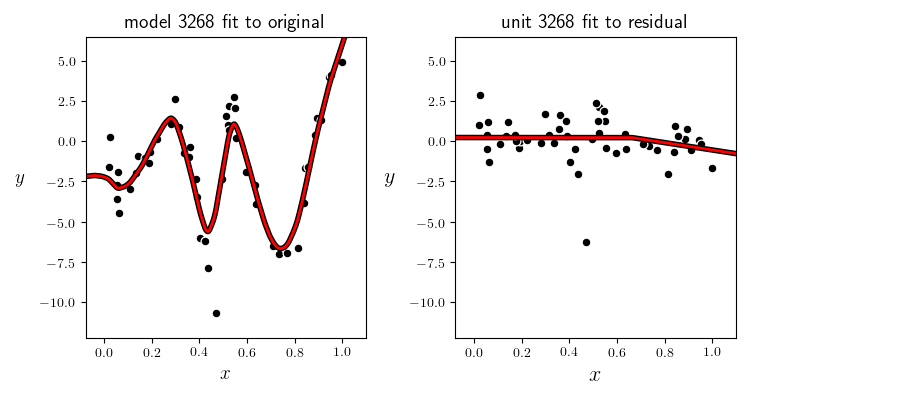
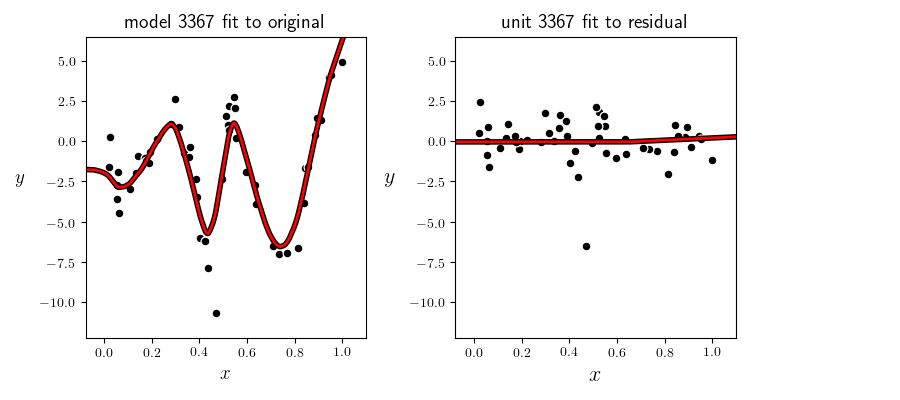
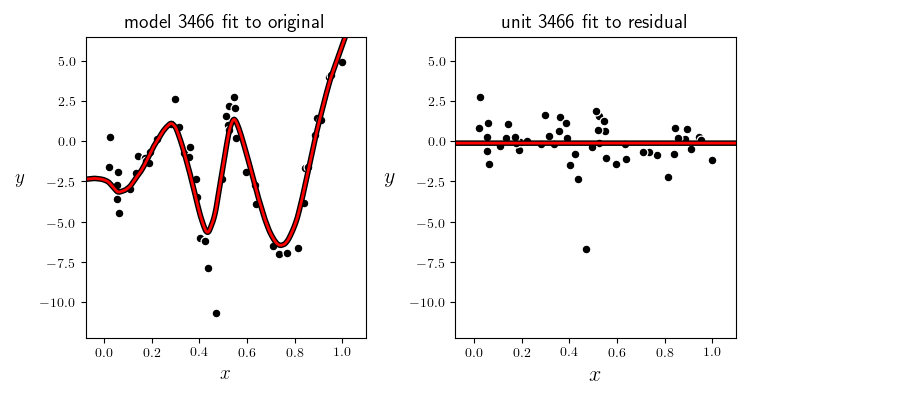
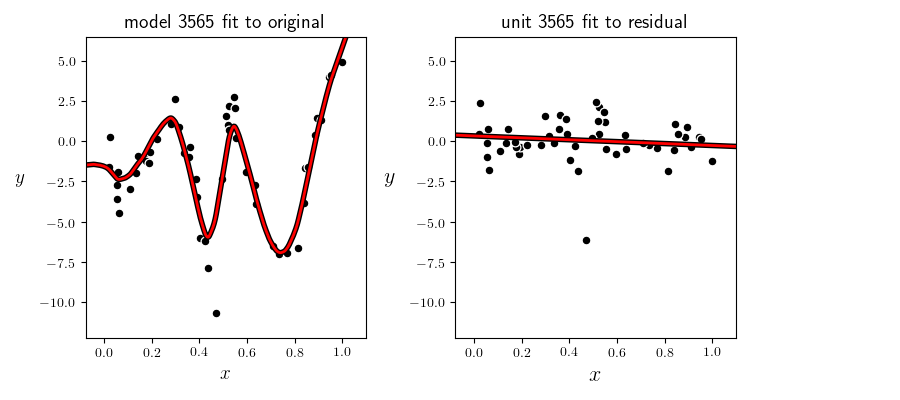
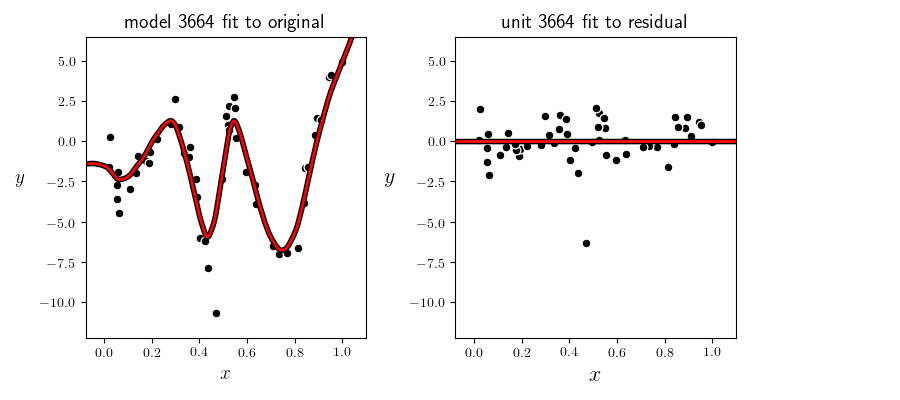
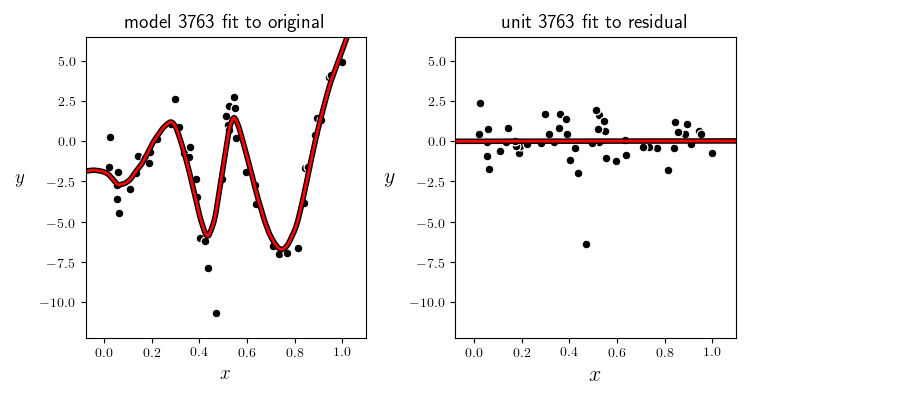
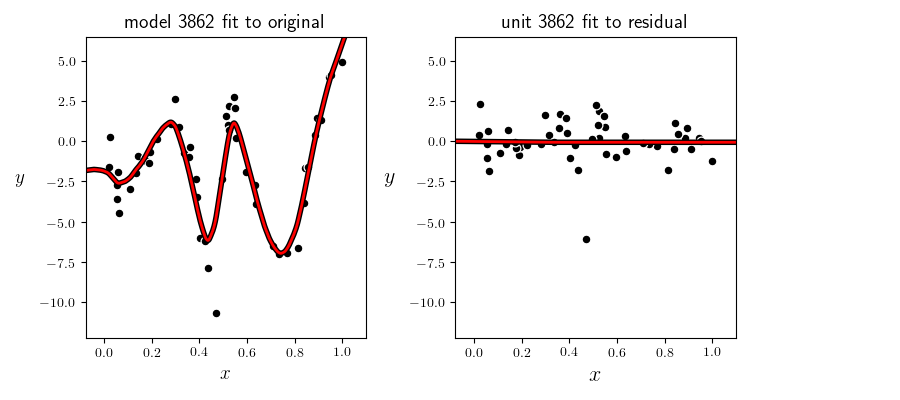
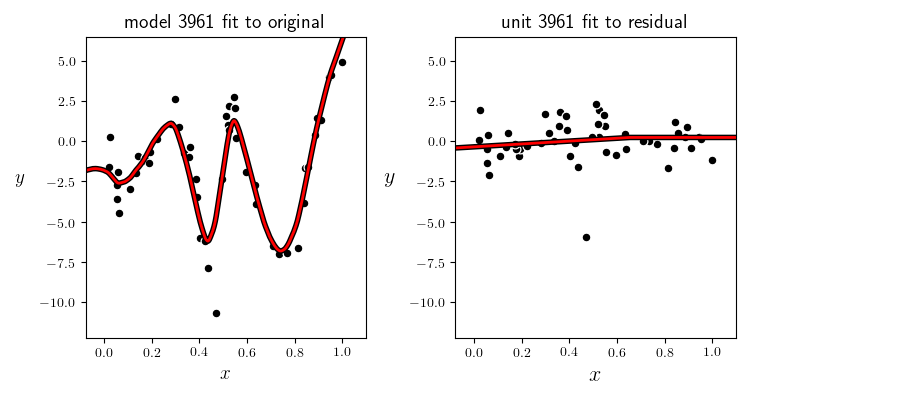
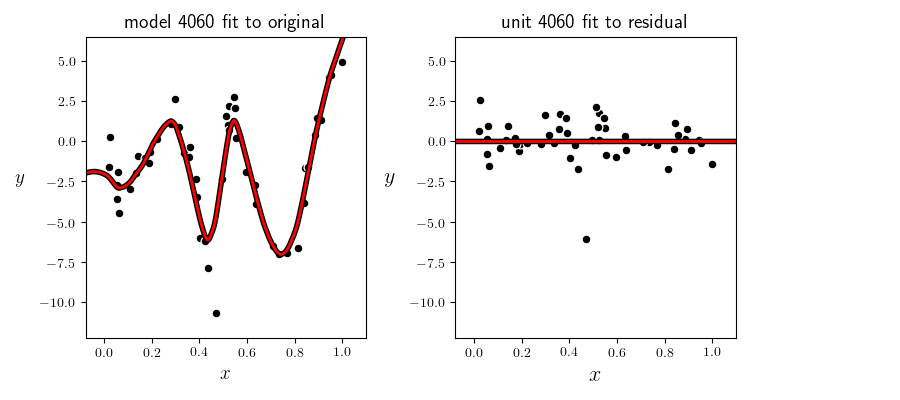
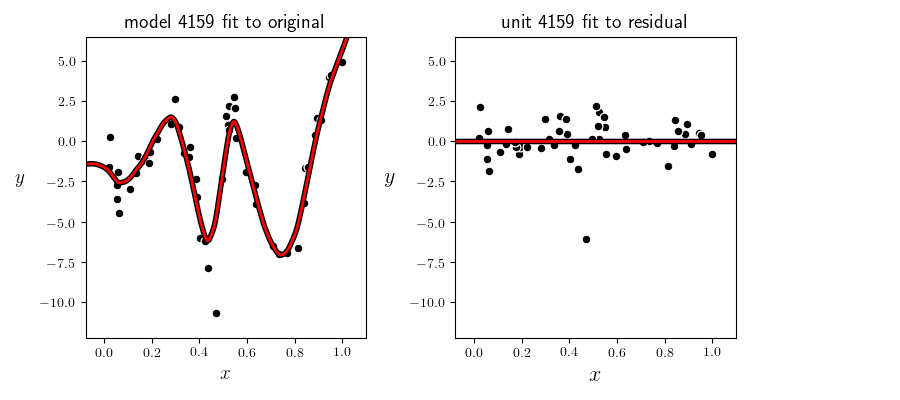
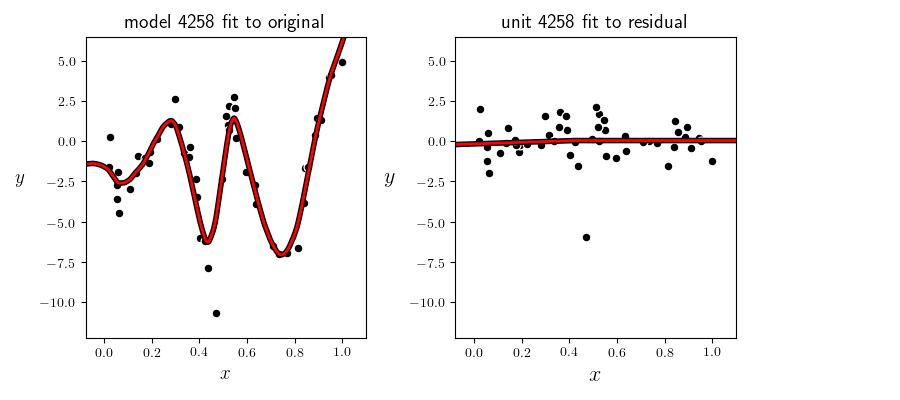
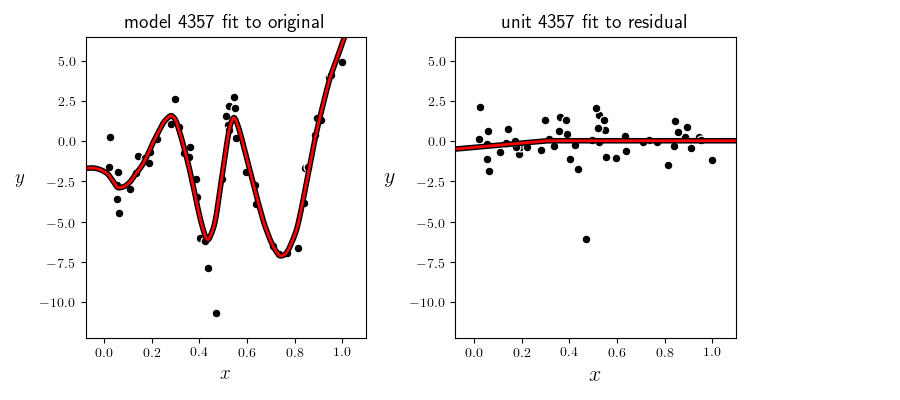
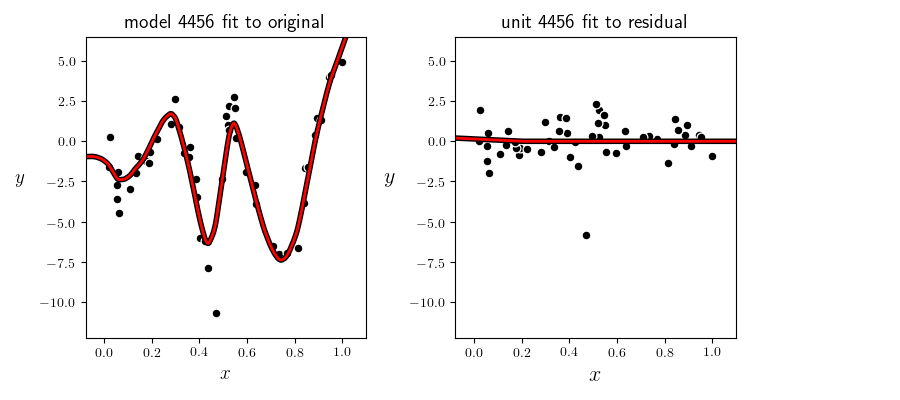
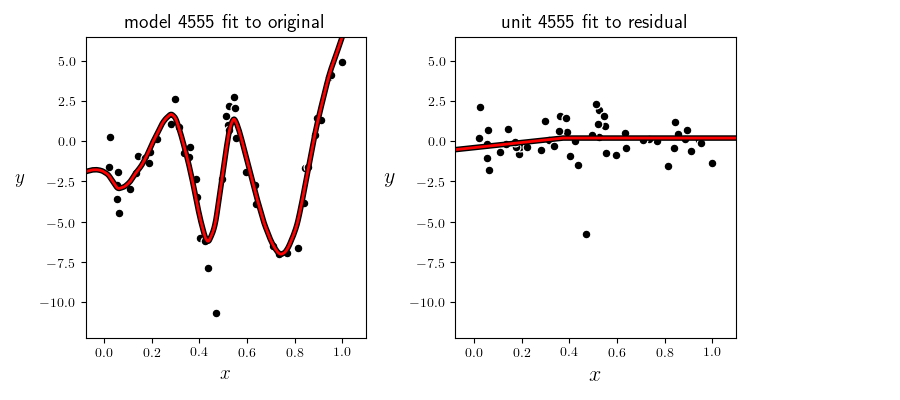
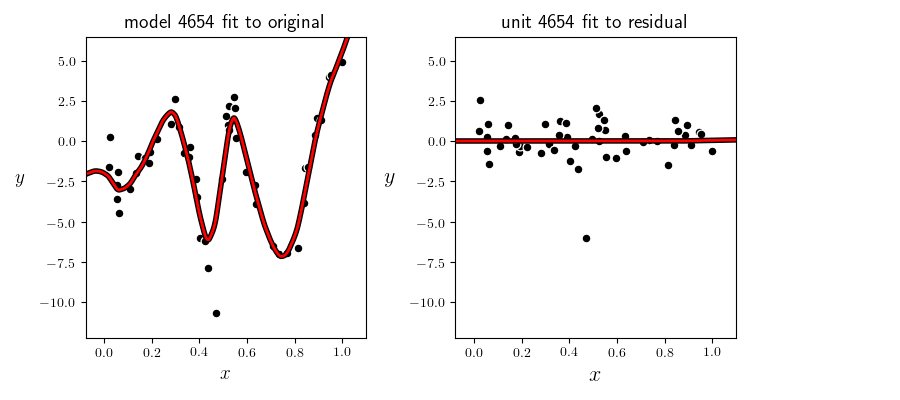
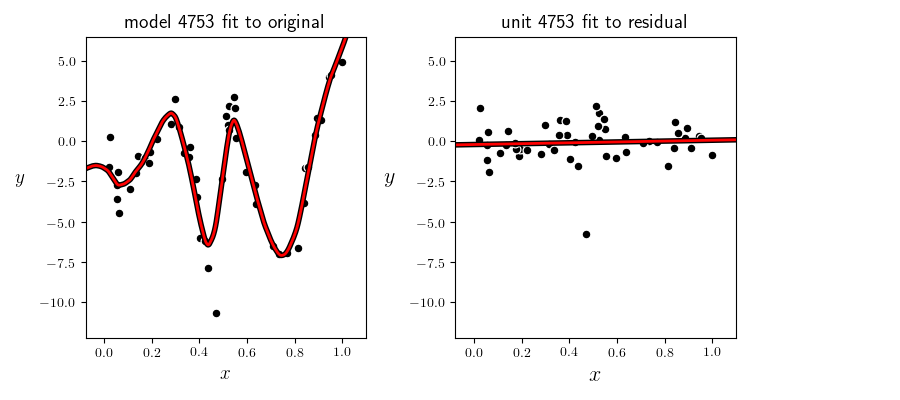
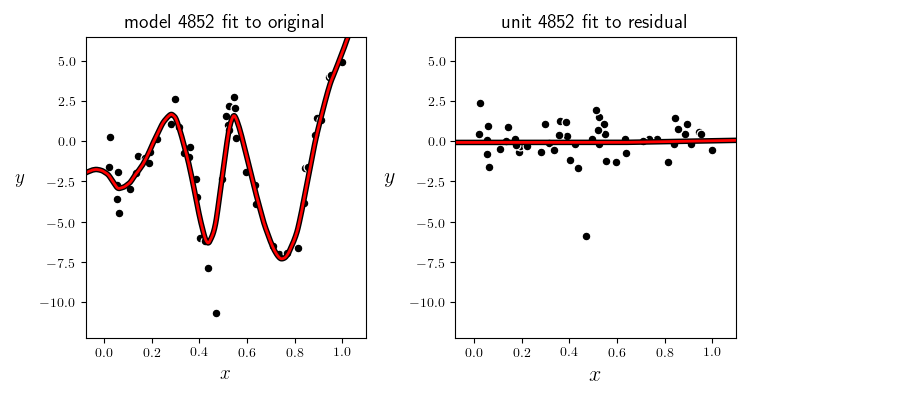

In [15]:
## This code cell will not be shown in the HTML version of this notebook
# load in dataset
csvname = datapath + 'universal_regression_samples_0.csv'
data = np.loadtxt(csvname,delimiter = ',')
x = copy.deepcopy(data[:-1,:])
y = copy.deepcopy(data[-1:,:] )

# boosting procedure
num_units = 5000
runs2 = []
for j in range(num_units):    
    # import the v1 library
    mylib2 = nonlib.library_v1.superlearn_setup.Setup(x,y)

    # choose features
    mylib2.choose_features(name = 'multilayer_perceptron',layer_sizes = [1,1,1],activation = 'relu',scale = 0.5)

    # choose normalizer
    mylib2.choose_normalizer(name = 'standard')
        
    # choose cost
    mylib2.choose_cost(name = 'least_squares')

    # fit an optimization
    mylib2.fit(max_its = 10,alpha_choice = 10**(-1))

    # add model to list
    runs2.append(copy.deepcopy(mylib2))
    
    # cut off output given model
    normalizer = mylib2.normalizer
    ind = np.argmin(mylib2.cost_histories[0])
    weights = mylib2.weight_histories[0][ind]
    y_pred =  mylib2.model(normalizer(x),weights)
    y -= y_pred
    
# animate the business
frames = 50
demo2 = nonlib.boosting_regression_animators.Visualizer(csvname)
demo2.animate_boosting(runs2,frames)

## 11.3.3  Summary

Here we have learned about *boosting*, a way of fine-tuning the capacity of a `model` by adding units one-at-a-time (or in general several at a time) to progressively build up `model` capacity.  This approach works particularly well when using low-capacity units, like the `tanh` or `relu` single layer units we have used in the examples here.  Using such units allows for fine-tuning of capacity, and for the determination of `models` with low validation error.  However when using more flexible units - like e.g., deep neural networks or tree-based approximators (as we will learn about in the Chapters that follow) - this approach provides a coarser amount of control since adding just a single unit can substantially increase `model` capacity, meaning that the 'right' amount of nonlinearity necessary to minimize validation error is easier to miss.  We actually saw this phenomenon in our final example, where in each round of boosting we added $10$ `tanh` units.  

&copy; This material is not to be distributed, copied, or reused without written permission from the authors.